# Generalized-Controllable Variational Autoencoder

GCVAE Loss: 
\begin{align}
    \mathcal{L}(x, z; \theta, \phi, \alpha, &\beta, \gamma) = (1- \alpha_t- \beta_t)\underset{z \sim q_{\phi}(z|x)}{\mathbb{E}}[\ln p_{\theta}(x|z)] - \beta_t\underset{p_{\mathcal{D}}}{\mathbb{E}} D_{KL}(q_{\phi}(z|x)|| p_{\theta}(z)) + \gamma_t D_{KL}(q_{\phi}(z)||p_{\theta}(z))
    \label{gcvae:eqn1}
\end{align}

We assume that the data is Gaussian for this experiment,
\begin{align}
\underset{z \sim q_{\phi}(z|x)}{\mathbb{E}}[\ln p_{\theta}(x|z)] &= \| x - \hat{x} \|^{2}_{2} \notag\\
\underset{p_{\mathcal{D}}}{\mathbb{E}} D_{KL}(q_{\phi}(z|x)|| p_{\theta}(z)) &= \frac{1}{2} \left[\ln \left|\frac{\Sigma_1}{\Sigma_0}\right| + m - tr(\Sigma_1\Sigma_0^{-1}) -  (\mu_1 - \mu_0)^T\Sigma_0^{-1}(\mu_1 - \mu_0)\right] \quad \notag \\
D_{KL}(q_{\phi}(z)||p_{\theta}(z)) &= D_{MMD}^{2}(q||p) \quad \text{or} \quad D_{MAH}(q||p)
\end{align}


### import dependencies 

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#------------------basic dependencies --------------------
seed = 42
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import tensorflow_datasets as tfds
from train_gcvae_2d import train_gcvae as gcvae #change this to train_gcvae_2d if you are working with GCVAE
#----import trainer for distributed training
from sklearn.model_selection import train_test_split
from utils import plot_latent_space, compute_metric, model_saver, model_saver_2d
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams['figure.dpi'] = 120
import seaborn as sns
#set random seed
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
path = os.getcwd()

### import MNIST image dataset

In [4]:
#declare path
path = os.getcwd()

#import data
datatype = "mnist"

batch_size = 64
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
N, L, M = x_train.shape
x_train = x_train.reshape(-1, L, M, 1).astype('float32') / x_train.max()
x_train, _ = train_test_split(x_train, test_size = .999, random_state = 42)
x_test = x_test.reshape(-1, L, M, 1).astype('float32') / x_train.max()
x_test, _ = train_test_split(x_test, test_size = .992, random_state = 42)

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size)

#test data
test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
test_dataset = test_dataset.shuffle(buffer_size = 1024).batch(batch_size)

In [5]:
print(f'Shape of train data: {x_train.shape}\nShape of test data: {x_test.shape}')

Shape of train data: (60, 28, 28, 1)
Shape of test data: (80, 28, 28, 1)


#### We are using 0.1% of the original MNIS dataset for training

Train data:


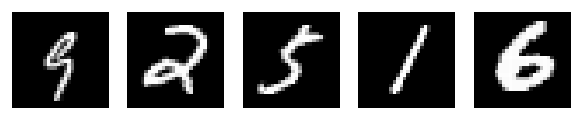

Test data:


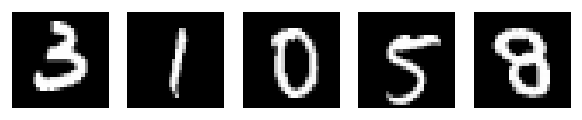

In [6]:
print('Train data:')
for i in range(5):  
    plt.subplot(150 + 1 + i)
    plt.imshow(x_train[i], cmap = plt.get_cmap('gray'))
    plt.axis('off')
plt.show()
print('Test data:')
for i in range(5):  
    plt.subplot(150 + 1 + i)
    plt.imshow(x_test[i], cmap = plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

### Try Variational AutoEncoder first...For 500-iterations

In [11]:
loss_index = 0
# vae_type = 'gcvae' #else infovae
inp_shape =  x_train.shape[1:]
num_features = inp_shape[0]

#the parameters are only to change fixed weights
params = { #beta, gamma
            'elbo': (1, 0),
            'betavae': ((1, 5), 0),
            'controlvae': (0, 0),
            'infovae': (0, 500),
            'gcvae': (1, 1), #not necessarily useful inside algo
    }

lr = 1e-3
epochs = 500
hidden_dim = 100
latent_dims = 2
loss_type = list(params.keys())[loss_index] #elbo -> 0; beta-> 1; controlvae -> 2; infovae -> 3; gcvae -> 4
archi_type = 'v2' #uses 2D Convolutions
#params
distrib_type = 'g'
beta, gamma = params[f'{loss_type}']
mmd_typ = 'mmd' #['mmd', 'mah', 'mah_rkhs', 'mah_gcvae']
save_model_arg = False
save_model_after = 10
model = gcvae(inp_shape = inp_shape,
                    num_features = num_features,
                    hidden_dim = hidden_dim,
                    latent_dim = latent_dims, 
                    batch_size = batch_size,
                    beta = beta,
                    gamma = gamma,
                    dist = distrib_type,
                    vloss = loss_type,
                    lr = lr, 
                    epochs = epochs,
                    architecture = archi_type,
                    mmd_type = mmd_typ).fit(train_dataset, x_test,
                                            datatype, stopping = False,
                                            save_model = save_model_arg,
                                            save_model_iter = save_model_after)

100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 1 - ELBO: 84.676 - RECON. LOSS: 84.675 - KL: 0.001 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 2 - ELBO: 81.802 - RECON. LOSS: 81.798 - KL: 0.004 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 3 - ELBO: 78.926 - RECON. LOSS: 78.916 - KL: 0.009 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 4 - ELBO: 76.175 - RECON. LOSS: 76.154 - KL: 0.021 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 5 - ELBO: 74.926 - RECON. LOSS: 74.885 - KL: 0.042 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 6 - ELBO: 74.439 - RECON. LOSS: 74.383 - KL: 0.056 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 7 - ELBO: 73.770 - RECON. LOSS: 73.709 - KL: 0.061 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 8 - ELBO: 72.990 - RECON. LOSS: 72.930 - KL: 0.060 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch 9 - ELBO: 72.277 - RECON. LOSS: 72.220 - KL: 0.057 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 10 - ELBO: 71.656 - RECON. LOSS: 71.602 - KL: 0.054 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 11 - ELBO: 71.156 - RECON. LOSS: 71.106 - KL: 0.051 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 12 - ELBO: 70.629 - RECON. LOSS: 70.581 - KL: 0.048 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 13 - ELBO: 70.141 - RECON. LOSS: 70.096 - KL: 0.046 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 14 - ELBO: 69.603 - RECON. LOSS: 69.560 - KL: 0.044 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 15 - ELBO: 69.091 - RECON. LOSS: 69.048 - KL: 0.042 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 16 - ELBO: 68.538 - RECON. LOSS: 68.496 - KL: 0.041 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 17 - ELBO: 68.007 - RECON. LOSS: 67.966 - KL: 0.041 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 18 - ELBO: 67.553 - RECON. LOSS: 67.513 - KL: 0.040 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 19 - ELBO: 67.112 - RECON. LOSS: 67.072 - KL: 0.040 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 20 - ELBO: 66.676 - RECON. LOSS: 66.637 - KL: 0.040 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 21 - ELBO: 66.176 - RECON. LOSS: 66.137 - KL: 0.039 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 22 - ELBO: 65.765 - RECON. LOSS: 65.726 - KL: 0.039 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 23 - ELBO: 65.371 - RECON. LOSS: 65.332 - KL: 0.039 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 24 - ELBO: 65.043 - RECON. LOSS: 65.004 - KL: 0.038 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 25 - ELBO: 64.676 - RECON. LOSS: 64.638 - KL: 0.038 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 26 - ELBO: 64.374 - RECON. LOSS: 64.336 - KL: 0.037 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 27 - ELBO: 64.111 - RECON. LOSS: 64.074 - KL: 0.037 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 28 - ELBO: 63.776 - RECON. LOSS: 63.740 - KL: 0.036 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 29 - ELBO: 63.487 - RECON. LOSS: 63.452 - KL: 0.036 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 30 - ELBO: 63.203 - RECON. LOSS: 63.168 - KL: 0.035 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 31 - ELBO: 62.909 - RECON. LOSS: 62.874 - KL: 0.034 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 32 - ELBO: 62.631 - RECON. LOSS: 62.597 - KL: 0.034 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 33 - ELBO: 62.366 - RECON. LOSS: 62.333 - KL: 0.033 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 34 - ELBO: 62.149 - RECON. LOSS: 62.117 - KL: 0.032 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 35 - ELBO: 61.915 - RECON. LOSS: 61.883 - KL: 0.032 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 36 - ELBO: 61.690 - RECON. LOSS: 61.659 - KL: 0.031 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 37 - ELBO: 61.479 - RECON. LOSS: 61.449 - KL: 0.030 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 38 - ELBO: 61.294 - RECON. LOSS: 61.265 - KL: 0.030 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 39 - ELBO: 61.121 - RECON. LOSS: 61.092 - KL: 0.029 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


epoch 40 - ELBO: 60.933 - RECON. LOSS: 60.905 - KL: 0.028 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 41 - ELBO: 60.782 - RECON. LOSS: 60.754 - KL: 0.028 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


epoch 42 - ELBO: 60.606 - RECON. LOSS: 60.579 - KL: 0.027 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 43 - ELBO: 60.451 - RECON. LOSS: 60.424 - KL: 0.027 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 44 - ELBO: 60.298 - RECON. LOSS: 60.272 - KL: 0.026 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 45 - ELBO: 60.154 - RECON. LOSS: 60.129 - KL: 0.026 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 46 - ELBO: 60.018 - RECON. LOSS: 59.993 - KL: 0.025 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


epoch 47 - ELBO: 59.885 - RECON. LOSS: 59.860 - KL: 0.025 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 48 - ELBO: 59.753 - RECON. LOSS: 59.728 - KL: 0.024 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 49 - ELBO: 59.628 - RECON. LOSS: 59.604 - KL: 0.024 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 50 - ELBO: 59.501 - RECON. LOSS: 59.478 - KL: 0.023 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 51 - ELBO: 59.386 - RECON. LOSS: 59.363 - KL: 0.023 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 52 - ELBO: 59.269 - RECON. LOSS: 59.247 - KL: 0.023 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 53 - ELBO: 59.159 - RECON. LOSS: 59.137 - KL: 0.022 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 54 - ELBO: 59.054 - RECON. LOSS: 59.032 - KL: 0.022 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 55 - ELBO: 58.953 - RECON. LOSS: 58.931 - KL: 0.021 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 56 - ELBO: 58.853 - RECON. LOSS: 58.832 - KL: 0.021 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 57 - ELBO: 58.753 - RECON. LOSS: 58.733 - KL: 0.021 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 58 - ELBO: 58.657 - RECON. LOSS: 58.637 - KL: 0.020 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 59 - ELBO: 58.568 - RECON. LOSS: 58.548 - KL: 0.020 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 60 - ELBO: 58.482 - RECON. LOSS: 58.462 - KL: 0.020 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 61 - ELBO: 58.394 - RECON. LOSS: 58.375 - KL: 0.019 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 62 - ELBO: 58.313 - RECON. LOSS: 58.294 - KL: 0.019 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 63 - ELBO: 58.236 - RECON. LOSS: 58.217 - KL: 0.019 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 64 - ELBO: 58.157 - RECON. LOSS: 58.139 - KL: 0.019 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


epoch 65 - ELBO: 58.082 - RECON. LOSS: 58.064 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 66 - ELBO: 58.006 - RECON. LOSS: 57.988 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


epoch 67 - ELBO: 57.933 - RECON. LOSS: 57.916 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 68 - ELBO: 57.859 - RECON. LOSS: 57.842 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 69 - ELBO: 57.791 - RECON. LOSS: 57.773 - KL: 0.017 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 70 - ELBO: 57.726 - RECON. LOSS: 57.709 - KL: 0.017 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 71 - ELBO: 57.661 - RECON. LOSS: 57.644 - KL: 0.017 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 72 - ELBO: 57.601 - RECON. LOSS: 57.584 - KL: 0.017 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 73 - ELBO: 57.538 - RECON. LOSS: 57.522 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 74 - ELBO: 57.477 - RECON. LOSS: 57.461 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


epoch 75 - ELBO: 57.417 - RECON. LOSS: 57.401 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


epoch 76 - ELBO: 57.361 - RECON. LOSS: 57.345 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


epoch 77 - ELBO: 57.302 - RECON. LOSS: 57.286 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 78 - ELBO: 57.247 - RECON. LOSS: 57.231 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 79 - ELBO: 57.192 - RECON. LOSS: 57.177 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 80 - ELBO: 57.139 - RECON. LOSS: 57.124 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 81 - ELBO: 57.085 - RECON. LOSS: 57.070 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 82 - ELBO: 57.037 - RECON. LOSS: 57.022 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 83 - ELBO: 56.987 - RECON. LOSS: 56.972 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


epoch 84 - ELBO: 56.938 - RECON. LOSS: 56.924 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 85 - ELBO: 56.890 - RECON. LOSS: 56.876 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 86 - ELBO: 56.844 - RECON. LOSS: 56.830 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 87 - ELBO: 56.798 - RECON. LOSS: 56.784 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 88 - ELBO: 56.754 - RECON. LOSS: 56.740 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 89 - ELBO: 56.713 - RECON. LOSS: 56.699 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 90 - ELBO: 56.669 - RECON. LOSS: 56.656 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 91 - ELBO: 56.627 - RECON. LOSS: 56.613 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 92 - ELBO: 56.587 - RECON. LOSS: 56.574 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 93 - ELBO: 56.546 - RECON. LOSS: 56.533 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 94 - ELBO: 56.508 - RECON. LOSS: 56.495 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 95 - ELBO: 56.469 - RECON. LOSS: 56.456 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 96 - ELBO: 56.430 - RECON. LOSS: 56.418 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 97 - ELBO: 56.396 - RECON. LOSS: 56.383 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


epoch 98 - ELBO: 56.360 - RECON. LOSS: 56.348 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 99 - ELBO: 56.327 - RECON. LOSS: 56.314 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 100 - ELBO: 56.293 - RECON. LOSS: 56.281 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


epoch 101 - ELBO: 56.261 - RECON. LOSS: 56.249 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 102 - ELBO: 56.227 - RECON. LOSS: 56.214 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


epoch 103 - ELBO: 56.194 - RECON. LOSS: 56.182 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 104 - ELBO: 56.160 - RECON. LOSS: 56.148 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

epoch 105 - ELBO: 56.128 - RECON. LOSS: 56.116 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


epoch 106 - ELBO: 56.100 - RECON. LOSS: 56.088 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 107 - ELBO: 56.069 - RECON. LOSS: 56.057 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 108 - ELBO: 56.039 - RECON. LOSS: 56.027 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 109 - ELBO: 56.009 - RECON. LOSS: 55.998 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 110 - ELBO: 55.980 - RECON. LOSS: 55.968 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 111 - ELBO: 55.950 - RECON. LOSS: 55.939 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 112 - ELBO: 55.923 - RECON. LOSS: 55.912 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 113 - ELBO: 55.897 - RECON. LOSS: 55.885 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 114 - ELBO: 55.866 - RECON. LOSS: 55.855 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 115 - ELBO: 55.839 - RECON. LOSS: 55.827 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 116 - ELBO: 55.813 - RECON. LOSS: 55.802 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 117 - ELBO: 55.789 - RECON. LOSS: 55.778 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 118 - ELBO: 55.764 - RECON. LOSS: 55.753 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 119 - ELBO: 55.740 - RECON. LOSS: 55.729 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 120 - ELBO: 55.717 - RECON. LOSS: 55.706 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 121 - ELBO: 55.691 - RECON. LOSS: 55.680 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 122 - ELBO: 55.668 - RECON. LOSS: 55.657 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 123 - ELBO: 55.643 - RECON. LOSS: 55.633 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 124 - ELBO: 55.619 - RECON. LOSS: 55.608 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 125 - ELBO: 55.599 - RECON. LOSS: 55.588 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 126 - ELBO: 55.576 - RECON. LOSS: 55.565 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 127 - ELBO: 55.552 - RECON. LOSS: 55.541 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


epoch 128 - ELBO: 55.529 - RECON. LOSS: 55.518 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 129 - ELBO: 55.508 - RECON. LOSS: 55.497 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 130 - ELBO: 55.485 - RECON. LOSS: 55.474 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 131 - ELBO: 55.465 - RECON. LOSS: 55.453 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 132 - ELBO: 55.443 - RECON. LOSS: 55.432 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 133 - ELBO: 55.420 - RECON. LOSS: 55.409 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 134 - ELBO: 55.400 - RECON. LOSS: 55.389 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 135 - ELBO: 55.382 - RECON. LOSS: 55.371 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 136 - ELBO: 55.364 - RECON. LOSS: 55.352 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 137 - ELBO: 55.345 - RECON. LOSS: 55.333 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


epoch 138 - ELBO: 55.325 - RECON. LOSS: 55.313 - KL: 0.011 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


epoch 139 - ELBO: 55.305 - RECON. LOSS: 55.294 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 140 - ELBO: 55.283 - RECON. LOSS: 55.272 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 141 - ELBO: 55.265 - RECON. LOSS: 55.253 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 142 - ELBO: 55.248 - RECON. LOSS: 55.236 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 143 - ELBO: 55.230 - RECON. LOSS: 55.218 - KL: 0.012 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 144 - ELBO: 55.213 - RECON. LOSS: 55.200 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 145 - ELBO: 55.193 - RECON. LOSS: 55.180 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 146 - ELBO: 55.175 - RECON. LOSS: 55.162 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 147 - ELBO: 55.158 - RECON. LOSS: 55.145 - KL: 0.013 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 148 - ELBO: 55.142 - RECON. LOSS: 55.128 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 149 - ELBO: 55.125 - RECON. LOSS: 55.110 - KL: 0.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 150 - ELBO: 55.106 - RECON. LOSS: 55.091 - KL: 0.015 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 151 - ELBO: 55.089 - RECON. LOSS: 55.074 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 152 - ELBO: 55.075 - RECON. LOSS: 55.059 - KL: 0.016 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 153 - ELBO: 55.058 - RECON. LOSS: 55.042 - KL: 0.017 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 154 - ELBO: 55.044 - RECON. LOSS: 55.026 - KL: 0.017 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 155 - ELBO: 55.028 - RECON. LOSS: 55.009 - KL: 0.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 156 - ELBO: 55.009 - RECON. LOSS: 54.989 - KL: 0.019 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 157 - ELBO: 54.993 - RECON. LOSS: 54.973 - KL: 0.020 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 158 - ELBO: 54.973 - RECON. LOSS: 54.952 - KL: 0.022 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 159 - ELBO: 54.954 - RECON. LOSS: 54.930 - KL: 0.024 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 160 - ELBO: 54.934 - RECON. LOSS: 54.909 - KL: 0.026 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 161 - ELBO: 54.918 - RECON. LOSS: 54.892 - KL: 0.027 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 162 - ELBO: 54.903 - RECON. LOSS: 54.875 - KL: 0.027 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 163 - ELBO: 54.886 - RECON. LOSS: 54.857 - KL: 0.028 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 164 - ELBO: 54.870 - RECON. LOSS: 54.840 - KL: 0.031 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 165 - ELBO: 54.850 - RECON. LOSS: 54.818 - KL: 0.032 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 166 - ELBO: 54.832 - RECON. LOSS: 54.797 - KL: 0.035 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 167 - ELBO: 54.818 - RECON. LOSS: 54.780 - KL: 0.039 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 168 - ELBO: 54.805 - RECON. LOSS: 54.765 - KL: 0.041 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 169 - ELBO: 54.789 - RECON. LOSS: 54.748 - KL: 0.042 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 170 - ELBO: 54.771 - RECON. LOSS: 54.727 - KL: 0.044 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 171 - ELBO: 54.756 - RECON. LOSS: 54.705 - KL: 0.051 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 172 - ELBO: 54.749 - RECON. LOSS: 54.695 - KL: 0.054 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


epoch 173 - ELBO: 54.734 - RECON. LOSS: 54.678 - KL: 0.056 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 174 - ELBO: 54.719 - RECON. LOSS: 54.661 - KL: 0.058 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 175 - ELBO: 54.708 - RECON. LOSS: 54.648 - KL: 0.060 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 176 - ELBO: 54.693 - RECON. LOSS: 54.631 - KL: 0.062 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 177 - ELBO: 54.674 - RECON. LOSS: 54.611 - KL: 0.064 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 178 - ELBO: 54.656 - RECON. LOSS: 54.589 - KL: 0.067 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

epoch 179 - ELBO: 54.645 - RECON. LOSS: 54.572 - KL: 0.073 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 180 - ELBO: 54.630 - RECON. LOSS: 54.551 - KL: 0.079 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 181 - ELBO: 54.608 - RECON. LOSS: 54.527 - KL: 0.081 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 182 - ELBO: 54.595 - RECON. LOSS: 54.512 - KL: 0.083 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 183 - ELBO: 54.579 - RECON. LOSS: 54.495 - KL: 0.084 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 184 - ELBO: 54.565 - RECON. LOSS: 54.479 - KL: 0.086 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 185 - ELBO: 54.548 - RECON. LOSS: 54.458 - KL: 0.089 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 186 - ELBO: 54.529 - RECON. LOSS: 54.437 - KL: 0.092 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 187 - ELBO: 54.516 - RECON. LOSS: 54.419 - KL: 0.096 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 188 - ELBO: 54.500 - RECON. LOSS: 54.400 - KL: 0.100 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 189 - ELBO: 54.482 - RECON. LOSS: 54.380 - KL: 0.103 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 190 - ELBO: 54.466 - RECON. LOSS: 54.362 - KL: 0.104 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 191 - ELBO: 54.451 - RECON. LOSS: 54.346 - KL: 0.106 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 192 - ELBO: 54.439 - RECON. LOSS: 54.331 - KL: 0.108 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 193 - ELBO: 54.419 - RECON. LOSS: 54.308 - KL: 0.110 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 194 - ELBO: 54.403 - RECON. LOSS: 54.290 - KL: 0.113 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 195 - ELBO: 54.385 - RECON. LOSS: 54.267 - KL: 0.118 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 196 - ELBO: 54.368 - RECON. LOSS: 54.245 - KL: 0.124 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 197 - ELBO: 54.352 - RECON. LOSS: 54.222 - KL: 0.129 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 198 - ELBO: 54.338 - RECON. LOSS: 54.204 - KL: 0.134 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 199 - ELBO: 54.319 - RECON. LOSS: 54.180 - KL: 0.138 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 200 - ELBO: 54.302 - RECON. LOSS: 54.160 - KL: 0.142 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 201 - ELBO: 54.284 - RECON. LOSS: 54.137 - KL: 0.148 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 202 - ELBO: 54.265 - RECON. LOSS: 54.111 - KL: 0.154 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 203 - ELBO: 54.244 - RECON. LOSS: 54.083 - KL: 0.162 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 204 - ELBO: 54.226 - RECON. LOSS: 54.058 - KL: 0.168 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 205 - ELBO: 54.207 - RECON. LOSS: 54.032 - KL: 0.175 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 206 - ELBO: 54.189 - RECON. LOSS: 54.011 - KL: 0.178 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 207 - ELBO: 54.168 - RECON. LOSS: 53.985 - KL: 0.183 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 208 - ELBO: 54.147 - RECON. LOSS: 53.957 - KL: 0.190 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 209 - ELBO: 54.127 - RECON. LOSS: 53.930 - KL: 0.197 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 210 - ELBO: 54.111 - RECON. LOSS: 53.909 - KL: 0.202 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 211 - ELBO: 54.090 - RECON. LOSS: 53.881 - KL: 0.209 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 212 - ELBO: 54.075 - RECON. LOSS: 53.858 - KL: 0.217 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 213 - ELBO: 54.055 - RECON. LOSS: 53.833 - KL: 0.222 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 214 - ELBO: 54.037 - RECON. LOSS: 53.812 - KL: 0.226 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 215 - ELBO: 54.019 - RECON. LOSS: 53.786 - KL: 0.233 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 216 - ELBO: 53.998 - RECON. LOSS: 53.758 - KL: 0.240 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 217 - ELBO: 53.979 - RECON. LOSS: 53.736 - KL: 0.244 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 218 - ELBO: 53.961 - RECON. LOSS: 53.714 - KL: 0.247 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 219 - ELBO: 53.939 - RECON. LOSS: 53.687 - KL: 0.252 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 220 - ELBO: 53.921 - RECON. LOSS: 53.663 - KL: 0.258 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 221 - ELBO: 53.899 - RECON. LOSS: 53.636 - KL: 0.263 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 222 - ELBO: 53.881 - RECON. LOSS: 53.615 - KL: 0.266 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 223 - ELBO: 53.858 - RECON. LOSS: 53.588 - KL: 0.270 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 224 - ELBO: 53.844 - RECON. LOSS: 53.568 - KL: 0.277 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


epoch 225 - ELBO: 53.822 - RECON. LOSS: 53.540 - KL: 0.282 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 226 - ELBO: 53.805 - RECON. LOSS: 53.520 - KL: 0.286 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 227 - ELBO: 53.783 - RECON. LOSS: 53.493 - KL: 0.290 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 228 - ELBO: 53.766 - RECON. LOSS: 53.470 - KL: 0.296 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 229 - ELBO: 53.746 - RECON. LOSS: 53.445 - KL: 0.302 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 230 - ELBO: 53.728 - RECON. LOSS: 53.421 - KL: 0.307 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 231 - ELBO: 53.706 - RECON. LOSS: 53.393 - KL: 0.314 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 232 - ELBO: 53.686 - RECON. LOSS: 53.365 - KL: 0.321 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 233 - ELBO: 53.666 - RECON. LOSS: 53.339 - KL: 0.327 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 234 - ELBO: 53.648 - RECON. LOSS: 53.316 - KL: 0.332 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 235 - ELBO: 53.629 - RECON. LOSS: 53.293 - KL: 0.336 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 236 - ELBO: 53.607 - RECON. LOSS: 53.266 - KL: 0.341 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 237 - ELBO: 53.588 - RECON. LOSS: 53.243 - KL: 0.345 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 238 - ELBO: 53.569 - RECON. LOSS: 53.218 - KL: 0.351 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 239 - ELBO: 53.548 - RECON. LOSS: 53.191 - KL: 0.357 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 240 - ELBO: 53.530 - RECON. LOSS: 53.169 - KL: 0.360 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 241 - ELBO: 53.513 - RECON. LOSS: 53.149 - KL: 0.364 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 242 - ELBO: 53.494 - RECON. LOSS: 53.126 - KL: 0.369 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 243 - ELBO: 53.475 - RECON. LOSS: 53.102 - KL: 0.373 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 244 - ELBO: 53.457 - RECON. LOSS: 53.080 - KL: 0.377 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 245 - ELBO: 53.440 - RECON. LOSS: 53.057 - KL: 0.382 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 246 - ELBO: 53.418 - RECON. LOSS: 53.030 - KL: 0.389 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 247 - ELBO: 53.400 - RECON. LOSS: 53.006 - KL: 0.395 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 248 - ELBO: 53.381 - RECON. LOSS: 52.981 - KL: 0.400 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 249 - ELBO: 53.359 - RECON. LOSS: 52.952 - KL: 0.407 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 250 - ELBO: 53.340 - RECON. LOSS: 52.928 - KL: 0.412 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 251 - ELBO: 53.319 - RECON. LOSS: 52.902 - KL: 0.417 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 252 - ELBO: 53.301 - RECON. LOSS: 52.879 - KL: 0.423 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 253 - ELBO: 53.284 - RECON. LOSS: 52.857 - KL: 0.427 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 254 - ELBO: 53.265 - RECON. LOSS: 52.834 - KL: 0.431 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 255 - ELBO: 53.246 - RECON. LOSS: 52.810 - KL: 0.435 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 256 - ELBO: 53.224 - RECON. LOSS: 52.784 - KL: 0.440 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 257 - ELBO: 53.202 - RECON. LOSS: 52.758 - KL: 0.444 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 258 - ELBO: 53.185 - RECON. LOSS: 52.736 - KL: 0.449 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 259 - ELBO: 53.167 - RECON. LOSS: 52.714 - KL: 0.453 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 260 - ELBO: 53.148 - RECON. LOSS: 52.690 - KL: 0.458 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 261 - ELBO: 53.126 - RECON. LOSS: 52.664 - KL: 0.462 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 262 - ELBO: 53.106 - RECON. LOSS: 52.639 - KL: 0.466 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 263 - ELBO: 53.086 - RECON. LOSS: 52.615 - KL: 0.471 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 264 - ELBO: 53.067 - RECON. LOSS: 52.592 - KL: 0.475 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 265 - ELBO: 53.046 - RECON. LOSS: 52.567 - KL: 0.479 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 266 - ELBO: 53.025 - RECON. LOSS: 52.540 - KL: 0.485 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 267 - ELBO: 53.005 - RECON. LOSS: 52.516 - KL: 0.490 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 268 - ELBO: 52.987 - RECON. LOSS: 52.494 - KL: 0.493 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 269 - ELBO: 52.967 - RECON. LOSS: 52.470 - KL: 0.497 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 270 - ELBO: 52.946 - RECON. LOSS: 52.444 - KL: 0.502 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 271 - ELBO: 52.929 - RECON. LOSS: 52.423 - KL: 0.506 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 272 - ELBO: 52.910 - RECON. LOSS: 52.399 - KL: 0.511 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

epoch 273 - ELBO: 52.889 - RECON. LOSS: 52.375 - KL: 0.515 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 274 - ELBO: 52.871 - RECON. LOSS: 52.352 - KL: 0.519 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 275 - ELBO: 52.849 - RECON. LOSS: 52.327 - KL: 0.523 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 276 - ELBO: 52.834 - RECON. LOSS: 52.308 - KL: 0.526 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 277 - ELBO: 52.813 - RECON. LOSS: 52.283 - KL: 0.530 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 278 - ELBO: 52.795 - RECON. LOSS: 52.259 - KL: 0.535 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 279 - ELBO: 52.775 - RECON. LOSS: 52.236 - KL: 0.539 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 280 - ELBO: 52.756 - RECON. LOSS: 52.214 - KL: 0.542 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 281 - ELBO: 52.737 - RECON. LOSS: 52.191 - KL: 0.546 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 282 - ELBO: 52.720 - RECON. LOSS: 52.169 - KL: 0.550 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 283 - ELBO: 52.702 - RECON. LOSS: 52.147 - KL: 0.555 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 284 - ELBO: 52.683 - RECON. LOSS: 52.123 - KL: 0.560 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 285 - ELBO: 52.662 - RECON. LOSS: 52.098 - KL: 0.564 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 286 - ELBO: 52.645 - RECON. LOSS: 52.076 - KL: 0.569 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 287 - ELBO: 52.629 - RECON. LOSS: 52.055 - KL: 0.574 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 288 - ELBO: 52.611 - RECON. LOSS: 52.032 - KL: 0.579 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 289 - ELBO: 52.591 - RECON. LOSS: 52.008 - KL: 0.583 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


epoch 290 - ELBO: 52.577 - RECON. LOSS: 51.990 - KL: 0.587 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 291 - ELBO: 52.560 - RECON. LOSS: 51.969 - KL: 0.591 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 292 - ELBO: 52.541 - RECON. LOSS: 51.945 - KL: 0.595 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 293 - ELBO: 52.522 - RECON. LOSS: 51.922 - KL: 0.600 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 294 - ELBO: 52.503 - RECON. LOSS: 51.900 - KL: 0.603 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 295 - ELBO: 52.485 - RECON. LOSS: 51.878 - KL: 0.607 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 296 - ELBO: 52.465 - RECON. LOSS: 51.855 - KL: 0.611 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 297 - ELBO: 52.447 - RECON. LOSS: 51.832 - KL: 0.615 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 298 - ELBO: 52.427 - RECON. LOSS: 51.808 - KL: 0.619 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 299 - ELBO: 52.410 - RECON. LOSS: 51.787 - KL: 0.623 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 300 - ELBO: 52.393 - RECON. LOSS: 51.766 - KL: 0.627 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 301 - ELBO: 52.375 - RECON. LOSS: 51.745 - KL: 0.630 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 302 - ELBO: 52.357 - RECON. LOSS: 51.723 - KL: 0.634 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 303 - ELBO: 52.340 - RECON. LOSS: 51.701 - KL: 0.639 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 304 - ELBO: 52.318 - RECON. LOSS: 51.676 - KL: 0.643 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 305 - ELBO: 52.303 - RECON. LOSS: 51.658 - KL: 0.646 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 306 - ELBO: 52.285 - RECON. LOSS: 51.635 - KL: 0.650 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 307 - ELBO: 52.268 - RECON. LOSS: 51.613 - KL: 0.655 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 308 - ELBO: 52.251 - RECON. LOSS: 51.592 - KL: 0.659 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 309 - ELBO: 52.231 - RECON. LOSS: 51.568 - KL: 0.663 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 310 - ELBO: 52.213 - RECON. LOSS: 51.546 - KL: 0.667 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 311 - ELBO: 52.193 - RECON. LOSS: 51.522 - KL: 0.671 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 312 - ELBO: 52.177 - RECON. LOSS: 51.503 - KL: 0.674 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 313 - ELBO: 52.161 - RECON. LOSS: 51.483 - KL: 0.678 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 314 - ELBO: 52.144 - RECON. LOSS: 51.462 - KL: 0.682 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 315 - ELBO: 52.125 - RECON. LOSS: 51.440 - KL: 0.685 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 316 - ELBO: 52.105 - RECON. LOSS: 51.417 - KL: 0.689 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 317 - ELBO: 52.087 - RECON. LOSS: 51.394 - KL: 0.692 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 318 - ELBO: 52.068 - RECON. LOSS: 51.371 - KL: 0.697 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 319 - ELBO: 52.048 - RECON. LOSS: 51.348 - KL: 0.700 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 320 - ELBO: 52.034 - RECON. LOSS: 51.331 - KL: 0.703 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 321 - ELBO: 52.018 - RECON. LOSS: 51.310 - KL: 0.708 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 322 - ELBO: 51.999 - RECON. LOSS: 51.287 - KL: 0.712 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 323 - ELBO: 51.982 - RECON. LOSS: 51.266 - KL: 0.715 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 324 - ELBO: 51.961 - RECON. LOSS: 51.242 - KL: 0.720 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 325 - ELBO: 51.942 - RECON. LOSS: 51.218 - KL: 0.724 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 326 - ELBO: 51.924 - RECON. LOSS: 51.196 - KL: 0.728 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 327 - ELBO: 51.905 - RECON. LOSS: 51.172 - KL: 0.732 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 328 - ELBO: 51.887 - RECON. LOSS: 51.150 - KL: 0.737 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


epoch 329 - ELBO: 51.867 - RECON. LOSS: 51.127 - KL: 0.741 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 330 - ELBO: 51.849 - RECON. LOSS: 51.105 - KL: 0.745 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 331 - ELBO: 51.833 - RECON. LOSS: 51.083 - KL: 0.750 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 332 - ELBO: 51.814 - RECON. LOSS: 51.061 - KL: 0.754 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 333 - ELBO: 51.797 - RECON. LOSS: 51.040 - KL: 0.757 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 334 - ELBO: 51.780 - RECON. LOSS: 51.018 - KL: 0.762 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 335 - ELBO: 51.761 - RECON. LOSS: 50.995 - KL: 0.766 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 336 - ELBO: 51.743 - RECON. LOSS: 50.974 - KL: 0.769 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 337 - ELBO: 51.723 - RECON. LOSS: 50.950 - KL: 0.773 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 338 - ELBO: 51.703 - RECON. LOSS: 50.927 - KL: 0.777 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 339 - ELBO: 51.684 - RECON. LOSS: 50.903 - KL: 0.781 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 340 - ELBO: 51.667 - RECON. LOSS: 50.883 - KL: 0.784 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


epoch 341 - ELBO: 51.646 - RECON. LOSS: 50.859 - KL: 0.787 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 342 - ELBO: 51.630 - RECON. LOSS: 50.838 - KL: 0.792 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 343 - ELBO: 51.609 - RECON. LOSS: 50.814 - KL: 0.795 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 344 - ELBO: 51.590 - RECON. LOSS: 50.792 - KL: 0.799 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 345 - ELBO: 51.571 - RECON. LOSS: 50.769 - KL: 0.803 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 346 - ELBO: 51.553 - RECON. LOSS: 50.746 - KL: 0.807 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 347 - ELBO: 51.533 - RECON. LOSS: 50.722 - KL: 0.810 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 348 - ELBO: 51.514 - RECON. LOSS: 50.701 - KL: 0.814 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 349 - ELBO: 51.497 - RECON. LOSS: 50.678 - KL: 0.818 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 350 - ELBO: 51.475 - RECON. LOSS: 50.653 - KL: 0.822 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 351 - ELBO: 51.454 - RECON. LOSS: 50.628 - KL: 0.826 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


epoch 352 - ELBO: 51.435 - RECON. LOSS: 50.605 - KL: 0.830 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 353 - ELBO: 51.416 - RECON. LOSS: 50.582 - KL: 0.834 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

epoch 354 - ELBO: 51.395 - RECON. LOSS: 50.558 - KL: 0.838 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 355 - ELBO: 51.376 - RECON. LOSS: 50.534 - KL: 0.842 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 356 - ELBO: 51.355 - RECON. LOSS: 50.509 - KL: 0.846 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 357 - ELBO: 51.334 - RECON. LOSS: 50.484 - KL: 0.850 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 358 - ELBO: 51.313 - RECON. LOSS: 50.459 - KL: 0.854 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 359 - ELBO: 51.292 - RECON. LOSS: 50.434 - KL: 0.858 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 360 - ELBO: 51.272 - RECON. LOSS: 50.410 - KL: 0.862 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 361 - ELBO: 51.251 - RECON. LOSS: 50.385 - KL: 0.866 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 362 - ELBO: 51.229 - RECON. LOSS: 50.358 - KL: 0.871 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 363 - ELBO: 51.210 - RECON. LOSS: 50.336 - KL: 0.875 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 364 - ELBO: 51.192 - RECON. LOSS: 50.313 - KL: 0.880 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 365 - ELBO: 51.172 - RECON. LOSS: 50.289 - KL: 0.884 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 366 - ELBO: 51.150 - RECON. LOSS: 50.262 - KL: 0.888 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 367 - ELBO: 51.129 - RECON. LOSS: 50.237 - KL: 0.892 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 368 - ELBO: 51.109 - RECON. LOSS: 50.213 - KL: 0.896 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 369 - ELBO: 51.089 - RECON. LOSS: 50.189 - KL: 0.900 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 370 - ELBO: 51.067 - RECON. LOSS: 50.162 - KL: 0.905 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 371 - ELBO: 51.049 - RECON. LOSS: 50.140 - KL: 0.908 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 372 - ELBO: 51.029 - RECON. LOSS: 50.116 - KL: 0.913 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 373 - ELBO: 51.007 - RECON. LOSS: 50.090 - KL: 0.917 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 374 - ELBO: 50.985 - RECON. LOSS: 50.065 - KL: 0.921 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 375 - ELBO: 50.964 - RECON. LOSS: 50.039 - KL: 0.924 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 376 - ELBO: 50.942 - RECON. LOSS: 50.014 - KL: 0.928 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 377 - ELBO: 50.921 - RECON. LOSS: 49.989 - KL: 0.932 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 378 - ELBO: 50.901 - RECON. LOSS: 49.964 - KL: 0.936 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 379 - ELBO: 50.880 - RECON. LOSS: 49.940 - KL: 0.940 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 380 - ELBO: 50.858 - RECON. LOSS: 49.914 - KL: 0.943 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 381 - ELBO: 50.837 - RECON. LOSS: 49.889 - KL: 0.948 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 382 - ELBO: 50.822 - RECON. LOSS: 49.871 - KL: 0.951 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 383 - ELBO: 50.803 - RECON. LOSS: 49.848 - KL: 0.955 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 384 - ELBO: 50.783 - RECON. LOSS: 49.824 - KL: 0.959 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 385 - ELBO: 50.760 - RECON. LOSS: 49.797 - KL: 0.963 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


epoch 386 - ELBO: 50.739 - RECON. LOSS: 49.771 - KL: 0.967 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 387 - ELBO: 50.716 - RECON. LOSS: 49.745 - KL: 0.971 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 388 - ELBO: 50.694 - RECON. LOSS: 49.719 - KL: 0.975 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 389 - ELBO: 50.672 - RECON. LOSS: 49.693 - KL: 0.979 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 390 - ELBO: 50.652 - RECON. LOSS: 49.669 - KL: 0.983 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 391 - ELBO: 50.630 - RECON. LOSS: 49.644 - KL: 0.987 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 392 - ELBO: 50.609 - RECON. LOSS: 49.619 - KL: 0.991 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 393 - ELBO: 50.588 - RECON. LOSS: 49.594 - KL: 0.994 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 394 - ELBO: 50.567 - RECON. LOSS: 49.568 - KL: 0.998 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 395 - ELBO: 50.545 - RECON. LOSS: 49.543 - KL: 1.002 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 396 - ELBO: 50.525 - RECON. LOSS: 49.518 - KL: 1.006 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 397 - ELBO: 50.504 - RECON. LOSS: 49.493 - KL: 1.010 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 398 - ELBO: 50.482 - RECON. LOSS: 49.468 - KL: 1.014 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 399 - ELBO: 50.461 - RECON. LOSS: 49.443 - KL: 1.018 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 400 - ELBO: 50.440 - RECON. LOSS: 49.417 - KL: 1.023 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 401 - ELBO: 50.419 - RECON. LOSS: 49.392 - KL: 1.027 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 402 - ELBO: 50.398 - RECON. LOSS: 49.367 - KL: 1.031 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 403 - ELBO: 50.377 - RECON. LOSS: 49.341 - KL: 1.036 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 404 - ELBO: 50.363 - RECON. LOSS: 49.323 - KL: 1.039 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 405 - ELBO: 50.347 - RECON. LOSS: 49.303 - KL: 1.044 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 406 - ELBO: 50.329 - RECON. LOSS: 49.280 - KL: 1.048 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 407 - ELBO: 50.308 - RECON. LOSS: 49.255 - KL: 1.053 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 408 - ELBO: 50.289 - RECON. LOSS: 49.232 - KL: 1.057 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 409 - ELBO: 50.270 - RECON. LOSS: 49.209 - KL: 1.061 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 410 - ELBO: 50.249 - RECON. LOSS: 49.184 - KL: 1.065 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 411 - ELBO: 50.230 - RECON. LOSS: 49.161 - KL: 1.070 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 412 - ELBO: 50.213 - RECON. LOSS: 49.140 - KL: 1.073 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 413 - ELBO: 50.192 - RECON. LOSS: 49.115 - KL: 1.077 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 414 - ELBO: 50.176 - RECON. LOSS: 49.095 - KL: 1.081 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 415 - ELBO: 50.157 - RECON. LOSS: 49.072 - KL: 1.085 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 416 - ELBO: 50.140 - RECON. LOSS: 49.051 - KL: 1.088 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 417 - ELBO: 50.128 - RECON. LOSS: 49.035 - KL: 1.093 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 418 - ELBO: 50.107 - RECON. LOSS: 49.010 - KL: 1.096 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 419 - ELBO: 50.092 - RECON. LOSS: 48.993 - KL: 1.099 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 420 - ELBO: 50.070 - RECON. LOSS: 48.968 - KL: 1.103 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 421 - ELBO: 50.057 - RECON. LOSS: 48.950 - KL: 1.107 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 422 - ELBO: 50.036 - RECON. LOSS: 48.926 - KL: 1.111 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 423 - ELBO: 50.021 - RECON. LOSS: 48.908 - KL: 1.114 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 424 - ELBO: 50.002 - RECON. LOSS: 48.886 - KL: 1.117 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 425 - ELBO: 49.984 - RECON. LOSS: 48.864 - KL: 1.120 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 426 - ELBO: 49.965 - RECON. LOSS: 48.841 - KL: 1.124 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 427 - ELBO: 49.949 - RECON. LOSS: 48.822 - KL: 1.127 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


epoch 428 - ELBO: 49.930 - RECON. LOSS: 48.800 - KL: 1.130 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 429 - ELBO: 49.911 - RECON. LOSS: 48.778 - KL: 1.133 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 430 - ELBO: 49.892 - RECON. LOSS: 48.755 - KL: 1.137 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 431 - ELBO: 49.873 - RECON. LOSS: 48.733 - KL: 1.140 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 432 - ELBO: 49.856 - RECON. LOSS: 48.713 - KL: 1.143 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 433 - ELBO: 49.837 - RECON. LOSS: 48.690 - KL: 1.147 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 434 - ELBO: 49.817 - RECON. LOSS: 48.667 - KL: 1.150 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 435 - ELBO: 49.797 - RECON. LOSS: 48.643 - KL: 1.154 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 436 - ELBO: 49.779 - RECON. LOSS: 48.622 - KL: 1.157 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 437 - ELBO: 49.760 - RECON. LOSS: 48.600 - KL: 1.161 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 438 - ELBO: 49.742 - RECON. LOSS: 48.578 - KL: 1.164 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 439 - ELBO: 49.723 - RECON. LOSS: 48.555 - KL: 1.168 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 440 - ELBO: 49.705 - RECON. LOSS: 48.534 - KL: 1.171 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 441 - ELBO: 49.685 - RECON. LOSS: 48.510 - KL: 1.175 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 442 - ELBO: 49.668 - RECON. LOSS: 48.490 - KL: 1.179 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 443 - ELBO: 49.649 - RECON. LOSS: 48.467 - KL: 1.182 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 444 - ELBO: 49.631 - RECON. LOSS: 48.445 - KL: 1.185 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 445 - ELBO: 49.612 - RECON. LOSS: 48.422 - KL: 1.189 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 446 - ELBO: 49.594 - RECON. LOSS: 48.401 - KL: 1.193 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 447 - ELBO: 49.575 - RECON. LOSS: 48.378 - KL: 1.197 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 448 - ELBO: 49.558 - RECON. LOSS: 48.358 - KL: 1.200 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 449 - ELBO: 49.539 - RECON. LOSS: 48.335 - KL: 1.204 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 450 - ELBO: 49.520 - RECON. LOSS: 48.312 - KL: 1.208 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 451 - ELBO: 49.501 - RECON. LOSS: 48.290 - KL: 1.211 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 452 - ELBO: 49.484 - RECON. LOSS: 48.269 - KL: 1.215 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 453 - ELBO: 49.465 - RECON. LOSS: 48.247 - KL: 1.219 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 454 - ELBO: 49.446 - RECON. LOSS: 48.224 - KL: 1.222 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

epoch 455 - ELBO: 49.428 - RECON. LOSS: 48.202 - KL: 1.226 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 456 - ELBO: 49.409 - RECON. LOSS: 48.180 - KL: 1.229 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 457 - ELBO: 49.390 - RECON. LOSS: 48.158 - KL: 1.233 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 458 - ELBO: 49.373 - RECON. LOSS: 48.137 - KL: 1.236 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 459 - ELBO: 49.356 - RECON. LOSS: 48.117 - KL: 1.240 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 460 - ELBO: 49.339 - RECON. LOSS: 48.096 - KL: 1.243 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 461 - ELBO: 49.320 - RECON. LOSS: 48.074 - KL: 1.246 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 462 - ELBO: 49.303 - RECON. LOSS: 48.053 - KL: 1.250 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 463 - ELBO: 49.285 - RECON. LOSS: 48.032 - KL: 1.253 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 464 - ELBO: 49.267 - RECON. LOSS: 48.011 - KL: 1.257 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 465 - ELBO: 49.250 - RECON. LOSS: 47.990 - KL: 1.260 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 466 - ELBO: 49.232 - RECON. LOSS: 47.968 - KL: 1.264 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


epoch 467 - ELBO: 49.215 - RECON. LOSS: 47.948 - KL: 1.267 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 468 - ELBO: 49.195 - RECON. LOSS: 47.925 - KL: 1.271 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 469 - ELBO: 49.177 - RECON. LOSS: 47.903 - KL: 1.274 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 470 - ELBO: 49.160 - RECON. LOSS: 47.882 - KL: 1.278 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 471 - ELBO: 49.141 - RECON. LOSS: 47.860 - KL: 1.281 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 472 - ELBO: 49.122 - RECON. LOSS: 47.838 - KL: 1.285 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 473 - ELBO: 49.105 - RECON. LOSS: 47.816 - KL: 1.288 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 474 - ELBO: 49.086 - RECON. LOSS: 47.794 - KL: 1.292 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 475 - ELBO: 49.067 - RECON. LOSS: 47.771 - KL: 1.295 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 476 - ELBO: 49.047 - RECON. LOSS: 47.748 - KL: 1.299 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 477 - ELBO: 49.029 - RECON. LOSS: 47.726 - KL: 1.303 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 478 - ELBO: 49.011 - RECON. LOSS: 47.705 - KL: 1.306 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 479 - ELBO: 48.993 - RECON. LOSS: 47.683 - KL: 1.310 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 480 - ELBO: 48.974 - RECON. LOSS: 47.660 - KL: 1.313 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 481 - ELBO: 48.955 - RECON. LOSS: 47.638 - KL: 1.317 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 482 - ELBO: 48.936 - RECON. LOSS: 47.616 - KL: 1.321 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 483 - ELBO: 48.918 - RECON. LOSS: 47.594 - KL: 1.324 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 484 - ELBO: 48.899 - RECON. LOSS: 47.572 - KL: 1.328 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 485 - ELBO: 48.881 - RECON. LOSS: 47.550 - KL: 1.331 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 486 - ELBO: 48.862 - RECON. LOSS: 47.528 - KL: 1.335 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 487 - ELBO: 48.845 - RECON. LOSS: 47.506 - KL: 1.338 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 488 - ELBO: 48.827 - RECON. LOSS: 47.486 - KL: 1.342 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 489 - ELBO: 48.809 - RECON. LOSS: 47.464 - KL: 1.345 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 490 - ELBO: 48.791 - RECON. LOSS: 47.442 - KL: 1.349 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 491 - ELBO: 48.772 - RECON. LOSS: 47.419 - KL: 1.353 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 492 - ELBO: 48.752 - RECON. LOSS: 47.396 - KL: 1.356 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

epoch 493 - ELBO: 48.734 - RECON. LOSS: 47.374 - KL: 1.360 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000



100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


epoch 494 - ELBO: 48.716 - RECON. LOSS: 47.353 - KL: 1.363 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 495 - ELBO: 48.699 - RECON. LOSS: 47.333 - KL: 1.367 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 496 - ELBO: 48.682 - RECON. LOSS: 47.312 - KL: 1.370 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


epoch 497 - ELBO: 48.663 - RECON. LOSS: 47.290 - KL: 1.374 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 498 - ELBO: 48.645 - RECON. LOSS: 47.268 - KL: 1.377 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 499 - ELBO: 48.627 - RECON. LOSS: 47.247 - KL: 1.381 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 500 - ELBO: 48.609 - RECON. LOSS: 47.225 - KL: 1.384 - alpha: -1.000 - beta: 1.000 - gamma: 0.000 - mmd: 0.000


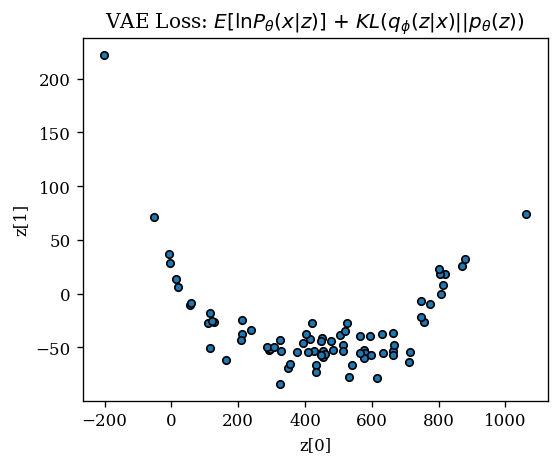

In [12]:
z_mean, z_std, z = model.model.encoder.predict(x_test, batch_size = batch_size)

fig = plt.figure(figsize=(5, 4))
plt.scatter(z[:, 0], z[:, 1], edgecolor="black", s = 20)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
if loss_index == 0:
    plt.title('VAE Loss: $E [\ln P_{\\theta}(x|z)]$ + $KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 1:
    plt.title('$\\beta$-VAE: $E [\ln P_{\\theta}(x|z)]$ + $\\beta KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 2:
    plt.title('ControlVAE: $E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 3:
    plt.title('infoVAE: ($E [\ln P_{\theta}(x|z)] + \\beta KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z_{t+1}, \\hat{z}_t)$ with stepwise $\\hat{z}$')
elif loss_index == 4:
    plt.title('GCVAE: ($1-\\alpha_t- \\beta_t)E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z,\\hat{z}_t)$ with stepwise $\\hat{z}$')


#### Latent space obtained contains entangled mixtures of Gaussians (digits)

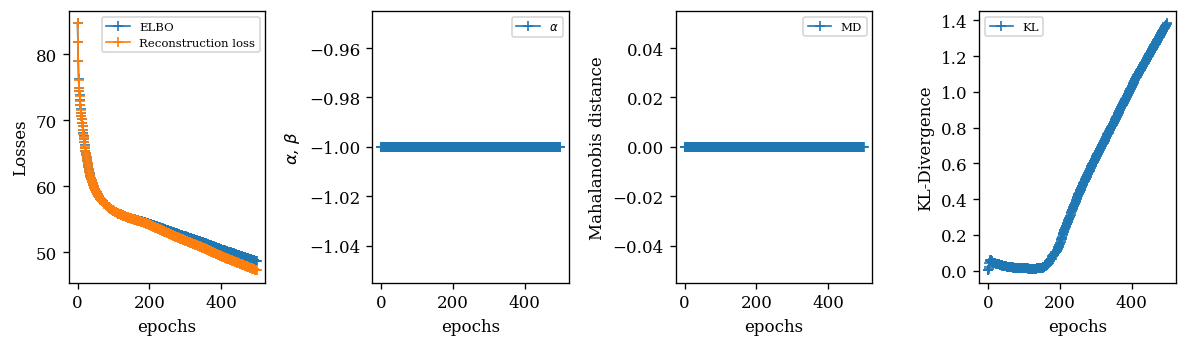

In [32]:
fs = 7
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].plot(np.arange(model.epoch), model.ELBO, label = 'ELBO', marker = '+', lw = 1.)
ax[0].plot(np.arange(model.epoch), model.RECON_LOSS, label = 'Reconstruction loss', marker = '+', lw = 1.)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Losses')
ax[1].plot(np.arange(model.epoch), model.ALPHA, label = '$\\alpha$', marker = '+', lw = 1.)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\\alpha$, $\\beta$')
ax[2].plot(np.arange(model.epoch), model.MMD, label = 'MD', marker = '+', lw = 1.)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Mahalanobis distance')
ax[3].plot(np.arange(model.epoch), model.KL_DIV, label = 'KL', marker = '+', lw = 1.)
ax[3].set_xlabel('epochs')
ax[3].set_ylabel('KL-Divergence')
ax[0].legend(prop={"size":fs})
ax[1].legend(prop={"size":fs})
ax[2].legend(prop={"size":fs})
ax[3].legend(prop={"size":fs})
plt.tight_layout()

/home/ifeanyi.ezukwoke/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


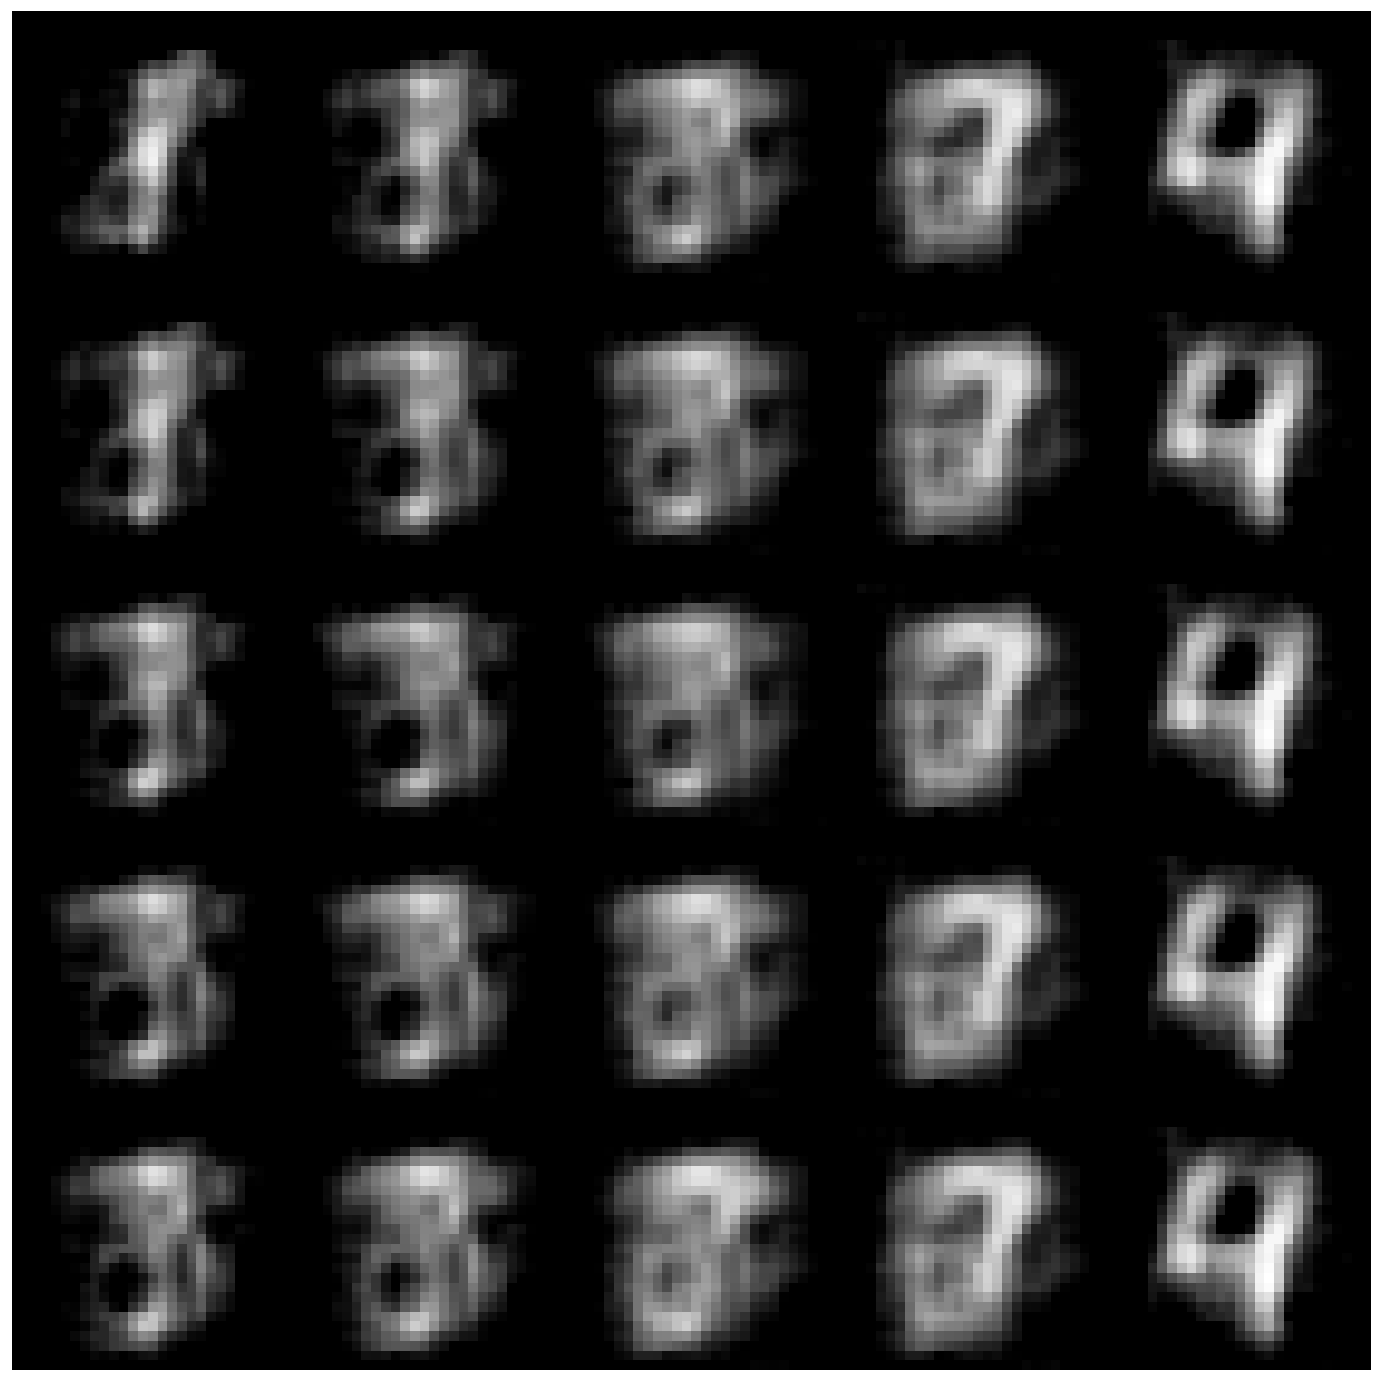

In [33]:
plot_latent_space(model.model, n= 5)

### GCVAE -- MMD

### 500 -iterations

In [34]:
loss_index = 4
# vae_type = 'gcvae' #else infovae
inp_shape =  x_train.shape[1:]
num_features = inp_shape[0]

#the parameters are only to change fixed weights
params = { #beta, gamma
            'elbo': (1, 0),
            'betavae': ((1, 5), 0),
            'controlvae': (0, 0),
            'infovae': (0, 500),
            'gcvae': (1, 1), #not necessarily useful inside algo
    }

lr = 1e-3
epochs = 500
hidden_dim = 100
latent_dims = 2
loss_type = list(params.keys())[loss_index] #elbo -> 0; beta-> 1; controlvae -> 2; infovae -> 3; gcvae -> 4
archi_type = 'v2'
#params
distrib_type = 'g'
beta, gamma = params[f'{loss_type}']
mmd_typ = 'mmd' #['mmd', 'mah', 'mah_rkhs', 'mah_gcvae']
save_model_arg = False
save_model_after = 10
model = gcvae(inp_shape = inp_shape,
                    num_features = num_features,
                    hidden_dim = hidden_dim,
                    latent_dim = latent_dims, 
                    batch_size = batch_size,
                    beta = beta,
                    gamma = gamma,
                    dist = distrib_type,
                    vloss = loss_type,
                    lr = lr, 
                    epochs = epochs,
                    architecture = archi_type,
                    mmd_type = mmd_typ).fit(train_dataset, x_test,
                                            datatype, stopping = False,
                                            save_model = save_model_arg,
                                            save_model_iter = save_model_after)

100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 1 - ELBO: 78.106 - RECON. LOSS: 87.517 - KL: 0.005 - alpha: 0.108 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 2 - ELBO: 75.268 - RECON. LOSS: 84.312 - KL: 0.012 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.014


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch 3 - ELBO: 72.686 - RECON. LOSS: 81.384 - KL: 0.022 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 4 - ELBO: 69.988 - RECON. LOSS: 78.333 - KL: 0.038 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


epoch 5 - ELBO: 68.070 - RECON. LOSS: 76.165 - KL: 0.065 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


epoch 6 - ELBO: 67.258 - RECON. LOSS: 75.246 - KL: 0.103 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


epoch 7 - ELBO: 66.841 - RECON. LOSS: 74.774 - KL: 0.126 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 8 - ELBO: 66.273 - RECON. LOSS: 74.122 - KL: 0.135 - alpha: 0.106 - beta: 0.000 - gamma: 1.049 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 9 - ELBO: 65.472 - RECON. LOSS: 73.215 - KL: 0.135 - alpha: 0.106 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 10 - ELBO: 64.737 - RECON. LOSS: 72.385 - KL: 0.131 - alpha: 0.106 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 11 - ELBO: 64.081 - RECON. LOSS: 71.647 - KL: 0.125 - alpha: 0.106 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 12 - ELBO: 63.766 - RECON. LOSS: 71.294 - KL: 0.119 - alpha: 0.106 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 13 - ELBO: 63.442 - RECON. LOSS: 70.932 - KL: 0.113 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 14 - ELBO: 63.017 - RECON. LOSS: 70.455 - KL: 0.108 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 15 - ELBO: 62.649 - RECON. LOSS: 70.041 - KL: 0.103 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 16 - ELBO: 62.248 - RECON. LOSS: 69.591 - KL: 0.098 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 17 - ELBO: 61.873 - RECON. LOSS: 69.170 - KL: 0.094 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 18 - ELBO: 61.668 - RECON. LOSS: 68.937 - KL: 0.090 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 19 - ELBO: 61.360 - RECON. LOSS: 68.591 - KL: 0.086 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 20 - ELBO: 61.056 - RECON. LOSS: 68.250 - KL: 0.083 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


epoch 21 - ELBO: 60.742 - RECON. LOSS: 67.897 - KL: 0.080 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 22 - ELBO: 60.449 - RECON. LOSS: 67.568 - KL: 0.077 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


epoch 23 - ELBO: 60.129 - RECON. LOSS: 67.207 - KL: 0.074 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 24 - ELBO: 59.852 - RECON. LOSS: 66.895 - KL: 0.072 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 25 - ELBO: 59.554 - RECON. LOSS: 66.559 - KL: 0.069 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 26 - ELBO: 59.252 - RECON. LOSS: 66.220 - KL: 0.067 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 27 - ELBO: 58.933 - RECON. LOSS: 65.862 - KL: 0.065 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch 28 - ELBO: 58.637 - RECON. LOSS: 65.528 - KL: 0.063 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 29 - ELBO: 58.391 - RECON. LOSS: 65.251 - KL: 0.062 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 30 - ELBO: 58.113 - RECON. LOSS: 64.940 - KL: 0.060 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 31 - ELBO: 57.878 - RECON. LOSS: 64.676 - KL: 0.059 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 32 - ELBO: 57.611 - RECON. LOSS: 64.376 - KL: 0.058 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 33 - ELBO: 57.389 - RECON. LOSS: 64.126 - KL: 0.057 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 34 - ELBO: 57.162 - RECON. LOSS: 63.871 - KL: 0.055 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 35 - ELBO: 56.944 - RECON. LOSS: 63.627 - KL: 0.054 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 36 - ELBO: 56.739 - RECON. LOSS: 63.397 - KL: 0.054 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 37 - ELBO: 56.549 - RECON. LOSS: 63.182 - KL: 0.053 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 38 - ELBO: 56.357 - RECON. LOSS: 62.967 - KL: 0.052 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 39 - ELBO: 56.183 - RECON. LOSS: 62.771 - KL: 0.051 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 40 - ELBO: 56.008 - RECON. LOSS: 62.574 - KL: 0.050 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 41 - ELBO: 55.845 - RECON. LOSS: 62.391 - KL: 0.050 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 42 - ELBO: 55.670 - RECON. LOSS: 62.194 - KL: 0.049 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 43 - ELBO: 55.501 - RECON. LOSS: 62.003 - KL: 0.048 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 44 - ELBO: 55.349 - RECON. LOSS: 61.833 - KL: 0.048 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 45 - ELBO: 55.185 - RECON. LOSS: 61.649 - KL: 0.047 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 46 - ELBO: 55.039 - RECON. LOSS: 61.484 - KL: 0.047 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 47 - ELBO: 54.902 - RECON. LOSS: 61.330 - KL: 0.046 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 48 - ELBO: 54.764 - RECON. LOSS: 61.176 - KL: 0.046 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 49 - ELBO: 54.629 - RECON. LOSS: 61.023 - KL: 0.045 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 50 - ELBO: 54.501 - RECON. LOSS: 60.879 - KL: 0.045 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 51 - ELBO: 54.374 - RECON. LOSS: 60.737 - KL: 0.044 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 52 - ELBO: 54.251 - RECON. LOSS: 60.599 - KL: 0.043 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 53 - ELBO: 54.134 - RECON. LOSS: 60.467 - KL: 0.043 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 54 - ELBO: 54.023 - RECON. LOSS: 60.342 - KL: 0.042 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 55 - ELBO: 53.912 - RECON. LOSS: 60.217 - KL: 0.042 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 56 - ELBO: 53.807 - RECON. LOSS: 60.100 - KL: 0.041 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 57 - ELBO: 53.705 - RECON. LOSS: 59.985 - KL: 0.041 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 58 - ELBO: 53.603 - RECON. LOSS: 59.870 - KL: 0.040 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 59 - ELBO: 53.503 - RECON. LOSS: 59.758 - KL: 0.040 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 60 - ELBO: 53.413 - RECON. LOSS: 59.657 - KL: 0.039 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 61 - ELBO: 53.322 - RECON. LOSS: 59.555 - KL: 0.039 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 62 - ELBO: 53.234 - RECON. LOSS: 59.456 - KL: 0.038 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 63 - ELBO: 53.149 - RECON. LOSS: 59.360 - KL: 0.038 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 64 - ELBO: 53.068 - RECON. LOSS: 59.269 - KL: 0.038 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 65 - ELBO: 52.989 - RECON. LOSS: 59.179 - KL: 0.037 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 66 - ELBO: 52.908 - RECON. LOSS: 59.090 - KL: 0.037 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 67 - ELBO: 52.833 - RECON. LOSS: 59.005 - KL: 0.036 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 68 - ELBO: 52.758 - RECON. LOSS: 58.920 - KL: 0.036 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 69 - ELBO: 52.689 - RECON. LOSS: 58.843 - KL: 0.035 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 70 - ELBO: 52.619 - RECON. LOSS: 58.765 - KL: 0.035 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 71 - ELBO: 52.549 - RECON. LOSS: 58.685 - KL: 0.035 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 72 - ELBO: 52.481 - RECON. LOSS: 58.609 - KL: 0.034 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 73 - ELBO: 52.416 - RECON. LOSS: 58.536 - KL: 0.034 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 74 - ELBO: 52.352 - RECON. LOSS: 58.464 - KL: 0.034 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 75 - ELBO: 52.292 - RECON. LOSS: 58.397 - KL: 0.033 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 76 - ELBO: 52.232 - RECON. LOSS: 58.329 - KL: 0.033 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 77 - ELBO: 52.171 - RECON. LOSS: 58.261 - KL: 0.033 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 78 - ELBO: 52.113 - RECON. LOSS: 58.195 - KL: 0.032 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 79 - ELBO: 52.054 - RECON. LOSS: 58.129 - KL: 0.032 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 80 - ELBO: 51.997 - RECON. LOSS: 58.066 - KL: 0.032 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 81 - ELBO: 51.943 - RECON. LOSS: 58.004 - KL: 0.031 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 82 - ELBO: 51.892 - RECON. LOSS: 57.947 - KL: 0.031 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 83 - ELBO: 51.839 - RECON. LOSS: 57.887 - KL: 0.031 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 84 - ELBO: 51.788 - RECON. LOSS: 57.830 - KL: 0.031 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 85 - ELBO: 51.738 - RECON. LOSS: 57.774 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 86 - ELBO: 51.691 - RECON. LOSS: 57.721 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 87 - ELBO: 51.644 - RECON. LOSS: 57.668 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 88 - ELBO: 51.597 - RECON. LOSS: 57.616 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 89 - ELBO: 51.552 - RECON. LOSS: 57.564 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 90 - ELBO: 51.507 - RECON. LOSS: 57.513 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 91 - ELBO: 51.461 - RECON. LOSS: 57.462 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 92 - ELBO: 51.416 - RECON. LOSS: 57.412 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 93 - ELBO: 51.374 - RECON. LOSS: 57.365 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 94 - ELBO: 51.331 - RECON. LOSS: 57.317 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 95 - ELBO: 51.291 - RECON. LOSS: 57.271 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 96 - ELBO: 51.248 - RECON. LOSS: 57.224 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 97 - ELBO: 51.206 - RECON. LOSS: 57.176 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 98 - ELBO: 51.167 - RECON. LOSS: 57.132 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 99 - ELBO: 51.132 - RECON. LOSS: 57.092 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 100 - ELBO: 51.089 - RECON. LOSS: 57.044 - KL: 0.029 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 101 - ELBO: 51.052 - RECON. LOSS: 57.003 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 102 - ELBO: 51.013 - RECON. LOSS: 56.959 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 103 - ELBO: 50.978 - RECON. LOSS: 56.919 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 104 - ELBO: 50.942 - RECON. LOSS: 56.879 - KL: 0.031 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 105 - ELBO: 50.906 - RECON. LOSS: 56.838 - KL: 0.031 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 106 - ELBO: 50.869 - RECON. LOSS: 56.797 - KL: 0.032 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 107 - ELBO: 50.835 - RECON. LOSS: 56.759 - KL: 0.033 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 108 - ELBO: 50.797 - RECON. LOSS: 56.715 - KL: 0.034 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 109 - ELBO: 50.759 - RECON. LOSS: 56.673 - KL: 0.035 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 110 - ELBO: 50.725 - RECON. LOSS: 56.634 - KL: 0.036 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 111 - ELBO: 50.692 - RECON. LOSS: 56.598 - KL: 0.037 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 112 - ELBO: 50.656 - RECON. LOSS: 56.557 - KL: 0.039 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 113 - ELBO: 50.620 - RECON. LOSS: 56.516 - KL: 0.041 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 114 - ELBO: 50.584 - RECON. LOSS: 56.476 - KL: 0.043 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 115 - ELBO: 50.550 - RECON. LOSS: 56.438 - KL: 0.046 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 116 - ELBO: 50.515 - RECON. LOSS: 56.398 - KL: 0.050 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

epoch 117 - ELBO: 50.482 - RECON. LOSS: 56.360 - KL: 0.054 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022



100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 118 - ELBO: 50.450 - RECON. LOSS: 56.324 - KL: 0.059 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 119 - ELBO: 50.410 - RECON. LOSS: 56.280 - KL: 0.064 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 120 - ELBO: 50.370 - RECON. LOSS: 56.235 - KL: 0.070 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 121 - ELBO: 50.339 - RECON. LOSS: 56.200 - KL: 0.079 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 122 - ELBO: 50.305 - RECON. LOSS: 56.161 - KL: 0.086 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 123 - ELBO: 50.273 - RECON. LOSS: 56.125 - KL: 0.094 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 124 - ELBO: 50.239 - RECON. LOSS: 56.087 - KL: 0.104 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 125 - ELBO: 50.213 - RECON. LOSS: 56.058 - KL: 0.116 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 126 - ELBO: 50.179 - RECON. LOSS: 56.019 - KL: 0.125 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 127 - ELBO: 50.149 - RECON. LOSS: 55.984 - KL: 0.135 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 128 - ELBO: 50.111 - RECON. LOSS: 55.941 - KL: 0.145 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 129 - ELBO: 50.080 - RECON. LOSS: 55.906 - KL: 0.157 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 130 - ELBO: 50.049 - RECON. LOSS: 55.871 - KL: 0.170 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 131 - ELBO: 50.012 - RECON. LOSS: 55.829 - KL: 0.181 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 132 - ELBO: 49.985 - RECON. LOSS: 55.798 - KL: 0.193 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 133 - ELBO: 49.955 - RECON. LOSS: 55.764 - KL: 0.204 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 134 - ELBO: 49.913 - RECON. LOSS: 55.717 - KL: 0.216 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 135 - ELBO: 49.879 - RECON. LOSS: 55.679 - KL: 0.228 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 136 - ELBO: 49.837 - RECON. LOSS: 55.632 - KL: 0.241 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 137 - ELBO: 49.792 - RECON. LOSS: 55.580 - KL: 0.257 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 138 - ELBO: 49.759 - RECON. LOSS: 55.543 - KL: 0.273 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 139 - ELBO: 49.716 - RECON. LOSS: 55.495 - KL: 0.290 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 140 - ELBO: 49.672 - RECON. LOSS: 55.444 - KL: 0.308 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 141 - ELBO: 49.627 - RECON. LOSS: 55.393 - KL: 0.328 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 142 - ELBO: 49.581 - RECON. LOSS: 55.341 - KL: 0.350 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 143 - ELBO: 49.535 - RECON. LOSS: 55.289 - KL: 0.374 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.027


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 144 - ELBO: 49.489 - RECON. LOSS: 55.238 - KL: 0.399 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 145 - ELBO: 49.444 - RECON. LOSS: 55.186 - KL: 0.425 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 146 - ELBO: 49.398 - RECON. LOSS: 55.135 - KL: 0.454 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 147 - ELBO: 49.351 - RECON. LOSS: 55.083 - KL: 0.485 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 148 - ELBO: 49.304 - RECON. LOSS: 55.029 - KL: 0.518 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 149 - ELBO: 49.257 - RECON. LOSS: 54.976 - KL: 0.553 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 150 - ELBO: 49.209 - RECON. LOSS: 54.922 - KL: 0.590 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 151 - ELBO: 49.161 - RECON. LOSS: 54.868 - KL: 0.629 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 152 - ELBO: 49.114 - RECON. LOSS: 54.815 - KL: 0.668 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 153 - ELBO: 49.066 - RECON. LOSS: 54.761 - KL: 0.708 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 154 - ELBO: 49.019 - RECON. LOSS: 54.708 - KL: 0.750 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 155 - ELBO: 48.971 - RECON. LOSS: 54.654 - KL: 0.793 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 156 - ELBO: 48.924 - RECON. LOSS: 54.601 - KL: 0.837 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 157 - ELBO: 48.876 - RECON. LOSS: 54.547 - KL: 0.882 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 158 - ELBO: 48.829 - RECON. LOSS: 54.494 - KL: 0.928 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 159 - ELBO: 48.781 - RECON. LOSS: 54.440 - KL: 0.975 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 160 - ELBO: 48.734 - RECON. LOSS: 54.387 - KL: 1.023 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 161 - ELBO: 48.687 - RECON. LOSS: 54.334 - KL: 1.071 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 162 - ELBO: 48.640 - RECON. LOSS: 54.282 - KL: 1.120 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 163 - ELBO: 48.593 - RECON. LOSS: 54.229 - KL: 1.169 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 164 - ELBO: 48.546 - RECON. LOSS: 54.175 - KL: 1.219 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 165 - ELBO: 48.499 - RECON. LOSS: 54.122 - KL: 1.269 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 166 - ELBO: 48.452 - RECON. LOSS: 54.069 - KL: 1.320 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 167 - ELBO: 48.405 - RECON. LOSS: 54.016 - KL: 1.371 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 168 - ELBO: 48.358 - RECON. LOSS: 53.963 - KL: 1.421 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 169 - ELBO: 48.311 - RECON. LOSS: 53.911 - KL: 1.473 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 170 - ELBO: 48.265 - RECON. LOSS: 53.858 - KL: 1.524 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 171 - ELBO: 48.217 - RECON. LOSS: 53.805 - KL: 1.575 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 172 - ELBO: 48.170 - RECON. LOSS: 53.751 - KL: 1.626 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 173 - ELBO: 48.122 - RECON. LOSS: 53.698 - KL: 1.677 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 174 - ELBO: 48.075 - RECON. LOSS: 53.645 - KL: 1.729 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 175 - ELBO: 48.028 - RECON. LOSS: 53.592 - KL: 1.779 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 176 - ELBO: 47.982 - RECON. LOSS: 53.540 - KL: 1.831 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 177 - ELBO: 47.936 - RECON. LOSS: 53.488 - KL: 1.881 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 178 - ELBO: 47.893 - RECON. LOSS: 53.440 - KL: 1.932 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 179 - ELBO: 47.848 - RECON. LOSS: 53.389 - KL: 1.982 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.032


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 180 - ELBO: 47.800 - RECON. LOSS: 53.335 - KL: 2.032 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 181 - ELBO: 47.753 - RECON. LOSS: 53.282 - KL: 2.082 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 182 - ELBO: 47.707 - RECON. LOSS: 53.230 - KL: 2.130 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 183 - ELBO: 47.661 - RECON. LOSS: 53.179 - KL: 2.179 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 184 - ELBO: 47.614 - RECON. LOSS: 53.125 - KL: 2.227 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 185 - ELBO: 47.567 - RECON. LOSS: 53.073 - KL: 2.275 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 186 - ELBO: 47.523 - RECON. LOSS: 53.023 - KL: 2.324 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 187 - ELBO: 47.478 - RECON. LOSS: 52.973 - KL: 2.370 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 188 - ELBO: 47.431 - RECON. LOSS: 52.919 - KL: 2.418 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 189 - ELBO: 47.383 - RECON. LOSS: 52.865 - KL: 2.466 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 190 - ELBO: 47.336 - RECON. LOSS: 52.813 - KL: 2.512 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 191 - ELBO: 47.293 - RECON. LOSS: 52.764 - KL: 2.559 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


epoch 192 - ELBO: 47.245 - RECON. LOSS: 52.710 - KL: 2.605 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


epoch 193 - ELBO: 47.198 - RECON. LOSS: 52.658 - KL: 2.652 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 194 - ELBO: 47.154 - RECON. LOSS: 52.607 - KL: 2.699 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 195 - ELBO: 47.109 - RECON. LOSS: 52.557 - KL: 2.744 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch 196 - ELBO: 47.060 - RECON. LOSS: 52.502 - KL: 2.790 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 197 - ELBO: 47.013 - RECON. LOSS: 52.449 - KL: 2.836 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 198 - ELBO: 46.970 - RECON. LOSS: 52.400 - KL: 2.881 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 199 - ELBO: 46.932 - RECON. LOSS: 52.358 - KL: 2.927 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 200 - ELBO: 46.884 - RECON. LOSS: 52.303 - KL: 2.972 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 201 - ELBO: 46.845 - RECON. LOSS: 52.260 - KL: 3.017 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 202 - ELBO: 46.809 - RECON. LOSS: 52.219 - KL: 3.063 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 203 - ELBO: 46.765 - RECON. LOSS: 52.169 - KL: 3.107 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 204 - ELBO: 46.729 - RECON. LOSS: 52.129 - KL: 3.150 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


epoch 205 - ELBO: 46.684 - RECON. LOSS: 52.078 - KL: 3.193 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch 206 - ELBO: 46.644 - RECON. LOSS: 52.033 - KL: 3.236 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 207 - ELBO: 46.601 - RECON. LOSS: 51.985 - KL: 3.278 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 208 - ELBO: 46.557 - RECON. LOSS: 51.935 - KL: 3.318 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 209 - ELBO: 46.515 - RECON. LOSS: 51.888 - KL: 3.359 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


epoch 210 - ELBO: 46.468 - RECON. LOSS: 51.835 - KL: 3.399 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.036


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 211 - ELBO: 46.425 - RECON. LOSS: 51.787 - KL: 3.440 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 212 - ELBO: 46.378 - RECON. LOSS: 51.734 - KL: 3.481 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 213 - ELBO: 46.334 - RECON. LOSS: 51.685 - KL: 3.520 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch 214 - ELBO: 46.288 - RECON. LOSS: 51.633 - KL: 3.559 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 215 - ELBO: 46.242 - RECON. LOSS: 51.581 - KL: 3.598 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 216 - ELBO: 46.196 - RECON. LOSS: 51.529 - KL: 3.638 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 217 - ELBO: 46.149 - RECON. LOSS: 51.476 - KL: 3.678 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 218 - ELBO: 46.104 - RECON. LOSS: 51.425 - KL: 3.717 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 219 - ELBO: 46.056 - RECON. LOSS: 51.371 - KL: 3.757 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


epoch 220 - ELBO: 46.009 - RECON. LOSS: 51.319 - KL: 3.797 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 221 - ELBO: 45.962 - RECON. LOSS: 51.265 - KL: 3.838 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


epoch 222 - ELBO: 45.915 - RECON. LOSS: 51.212 - KL: 3.879 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


epoch 223 - ELBO: 45.867 - RECON. LOSS: 51.158 - KL: 3.919 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch 224 - ELBO: 45.818 - RECON. LOSS: 51.104 - KL: 3.960 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 225 - ELBO: 45.770 - RECON. LOSS: 51.050 - KL: 4.001 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 226 - ELBO: 45.722 - RECON. LOSS: 50.996 - KL: 4.042 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 227 - ELBO: 45.674 - RECON. LOSS: 50.941 - KL: 4.083 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 228 - ELBO: 45.625 - RECON. LOSS: 50.886 - KL: 4.125 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch 229 - ELBO: 45.576 - RECON. LOSS: 50.832 - KL: 4.166 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


epoch 230 - ELBO: 45.528 - RECON. LOSS: 50.778 - KL: 4.208 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 231 - ELBO: 45.480 - RECON. LOSS: 50.724 - KL: 4.250 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 232 - ELBO: 45.432 - RECON. LOSS: 50.670 - KL: 4.292 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 233 - ELBO: 45.383 - RECON. LOSS: 50.615 - KL: 4.334 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 234 - ELBO: 45.334 - RECON. LOSS: 50.559 - KL: 4.376 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


epoch 235 - ELBO: 45.286 - RECON. LOSS: 50.505 - KL: 4.419 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 236 - ELBO: 45.238 - RECON. LOSS: 50.451 - KL: 4.461 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 237 - ELBO: 45.188 - RECON. LOSS: 50.396 - KL: 4.504 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 238 - ELBO: 45.139 - RECON. LOSS: 50.340 - KL: 4.547 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 239 - ELBO: 45.090 - RECON. LOSS: 50.285 - KL: 4.589 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


epoch 240 - ELBO: 45.042 - RECON. LOSS: 50.232 - KL: 4.632 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 241 - ELBO: 44.995 - RECON. LOSS: 50.178 - KL: 4.675 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 242 - ELBO: 44.945 - RECON. LOSS: 50.122 - KL: 4.717 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 243 - ELBO: 44.896 - RECON. LOSS: 50.068 - KL: 4.760 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 244 - ELBO: 44.849 - RECON. LOSS: 50.015 - KL: 4.802 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 245 - ELBO: 44.802 - RECON. LOSS: 49.961 - KL: 4.845 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 246 - ELBO: 44.751 - RECON. LOSS: 49.905 - KL: 4.887 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 247 - ELBO: 44.703 - RECON. LOSS: 49.850 - KL: 4.930 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 248 - ELBO: 44.655 - RECON. LOSS: 49.796 - KL: 4.973 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 249 - ELBO: 44.608 - RECON. LOSS: 49.743 - KL: 5.015 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


epoch 250 - ELBO: 44.557 - RECON. LOSS: 49.686 - KL: 5.058 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 251 - ELBO: 44.510 - RECON. LOSS: 49.633 - KL: 5.101 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 252 - ELBO: 44.465 - RECON. LOSS: 49.582 - KL: 5.143 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 253 - ELBO: 44.418 - RECON. LOSS: 49.529 - KL: 5.185 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 254 - ELBO: 44.369 - RECON. LOSS: 49.474 - KL: 5.228 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


epoch 255 - ELBO: 44.325 - RECON. LOSS: 49.424 - KL: 5.270 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 256 - ELBO: 44.277 - RECON. LOSS: 49.371 - KL: 5.313 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


epoch 257 - ELBO: 44.230 - RECON. LOSS: 49.317 - KL: 5.355 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


epoch 258 - ELBO: 44.182 - RECON. LOSS: 49.264 - KL: 5.397 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 259 - ELBO: 44.134 - RECON. LOSS: 49.209 - KL: 5.439 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 260 - ELBO: 44.086 - RECON. LOSS: 49.156 - KL: 5.482 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 261 - ELBO: 44.039 - RECON. LOSS: 49.103 - KL: 5.524 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 262 - ELBO: 43.989 - RECON. LOSS: 49.047 - KL: 5.565 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 263 - ELBO: 43.944 - RECON. LOSS: 48.995 - KL: 5.607 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


epoch 264 - ELBO: 43.894 - RECON. LOSS: 48.939 - KL: 5.648 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 265 - ELBO: 43.845 - RECON. LOSS: 48.885 - KL: 5.689 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 266 - ELBO: 43.796 - RECON. LOSS: 48.830 - KL: 5.730 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.045


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 267 - ELBO: 43.747 - RECON. LOSS: 48.774 - KL: 5.771 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.045


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 268 - ELBO: 43.699 - RECON. LOSS: 48.720 - KL: 5.812 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.045


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 269 - ELBO: 43.649 - RECON. LOSS: 48.664 - KL: 5.852 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.045


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 270 - ELBO: 43.601 - RECON. LOSS: 48.609 - KL: 5.893 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 271 - ELBO: 43.552 - RECON. LOSS: 48.554 - KL: 5.933 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 272 - ELBO: 43.502 - RECON. LOSS: 48.499 - KL: 5.974 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 273 - ELBO: 43.453 - RECON. LOSS: 48.443 - KL: 6.014 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 274 - ELBO: 43.403 - RECON. LOSS: 48.387 - KL: 6.055 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 275 - ELBO: 43.353 - RECON. LOSS: 48.331 - KL: 6.095 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 276 - ELBO: 43.304 - RECON. LOSS: 48.276 - KL: 6.135 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 277 - ELBO: 43.255 - RECON. LOSS: 48.220 - KL: 6.175 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 278 - ELBO: 43.206 - RECON. LOSS: 48.165 - KL: 6.215 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 279 - ELBO: 43.159 - RECON. LOSS: 48.112 - KL: 6.256 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 280 - ELBO: 43.115 - RECON. LOSS: 48.062 - KL: 6.296 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.048


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 281 - ELBO: 43.074 - RECON. LOSS: 48.016 - KL: 6.336 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.048


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 282 - ELBO: 43.036 - RECON. LOSS: 47.973 - KL: 6.376 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.048


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 283 - ELBO: 42.990 - RECON. LOSS: 47.921 - KL: 6.415 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.048


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 284 - ELBO: 42.943 - RECON. LOSS: 47.868 - KL: 6.455 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.048


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 285 - ELBO: 42.903 - RECON. LOSS: 47.824 - KL: 6.494 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 286 - ELBO: 42.858 - RECON. LOSS: 47.773 - KL: 6.532 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 287 - ELBO: 42.810 - RECON. LOSS: 47.720 - KL: 6.571 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 288 - ELBO: 42.770 - RECON. LOSS: 47.674 - KL: 6.609 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 289 - ELBO: 42.722 - RECON. LOSS: 47.620 - KL: 6.647 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 290 - ELBO: 42.678 - RECON. LOSS: 47.570 - KL: 6.685 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 291 - ELBO: 42.633 - RECON. LOSS: 47.520 - KL: 6.723 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 292 - ELBO: 42.586 - RECON. LOSS: 47.467 - KL: 6.760 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 293 - ELBO: 42.542 - RECON. LOSS: 47.418 - KL: 6.797 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 294 - ELBO: 42.497 - RECON. LOSS: 47.367 - KL: 6.834 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 295 - ELBO: 42.451 - RECON. LOSS: 47.315 - KL: 6.871 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


epoch 296 - ELBO: 42.408 - RECON. LOSS: 47.266 - KL: 6.908 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 297 - ELBO: 42.360 - RECON. LOSS: 47.213 - KL: 6.945 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 298 - ELBO: 42.315 - RECON. LOSS: 47.162 - KL: 6.982 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 299 - ELBO: 42.269 - RECON. LOSS: 47.109 - KL: 7.018 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 300 - ELBO: 42.221 - RECON. LOSS: 47.056 - KL: 7.055 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 301 - ELBO: 42.176 - RECON. LOSS: 47.005 - KL: 7.091 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 302 - ELBO: 42.130 - RECON. LOSS: 46.954 - KL: 7.128 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 303 - ELBO: 42.083 - RECON. LOSS: 46.900 - KL: 7.164 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 304 - ELBO: 42.038 - RECON. LOSS: 46.849 - KL: 7.200 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 305 - ELBO: 41.991 - RECON. LOSS: 46.797 - KL: 7.236 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 306 - ELBO: 41.944 - RECON. LOSS: 46.745 - KL: 7.272 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 307 - ELBO: 41.899 - RECON. LOSS: 46.693 - KL: 7.308 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 308 - ELBO: 41.852 - RECON. LOSS: 46.641 - KL: 7.344 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 309 - ELBO: 41.806 - RECON. LOSS: 46.589 - KL: 7.380 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 310 - ELBO: 41.760 - RECON. LOSS: 46.537 - KL: 7.415 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.054


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 311 - ELBO: 41.713 - RECON. LOSS: 46.485 - KL: 7.451 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.054


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 312 - ELBO: 41.666 - RECON. LOSS: 46.431 - KL: 7.487 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.054


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 313 - ELBO: 41.619 - RECON. LOSS: 46.379 - KL: 7.522 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.054


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 314 - ELBO: 41.573 - RECON. LOSS: 46.327 - KL: 7.557 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 315 - ELBO: 41.526 - RECON. LOSS: 46.274 - KL: 7.593 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 316 - ELBO: 41.480 - RECON. LOSS: 46.222 - KL: 7.628 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 317 - ELBO: 41.435 - RECON. LOSS: 46.171 - KL: 7.664 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 318 - ELBO: 41.393 - RECON. LOSS: 46.124 - KL: 7.698 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 319 - ELBO: 41.352 - RECON. LOSS: 46.078 - KL: 7.734 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 320 - ELBO: 41.308 - RECON. LOSS: 46.028 - KL: 7.769 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 321 - ELBO: 41.262 - RECON. LOSS: 45.977 - KL: 7.804 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


epoch 322 - ELBO: 41.217 - RECON. LOSS: 45.925 - KL: 7.838 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 323 - ELBO: 41.175 - RECON. LOSS: 45.878 - KL: 7.872 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 324 - ELBO: 41.132 - RECON. LOSS: 45.830 - KL: 7.907 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 325 - ELBO: 41.086 - RECON. LOSS: 45.778 - KL: 7.941 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 326 - ELBO: 41.041 - RECON. LOSS: 45.727 - KL: 7.975 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 327 - ELBO: 40.997 - RECON. LOSS: 45.678 - KL: 8.009 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 328 - ELBO: 40.954 - RECON. LOSS: 45.629 - KL: 8.043 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


epoch 329 - ELBO: 40.908 - RECON. LOSS: 45.578 - KL: 8.077 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 330 - ELBO: 40.863 - RECON. LOSS: 45.526 - KL: 8.110 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 331 - ELBO: 40.819 - RECON. LOSS: 45.477 - KL: 8.144 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 332 - ELBO: 40.774 - RECON. LOSS: 45.427 - KL: 8.177 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 333 - ELBO: 40.729 - RECON. LOSS: 45.376 - KL: 8.210 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 334 - ELBO: 40.683 - RECON. LOSS: 45.325 - KL: 8.243 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 335 - ELBO: 40.639 - RECON. LOSS: 45.275 - KL: 8.277 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 336 - ELBO: 40.598 - RECON. LOSS: 45.228 - KL: 8.309 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 337 - ELBO: 40.553 - RECON. LOSS: 45.178 - KL: 8.342 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 338 - ELBO: 40.511 - RECON. LOSS: 45.131 - KL: 8.375 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 339 - ELBO: 40.473 - RECON. LOSS: 45.088 - KL: 8.407 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 340 - ELBO: 40.434 - RECON. LOSS: 45.044 - KL: 8.440 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 341 - ELBO: 40.392 - RECON. LOSS: 44.996 - KL: 8.472 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 342 - ELBO: 40.347 - RECON. LOSS: 44.946 - KL: 8.504 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 343 - ELBO: 40.304 - RECON. LOSS: 44.897 - KL: 8.535 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


epoch 344 - ELBO: 40.261 - RECON. LOSS: 44.850 - KL: 8.567 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 345 - ELBO: 40.219 - RECON. LOSS: 44.801 - KL: 8.599 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 346 - ELBO: 40.175 - RECON. LOSS: 44.752 - KL: 8.630 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 347 - ELBO: 40.131 - RECON. LOSS: 44.702 - KL: 8.661 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


epoch 348 - ELBO: 40.087 - RECON. LOSS: 44.653 - KL: 8.692 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


epoch 349 - ELBO: 40.044 - RECON. LOSS: 44.605 - KL: 8.723 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 350 - ELBO: 40.002 - RECON. LOSS: 44.558 - KL: 8.754 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 351 - ELBO: 39.960 - RECON. LOSS: 44.510 - KL: 8.786 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 352 - ELBO: 39.917 - RECON. LOSS: 44.462 - KL: 8.816 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


epoch 353 - ELBO: 39.873 - RECON. LOSS: 44.412 - KL: 8.847 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 354 - ELBO: 39.830 - RECON. LOSS: 44.363 - KL: 8.878 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 355 - ELBO: 39.788 - RECON. LOSS: 44.316 - KL: 8.908 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 356 - ELBO: 39.745 - RECON. LOSS: 44.268 - KL: 8.939 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 357 - ELBO: 39.702 - RECON. LOSS: 44.219 - KL: 8.970 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


epoch 358 - ELBO: 39.659 - RECON. LOSS: 44.171 - KL: 9.000 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 359 - ELBO: 39.617 - RECON. LOSS: 44.123 - KL: 9.030 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 360 - ELBO: 39.574 - RECON. LOSS: 44.076 - KL: 9.060 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 361 - ELBO: 39.531 - RECON. LOSS: 44.027 - KL: 9.091 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 362 - ELBO: 39.488 - RECON. LOSS: 43.978 - KL: 9.121 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


epoch 363 - ELBO: 39.445 - RECON. LOSS: 43.930 - KL: 9.150 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 364 - ELBO: 39.402 - RECON. LOSS: 43.881 - KL: 9.180 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 365 - ELBO: 39.360 - RECON. LOSS: 43.833 - KL: 9.210 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 366 - ELBO: 39.318 - RECON. LOSS: 43.787 - KL: 9.240 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 367 - ELBO: 39.279 - RECON. LOSS: 43.743 - KL: 9.270 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 368 - ELBO: 39.248 - RECON. LOSS: 43.708 - KL: 9.299 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 369 - ELBO: 39.215 - RECON. LOSS: 43.671 - KL: 9.328 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 370 - ELBO: 39.182 - RECON. LOSS: 43.633 - KL: 9.357 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 371 - ELBO: 39.142 - RECON. LOSS: 43.588 - KL: 9.386 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 372 - ELBO: 39.103 - RECON. LOSS: 43.543 - KL: 9.415 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 373 - ELBO: 39.067 - RECON. LOSS: 43.503 - KL: 9.443 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 374 - ELBO: 39.028 - RECON. LOSS: 43.459 - KL: 9.471 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 375 - ELBO: 38.987 - RECON. LOSS: 43.413 - KL: 9.500 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 376 - ELBO: 38.950 - RECON. LOSS: 43.371 - KL: 9.527 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 377 - ELBO: 38.909 - RECON. LOSS: 43.325 - KL: 9.555 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 378 - ELBO: 38.869 - RECON. LOSS: 43.280 - KL: 9.583 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 379 - ELBO: 38.831 - RECON. LOSS: 43.237 - KL: 9.610 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 380 - ELBO: 38.790 - RECON. LOSS: 43.191 - KL: 9.637 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 381 - ELBO: 38.750 - RECON. LOSS: 43.146 - KL: 9.664 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 382 - ELBO: 38.712 - RECON. LOSS: 43.103 - KL: 9.691 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 383 - ELBO: 38.672 - RECON. LOSS: 43.058 - KL: 9.718 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 384 - ELBO: 38.631 - RECON. LOSS: 43.011 - KL: 9.745 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 385 - ELBO: 38.592 - RECON. LOSS: 42.968 - KL: 9.771 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 386 - ELBO: 38.552 - RECON. LOSS: 42.923 - KL: 9.798 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 387 - ELBO: 38.511 - RECON. LOSS: 42.877 - KL: 9.825 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 388 - ELBO: 38.470 - RECON. LOSS: 42.831 - KL: 9.851 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 389 - ELBO: 38.430 - RECON. LOSS: 42.785 - KL: 9.878 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 390 - ELBO: 38.391 - RECON. LOSS: 42.741 - KL: 9.904 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 391 - ELBO: 38.349 - RECON. LOSS: 42.695 - KL: 9.930 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 392 - ELBO: 38.308 - RECON. LOSS: 42.649 - KL: 9.957 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 393 - ELBO: 38.268 - RECON. LOSS: 42.603 - KL: 9.983 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 394 - ELBO: 38.227 - RECON. LOSS: 42.557 - KL: 10.009 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 395 - ELBO: 38.187 - RECON. LOSS: 42.512 - KL: 10.035 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 396 - ELBO: 38.146 - RECON. LOSS: 42.466 - KL: 10.061 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 397 - ELBO: 38.105 - RECON. LOSS: 42.420 - KL: 10.087 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 398 - ELBO: 38.065 - RECON. LOSS: 42.375 - KL: 10.113 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 399 - ELBO: 38.026 - RECON. LOSS: 42.330 - KL: 10.139 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 400 - ELBO: 37.989 - RECON. LOSS: 42.288 - KL: 10.165 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 401 - ELBO: 37.952 - RECON. LOSS: 42.247 - KL: 10.191 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 402 - ELBO: 37.917 - RECON. LOSS: 42.208 - KL: 10.217 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 403 - ELBO: 37.883 - RECON. LOSS: 42.169 - KL: 10.242 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 404 - ELBO: 37.843 - RECON. LOSS: 42.125 - KL: 10.268 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 405 - ELBO: 37.804 - RECON. LOSS: 42.081 - KL: 10.294 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 406 - ELBO: 37.768 - RECON. LOSS: 42.040 - KL: 10.319 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 407 - ELBO: 37.729 - RECON. LOSS: 41.996 - KL: 10.344 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 408 - ELBO: 37.691 - RECON. LOSS: 41.953 - KL: 10.369 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 409 - ELBO: 37.656 - RECON. LOSS: 41.914 - KL: 10.394 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 410 - ELBO: 37.618 - RECON. LOSS: 41.870 - KL: 10.419 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 411 - ELBO: 37.583 - RECON. LOSS: 41.831 - KL: 10.444 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 412 - ELBO: 37.551 - RECON. LOSS: 41.794 - KL: 10.469 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 413 - ELBO: 37.513 - RECON. LOSS: 41.752 - KL: 10.493 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 414 - ELBO: 37.483 - RECON. LOSS: 41.718 - KL: 10.518 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 415 - ELBO: 37.448 - RECON. LOSS: 41.679 - KL: 10.542 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 416 - ELBO: 37.415 - RECON. LOSS: 41.642 - KL: 10.566 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 417 - ELBO: 37.379 - RECON. LOSS: 41.601 - KL: 10.590 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 418 - ELBO: 37.343 - RECON. LOSS: 41.561 - KL: 10.614 - alpha: 0.103 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 419 - ELBO: 37.308 - RECON. LOSS: 41.521 - KL: 10.637 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 420 - ELBO: 37.273 - RECON. LOSS: 41.481 - KL: 10.660 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 421 - ELBO: 37.237 - RECON. LOSS: 41.441 - KL: 10.684 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 422 - ELBO: 37.201 - RECON. LOSS: 41.401 - KL: 10.707 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 423 - ELBO: 37.167 - RECON. LOSS: 41.362 - KL: 10.730 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 424 - ELBO: 37.132 - RECON. LOSS: 41.322 - KL: 10.752 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 425 - ELBO: 37.096 - RECON. LOSS: 41.282 - KL: 10.775 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 426 - ELBO: 37.060 - RECON. LOSS: 41.241 - KL: 10.797 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 427 - ELBO: 37.023 - RECON. LOSS: 41.200 - KL: 10.819 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 428 - ELBO: 36.985 - RECON. LOSS: 41.157 - KL: 10.842 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 429 - ELBO: 36.948 - RECON. LOSS: 41.115 - KL: 10.864 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 430 - ELBO: 36.911 - RECON. LOSS: 41.074 - KL: 10.886 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 431 - ELBO: 36.874 - RECON. LOSS: 41.032 - KL: 10.908 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 432 - ELBO: 36.837 - RECON. LOSS: 40.990 - KL: 10.930 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 433 - ELBO: 36.800 - RECON. LOSS: 40.949 - KL: 10.952 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 434 - ELBO: 36.763 - RECON. LOSS: 40.907 - KL: 10.974 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 435 - ELBO: 36.726 - RECON. LOSS: 40.866 - KL: 10.996 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 436 - ELBO: 36.689 - RECON. LOSS: 40.823 - KL: 11.018 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 437 - ELBO: 36.651 - RECON. LOSS: 40.781 - KL: 11.040 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 438 - ELBO: 36.614 - RECON. LOSS: 40.739 - KL: 11.062 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 439 - ELBO: 36.577 - RECON. LOSS: 40.697 - KL: 11.084 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 440 - ELBO: 36.539 - RECON. LOSS: 40.655 - KL: 11.106 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 441 - ELBO: 36.502 - RECON. LOSS: 40.614 - KL: 11.127 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 442 - ELBO: 36.466 - RECON. LOSS: 40.573 - KL: 11.149 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 443 - ELBO: 36.432 - RECON. LOSS: 40.534 - KL: 11.171 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 444 - ELBO: 36.399 - RECON. LOSS: 40.497 - KL: 11.193 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 445 - ELBO: 36.372 - RECON. LOSS: 40.466 - KL: 11.214 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 446 - ELBO: 36.344 - RECON. LOSS: 40.435 - KL: 11.236 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 447 - ELBO: 36.313 - RECON. LOSS: 40.400 - KL: 11.258 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 448 - ELBO: 36.277 - RECON. LOSS: 40.359 - KL: 11.279 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 449 - ELBO: 36.242 - RECON. LOSS: 40.320 - KL: 11.301 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 450 - ELBO: 36.211 - RECON. LOSS: 40.285 - KL: 11.321 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 451 - ELBO: 36.177 - RECON. LOSS: 40.246 - KL: 11.343 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 452 - ELBO: 36.140 - RECON. LOSS: 40.205 - KL: 11.364 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 453 - ELBO: 36.107 - RECON. LOSS: 40.168 - KL: 11.385 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 454 - ELBO: 36.073 - RECON. LOSS: 40.129 - KL: 11.406 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 455 - ELBO: 36.036 - RECON. LOSS: 40.088 - KL: 11.427 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 456 - ELBO: 36.001 - RECON. LOSS: 40.048 - KL: 11.448 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 457 - ELBO: 35.966 - RECON. LOSS: 40.009 - KL: 11.469 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 458 - ELBO: 35.931 - RECON. LOSS: 39.970 - KL: 11.489 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 459 - ELBO: 35.895 - RECON. LOSS: 39.929 - KL: 11.510 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 460 - ELBO: 35.859 - RECON. LOSS: 39.889 - KL: 11.531 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 461 - ELBO: 35.824 - RECON. LOSS: 39.849 - KL: 11.552 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 462 - ELBO: 35.788 - RECON. LOSS: 39.809 - KL: 11.573 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 463 - ELBO: 35.752 - RECON. LOSS: 39.768 - KL: 11.593 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 464 - ELBO: 35.716 - RECON. LOSS: 39.728 - KL: 11.614 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 465 - ELBO: 35.680 - RECON. LOSS: 39.687 - KL: 11.635 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 466 - ELBO: 35.645 - RECON. LOSS: 39.648 - KL: 11.655 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


epoch 467 - ELBO: 35.609 - RECON. LOSS: 39.607 - KL: 11.676 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 468 - ELBO: 35.573 - RECON. LOSS: 39.566 - KL: 11.697 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 469 - ELBO: 35.537 - RECON. LOSS: 39.526 - KL: 11.717 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 470 - ELBO: 35.501 - RECON. LOSS: 39.486 - KL: 11.738 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 471 - ELBO: 35.466 - RECON. LOSS: 39.446 - KL: 11.759 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 472 - ELBO: 35.430 - RECON. LOSS: 39.406 - KL: 11.780 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 473 - ELBO: 35.395 - RECON. LOSS: 39.366 - KL: 11.800 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 474 - ELBO: 35.360 - RECON. LOSS: 39.326 - KL: 11.821 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 475 - ELBO: 35.325 - RECON. LOSS: 39.287 - KL: 11.842 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 476 - ELBO: 35.290 - RECON. LOSS: 39.248 - KL: 11.863 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 477 - ELBO: 35.256 - RECON. LOSS: 39.209 - KL: 11.883 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 478 - ELBO: 35.222 - RECON. LOSS: 39.170 - KL: 11.904 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 479 - ELBO: 35.189 - RECON. LOSS: 39.134 - KL: 11.925 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 480 - ELBO: 35.158 - RECON. LOSS: 39.099 - KL: 11.946 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 481 - ELBO: 35.128 - RECON. LOSS: 39.065 - KL: 11.966 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 482 - ELBO: 35.098 - RECON. LOSS: 39.031 - KL: 11.987 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 483 - ELBO: 35.066 - RECON. LOSS: 38.996 - KL: 12.008 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 484 - ELBO: 35.032 - RECON. LOSS: 38.957 - KL: 12.028 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 485 - ELBO: 34.998 - RECON. LOSS: 38.919 - KL: 12.049 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 486 - ELBO: 34.965 - RECON. LOSS: 38.881 - KL: 12.069 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 487 - ELBO: 34.931 - RECON. LOSS: 38.844 - KL: 12.089 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 488 - ELBO: 34.898 - RECON. LOSS: 38.806 - KL: 12.110 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 489 - ELBO: 34.864 - RECON. LOSS: 38.768 - KL: 12.130 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 490 - ELBO: 34.829 - RECON. LOSS: 38.729 - KL: 12.150 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 491 - ELBO: 34.796 - RECON. LOSS: 38.691 - KL: 12.170 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 492 - ELBO: 34.762 - RECON. LOSS: 38.653 - KL: 12.190 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 493 - ELBO: 34.728 - RECON. LOSS: 38.614 - KL: 12.211 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 494 - ELBO: 34.694 - RECON. LOSS: 38.576 - KL: 12.231 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 495 - ELBO: 34.660 - RECON. LOSS: 38.538 - KL: 12.251 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 496 - ELBO: 34.626 - RECON. LOSS: 38.500 - KL: 12.271 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 497 - ELBO: 34.592 - RECON. LOSS: 38.462 - KL: 12.291 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 498 - ELBO: 34.558 - RECON. LOSS: 38.424 - KL: 12.311 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 499 - ELBO: 34.524 - RECON. LOSS: 38.385 - KL: 12.331 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

epoch 500 - ELBO: 34.490 - RECON. LOSS: 38.347 - KL: 12.351 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.099


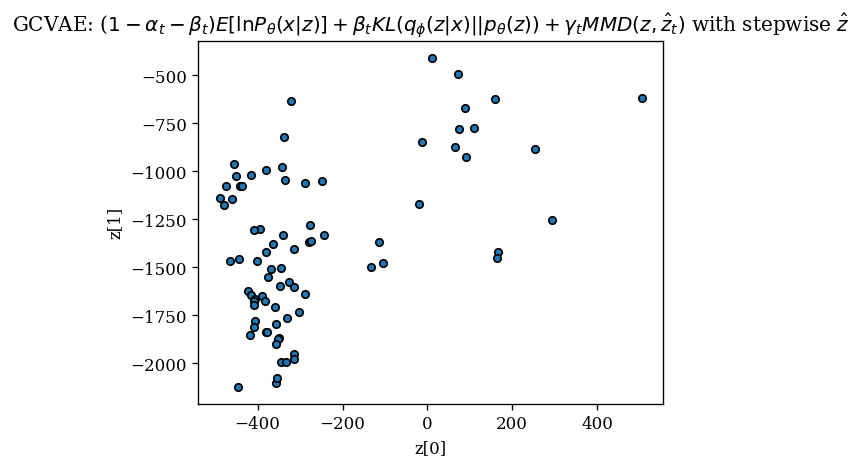

In [35]:
z_mean, z_std, z = model.model.encoder.predict(x_test, batch_size = batch_size)

fig = plt.figure(figsize=(5, 4))
plt.scatter(z[:, 0], z[:, 1], edgecolor="black", s = 20)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
if loss_index == 0:
    plt.title('VAE Loss: $E [\ln P_{\\theta}(x|z)]$ + $KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 1:
    plt.title('$\\beta$-VAE: $E [\ln P_{\\theta}(x|z)]$ + $\\beta KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 2:
    plt.title('ControlVAE: $E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 3:
    plt.title('infoVAE: ($E [\ln P_{\theta}(x|z)] + \\beta KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z_{t+1}, \\hat{z}_t)$ with stepwise $\\hat{z}$')
elif loss_index == 4:
    plt.title('GCVAE: ($1-\\alpha_t- \\beta_t)E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z)) + \\gamma_t MMD (z,\\hat{z}_t)$ with stepwise $\\hat{z}$')


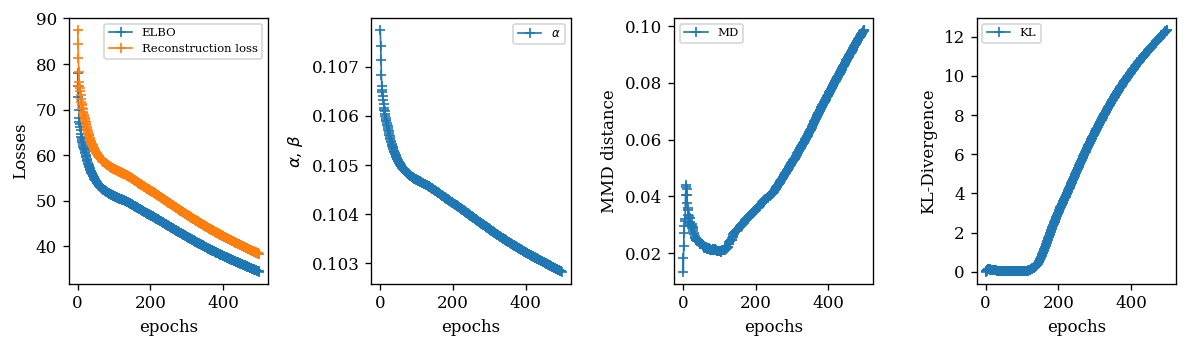

In [37]:
fs = 7
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].plot(np.arange(model.epoch), model.ELBO, label = 'ELBO', marker = '+', lw = 1.)
ax[0].plot(np.arange(model.epoch), model.RECON_LOSS, label = 'Reconstruction loss', marker = '+', lw = 1.)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Losses')
ax[1].plot(np.arange(model.epoch), model.ALPHA, label = '$\\alpha$', marker = '+', lw = 1.)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\\alpha$, $\\beta$')
ax[2].plot(np.arange(model.epoch), model.MMD, label = 'MD', marker = '+', lw = 1.)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('MMD distance')
ax[3].plot(np.arange(model.epoch), model.KL_DIV, label = 'KL', marker = '+', lw = 1.)
ax[3].set_xlabel('epochs')
ax[3].set_ylabel('KL-Divergence')
ax[0].legend(prop={"size":fs})
ax[1].legend(prop={"size":fs})
ax[2].legend(prop={"size":fs})
ax[3].legend(prop={"size":fs})
plt.tight_layout()

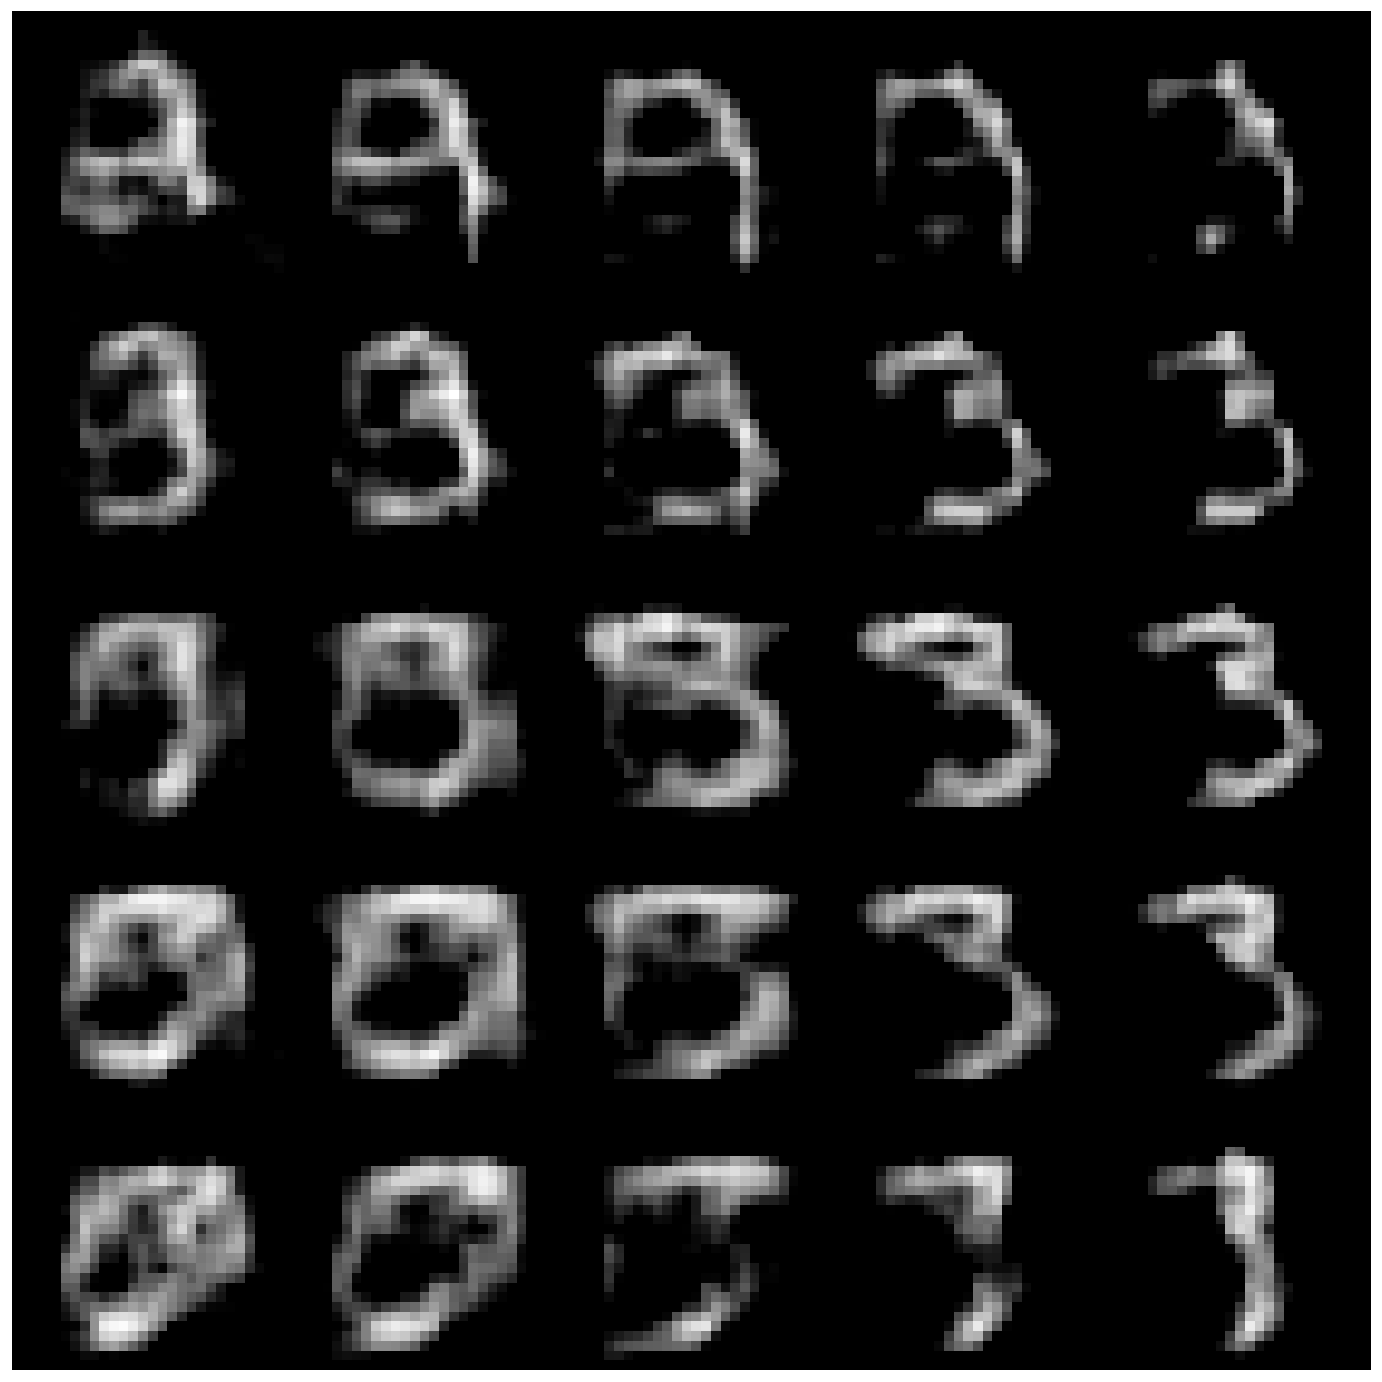

In [101]:
plot_latent_space(model.model, n= 5)

### 1000 -iterations

In [46]:
loss_index = 4
# vae_type = 'gcvae' #else infovae
inp_shape =  x_train.shape[1:]
num_features = inp_shape[0]

#the parameters are only to change fixed weights
params = { #beta, gamma
            'elbo': (1, 0),
            'betavae': ((1, 5), 0),
            'controlvae': (0, 0),
            'infovae': (0, 500),
            'gcvae': (1, 1), #not necessarily useful inside algo
    }

lr = 1e-3
epochs = 1000
hidden_dim = 100
latent_dims = 2
loss_type = list(params.keys())[loss_index] #elbo -> 0; beta-> 1; controlvae -> 2; infovae -> 3; gcvae -> 4
archi_type = 'v2'
#params
distrib_type = 'g'
beta, gamma = params[f'{loss_type}']
mmd_typ = 'mmd' #['mmd', 'mah', 'mah_rkhs', 'mah_gcvae']
save_model_arg = False
save_model_after = 10
model = gcvae(inp_shape = inp_shape,
                    num_features = num_features,
                    hidden_dim = hidden_dim,
                    latent_dim = latent_dims, 
                    batch_size = batch_size,
                    beta = beta,
                    gamma = gamma,
                    dist = distrib_type,
                    vloss = loss_type,
                    lr = lr, 
                    epochs = epochs,
                    architecture = archi_type,
                    mmd_type = mmd_typ).fit(train_dataset, x_test,
                                            datatype, stopping = False,
                                            save_model = save_model_arg,
                                            save_model_iter = save_model_after)

100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


epoch 1 - ELBO: 74.145 - RECON. LOSS: 83.038 - KL: 0.002 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


epoch 2 - ELBO: 71.430 - RECON. LOSS: 79.971 - KL: 0.006 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 3 - ELBO: 68.739 - RECON. LOSS: 76.931 - KL: 0.012 - alpha: 0.107 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 4 - ELBO: 66.533 - RECON. LOSS: 74.442 - KL: 0.024 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 5 - ELBO: 66.549 - RECON. LOSS: 74.455 - KL: 0.039 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 6 - ELBO: 65.655 - RECON. LOSS: 73.446 - KL: 0.043 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 7 - ELBO: 64.577 - RECON. LOSS: 72.231 - KL: 0.043 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


epoch 8 - ELBO: 63.938 - RECON. LOSS: 71.513 - KL: 0.040 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 9 - ELBO: 63.285 - RECON. LOSS: 70.776 - KL: 0.037 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


epoch 10 - ELBO: 62.819 - RECON. LOSS: 70.251 - KL: 0.035 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


epoch 11 - ELBO: 62.356 - RECON. LOSS: 69.729 - KL: 0.033 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


epoch 12 - ELBO: 61.935 - RECON. LOSS: 69.255 - KL: 0.031 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 13 - ELBO: 61.441 - RECON. LOSS: 68.698 - KL: 0.029 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 14 - ELBO: 61.089 - RECON. LOSS: 68.302 - KL: 0.028 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 15 - ELBO: 60.780 - RECON. LOSS: 67.954 - KL: 0.027 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 16 - ELBO: 60.463 - RECON. LOSS: 67.598 - KL: 0.026 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 17 - ELBO: 60.130 - RECON. LOSS: 67.223 - KL: 0.026 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch 18 - ELBO: 59.822 - RECON. LOSS: 66.875 - KL: 0.025 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 19 - ELBO: 59.504 - RECON. LOSS: 66.518 - KL: 0.024 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 20 - ELBO: 59.164 - RECON. LOSS: 66.134 - KL: 0.024 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 21 - ELBO: 58.823 - RECON. LOSS: 65.750 - KL: 0.023 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 22 - ELBO: 58.539 - RECON. LOSS: 65.432 - KL: 0.023 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 23 - ELBO: 58.213 - RECON. LOSS: 65.064 - KL: 0.022 - alpha: 0.106 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


epoch 24 - ELBO: 57.864 - RECON. LOSS: 64.671 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch 25 - ELBO: 57.556 - RECON. LOSS: 64.325 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


epoch 26 - ELBO: 57.263 - RECON. LOSS: 63.995 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 27 - ELBO: 56.968 - RECON. LOSS: 63.663 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 28 - ELBO: 56.722 - RECON. LOSS: 63.387 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 29 - ELBO: 56.481 - RECON. LOSS: 63.115 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 30 - ELBO: 56.233 - RECON. LOSS: 62.836 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 31 - ELBO: 55.993 - RECON. LOSS: 62.566 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 32 - ELBO: 55.784 - RECON. LOSS: 62.331 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 33 - ELBO: 55.568 - RECON. LOSS: 62.087 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.016


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 34 - ELBO: 55.372 - RECON. LOSS: 61.867 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 35 - ELBO: 55.170 - RECON. LOSS: 61.640 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.017


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 36 - ELBO: 54.989 - RECON. LOSS: 61.435 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 37 - ELBO: 54.808 - RECON. LOSS: 61.231 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 38 - ELBO: 54.661 - RECON. LOSS: 61.065 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 39 - ELBO: 54.490 - RECON. LOSS: 60.873 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 40 - ELBO: 54.339 - RECON. LOSS: 60.703 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


epoch 41 - ELBO: 54.191 - RECON. LOSS: 60.537 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 42 - ELBO: 54.042 - RECON. LOSS: 60.369 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 43 - ELBO: 53.907 - RECON. LOSS: 60.217 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 44 - ELBO: 53.771 - RECON. LOSS: 60.064 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 45 - ELBO: 53.649 - RECON. LOSS: 59.927 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


epoch 46 - ELBO: 53.532 - RECON. LOSS: 59.795 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 47 - ELBO: 53.419 - RECON. LOSS: 59.667 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


epoch 48 - ELBO: 53.304 - RECON. LOSS: 59.538 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 49 - ELBO: 53.195 - RECON. LOSS: 59.416 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 50 - ELBO: 53.093 - RECON. LOSS: 59.302 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


epoch 51 - ELBO: 52.992 - RECON. LOSS: 59.187 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 52 - ELBO: 52.903 - RECON. LOSS: 59.087 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 53 - ELBO: 52.808 - RECON. LOSS: 58.981 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


epoch 54 - ELBO: 52.718 - RECON. LOSS: 58.878 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 55 - ELBO: 52.622 - RECON. LOSS: 58.770 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 56 - ELBO: 52.539 - RECON. LOSS: 58.677 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 57 - ELBO: 52.454 - RECON. LOSS: 58.582 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 58 - ELBO: 52.379 - RECON. LOSS: 58.497 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 59 - ELBO: 52.303 - RECON. LOSS: 58.412 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 60 - ELBO: 52.229 - RECON. LOSS: 58.329 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 61 - ELBO: 52.159 - RECON. LOSS: 58.250 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 62 - ELBO: 52.084 - RECON. LOSS: 58.166 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 63 - ELBO: 52.015 - RECON. LOSS: 58.088 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 64 - ELBO: 51.951 - RECON. LOSS: 58.016 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 65 - ELBO: 51.886 - RECON. LOSS: 57.942 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


epoch 66 - ELBO: 51.824 - RECON. LOSS: 57.872 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 67 - ELBO: 51.762 - RECON. LOSS: 57.803 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 68 - ELBO: 51.701 - RECON. LOSS: 57.734 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 69 - ELBO: 51.643 - RECON. LOSS: 57.670 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 70 - ELBO: 51.586 - RECON. LOSS: 57.605 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 71 - ELBO: 51.532 - RECON. LOSS: 57.544 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 72 - ELBO: 51.481 - RECON. LOSS: 57.486 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 73 - ELBO: 51.429 - RECON. LOSS: 57.428 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 74 - ELBO: 51.376 - RECON. LOSS: 57.369 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 75 - ELBO: 51.328 - RECON. LOSS: 57.314 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 76 - ELBO: 51.280 - RECON. LOSS: 57.261 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 77 - ELBO: 51.232 - RECON. LOSS: 57.207 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 78 - ELBO: 51.189 - RECON. LOSS: 57.158 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 79 - ELBO: 51.147 - RECON. LOSS: 57.111 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 80 - ELBO: 51.100 - RECON. LOSS: 57.058 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 81 - ELBO: 51.060 - RECON. LOSS: 57.013 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 82 - ELBO: 51.017 - RECON. LOSS: 56.965 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 83 - ELBO: 50.976 - RECON. LOSS: 56.919 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 84 - ELBO: 50.938 - RECON. LOSS: 56.876 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


epoch 85 - ELBO: 50.900 - RECON. LOSS: 56.834 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 86 - ELBO: 50.864 - RECON. LOSS: 56.793 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 87 - ELBO: 50.825 - RECON. LOSS: 56.749 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 88 - ELBO: 50.789 - RECON. LOSS: 56.709 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 89 - ELBO: 50.751 - RECON. LOSS: 56.665 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 90 - ELBO: 50.715 - RECON. LOSS: 56.625 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 91 - ELBO: 50.679 - RECON. LOSS: 56.585 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 92 - ELBO: 50.644 - RECON. LOSS: 56.545 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 93 - ELBO: 50.609 - RECON. LOSS: 56.506 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 94 - ELBO: 50.581 - RECON. LOSS: 56.475 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 95 - ELBO: 50.547 - RECON. LOSS: 56.437 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 96 - ELBO: 50.515 - RECON. LOSS: 56.401 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 97 - ELBO: 50.481 - RECON. LOSS: 56.363 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 98 - ELBO: 50.448 - RECON. LOSS: 56.326 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


epoch 99 - ELBO: 50.417 - RECON. LOSS: 56.290 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 100 - ELBO: 50.387 - RECON. LOSS: 56.257 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 101 - ELBO: 50.354 - RECON. LOSS: 56.219 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 102 - ELBO: 50.327 - RECON. LOSS: 56.189 - KL: 0.018 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.018


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 103 - ELBO: 50.299 - RECON. LOSS: 56.158 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 104 - ELBO: 50.271 - RECON. LOSS: 56.126 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 105 - ELBO: 50.241 - RECON. LOSS: 56.092 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 106 - ELBO: 50.212 - RECON. LOSS: 56.060 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 107 - ELBO: 50.183 - RECON. LOSS: 56.027 - KL: 0.019 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 108 - ELBO: 50.156 - RECON. LOSS: 55.996 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 109 - ELBO: 50.128 - RECON. LOSS: 55.964 - KL: 0.020 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 110 - ELBO: 50.101 - RECON. LOSS: 55.934 - KL: 0.021 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 111 - ELBO: 50.076 - RECON. LOSS: 55.906 - KL: 0.022 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 112 - ELBO: 50.051 - RECON. LOSS: 55.878 - KL: 0.023 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.019


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 113 - ELBO: 50.024 - RECON. LOSS: 55.847 - KL: 0.024 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 114 - ELBO: 49.998 - RECON. LOSS: 55.818 - KL: 0.027 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 115 - ELBO: 49.970 - RECON. LOSS: 55.786 - KL: 0.030 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 116 - ELBO: 49.940 - RECON. LOSS: 55.752 - KL: 0.035 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.020


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 117 - ELBO: 49.910 - RECON. LOSS: 55.718 - KL: 0.041 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 118 - ELBO: 49.886 - RECON. LOSS: 55.691 - KL: 0.045 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 119 - ELBO: 49.857 - RECON. LOSS: 55.658 - KL: 0.051 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 120 - ELBO: 49.824 - RECON. LOSS: 55.621 - KL: 0.059 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.021


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 121 - ELBO: 49.789 - RECON. LOSS: 55.580 - KL: 0.066 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.022


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 122 - ELBO: 49.752 - RECON. LOSS: 55.538 - KL: 0.077 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 123 - ELBO: 49.720 - RECON. LOSS: 55.501 - KL: 0.089 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.023


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 124 - ELBO: 49.690 - RECON. LOSS: 55.466 - KL: 0.114 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.024


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 125 - ELBO: 49.655 - RECON. LOSS: 55.426 - KL: 0.129 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.025


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 126 - ELBO: 49.620 - RECON. LOSS: 55.385 - KL: 0.144 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.026


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 127 - ELBO: 49.581 - RECON. LOSS: 55.340 - KL: 0.165 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.028


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 128 - ELBO: 49.542 - RECON. LOSS: 55.295 - KL: 0.187 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.029


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 129 - ELBO: 49.505 - RECON. LOSS: 55.252 - KL: 0.205 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.030


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 130 - ELBO: 49.465 - RECON. LOSS: 55.205 - KL: 0.224 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.031


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 131 - ELBO: 49.427 - RECON. LOSS: 55.161 - KL: 0.250 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.033


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 132 - ELBO: 49.384 - RECON. LOSS: 55.110 - KL: 0.274 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.034


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 133 - ELBO: 49.347 - RECON. LOSS: 55.068 - KL: 0.295 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.035


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 134 - ELBO: 49.301 - RECON. LOSS: 55.015 - KL: 0.320 - alpha: 0.105 - beta: 0.000 - gamma: 1.048 - mmd: 0.037


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 135 - ELBO: 49.258 - RECON. LOSS: 54.965 - KL: 0.349 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.038


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 136 - ELBO: 49.212 - RECON. LOSS: 54.912 - KL: 0.375 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 137 - ELBO: 49.168 - RECON. LOSS: 54.862 - KL: 0.399 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.039


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 138 - ELBO: 49.122 - RECON. LOSS: 54.810 - KL: 0.426 - alpha: 0.104 - beta: 0.000 - gamma: 1.048 - mmd: 0.040


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 139 - ELBO: 49.077 - RECON. LOSS: 54.758 - KL: 0.454 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.041


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 140 - ELBO: 49.030 - RECON. LOSS: 54.705 - KL: 0.480 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 141 - ELBO: 48.984 - RECON. LOSS: 54.652 - KL: 0.506 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.042


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 142 - ELBO: 48.938 - RECON. LOSS: 54.599 - KL: 0.538 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.043


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 143 - ELBO: 48.891 - RECON. LOSS: 54.546 - KL: 0.568 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 144 - ELBO: 48.845 - RECON. LOSS: 54.493 - KL: 0.598 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.044


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 145 - ELBO: 48.799 - RECON. LOSS: 54.440 - KL: 0.631 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.045


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 146 - ELBO: 48.751 - RECON. LOSS: 54.387 - KL: 0.662 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 147 - ELBO: 48.704 - RECON. LOSS: 54.333 - KL: 0.692 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.046


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 148 - ELBO: 48.658 - RECON. LOSS: 54.281 - KL: 0.725 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 149 - ELBO: 48.611 - RECON. LOSS: 54.227 - KL: 0.757 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.047


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 150 - ELBO: 48.564 - RECON. LOSS: 54.173 - KL: 0.789 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.048


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 151 - ELBO: 48.516 - RECON. LOSS: 54.119 - KL: 0.823 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 152 - ELBO: 48.469 - RECON. LOSS: 54.065 - KL: 0.855 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.049


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 153 - ELBO: 48.422 - RECON. LOSS: 54.012 - KL: 0.887 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 154 - ELBO: 48.375 - RECON. LOSS: 53.959 - KL: 0.921 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 155 - ELBO: 48.330 - RECON. LOSS: 53.908 - KL: 0.952 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.050


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 156 - ELBO: 48.283 - RECON. LOSS: 53.854 - KL: 0.986 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 157 - ELBO: 48.236 - RECON. LOSS: 53.801 - KL: 1.018 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.051


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 158 - ELBO: 48.189 - RECON. LOSS: 53.748 - KL: 1.052 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 159 - ELBO: 48.141 - RECON. LOSS: 53.694 - KL: 1.086 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.052


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 160 - ELBO: 48.094 - RECON. LOSS: 53.641 - KL: 1.120 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 161 - ELBO: 48.047 - RECON. LOSS: 53.587 - KL: 1.155 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 162 - ELBO: 48.001 - RECON. LOSS: 53.535 - KL: 1.188 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.053


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 163 - ELBO: 47.955 - RECON. LOSS: 53.483 - KL: 1.225 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.054


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 164 - ELBO: 47.911 - RECON. LOSS: 53.433 - KL: 1.258 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.054


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 165 - ELBO: 47.871 - RECON. LOSS: 53.388 - KL: 1.297 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 166 - ELBO: 47.835 - RECON. LOSS: 53.347 - KL: 1.329 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 167 - ELBO: 47.790 - RECON. LOSS: 53.296 - KL: 1.365 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.055


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 168 - ELBO: 47.748 - RECON. LOSS: 53.249 - KL: 1.401 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 169 - ELBO: 47.712 - RECON. LOSS: 53.208 - KL: 1.433 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 170 - ELBO: 47.667 - RECON. LOSS: 53.157 - KL: 1.469 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.056


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 171 - ELBO: 47.630 - RECON. LOSS: 53.115 - KL: 1.509 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 172 - ELBO: 47.589 - RECON. LOSS: 53.068 - KL: 1.541 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.057


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 173 - ELBO: 47.548 - RECON. LOSS: 53.021 - KL: 1.572 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 174 - ELBO: 47.510 - RECON. LOSS: 52.978 - KL: 1.608 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 175 - ELBO: 47.466 - RECON. LOSS: 52.928 - KL: 1.642 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 176 - ELBO: 47.426 - RECON. LOSS: 52.884 - KL: 1.673 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.058


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 177 - ELBO: 47.381 - RECON. LOSS: 52.833 - KL: 1.706 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 178 - ELBO: 47.342 - RECON. LOSS: 52.788 - KL: 1.740 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 179 - ELBO: 47.298 - RECON. LOSS: 52.739 - KL: 1.771 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 180 - ELBO: 47.257 - RECON. LOSS: 52.693 - KL: 1.802 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.059


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 181 - ELBO: 47.214 - RECON. LOSS: 52.644 - KL: 1.835 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 182 - ELBO: 47.172 - RECON. LOSS: 52.597 - KL: 1.867 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 183 - ELBO: 47.131 - RECON. LOSS: 52.551 - KL: 1.896 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 184 - ELBO: 47.088 - RECON. LOSS: 52.502 - KL: 1.926 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 185 - ELBO: 47.047 - RECON. LOSS: 52.456 - KL: 1.959 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.060


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 186 - ELBO: 47.004 - RECON. LOSS: 52.407 - KL: 1.990 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


epoch 187 - ELBO: 46.963 - RECON. LOSS: 52.361 - KL: 2.019 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 188 - ELBO: 46.921 - RECON. LOSS: 52.313 - KL: 2.051 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 189 - ELBO: 46.878 - RECON. LOSS: 52.265 - KL: 2.082 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.061


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 190 - ELBO: 46.837 - RECON. LOSS: 52.218 - KL: 2.112 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 191 - ELBO: 46.795 - RECON. LOSS: 52.171 - KL: 2.142 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 192 - ELBO: 46.753 - RECON. LOSS: 52.124 - KL: 2.173 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 193 - ELBO: 46.711 - RECON. LOSS: 52.076 - KL: 2.203 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.062


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 194 - ELBO: 46.669 - RECON. LOSS: 52.028 - KL: 2.233 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 195 - ELBO: 46.628 - RECON. LOSS: 51.982 - KL: 2.265 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 196 - ELBO: 46.586 - RECON. LOSS: 51.935 - KL: 2.294 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 197 - ELBO: 46.544 - RECON. LOSS: 51.888 - KL: 2.324 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 198 - ELBO: 46.504 - RECON. LOSS: 51.843 - KL: 2.355 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 199 - ELBO: 46.463 - RECON. LOSS: 51.796 - KL: 2.384 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 200 - ELBO: 46.421 - RECON. LOSS: 51.749 - KL: 2.414 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.063


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 201 - ELBO: 46.380 - RECON. LOSS: 51.704 - KL: 2.445 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 202 - ELBO: 46.341 - RECON. LOSS: 51.659 - KL: 2.473 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 203 - ELBO: 46.300 - RECON. LOSS: 51.613 - KL: 2.504 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 204 - ELBO: 46.258 - RECON. LOSS: 51.566 - KL: 2.535 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 205 - ELBO: 46.219 - RECON. LOSS: 51.522 - KL: 2.563 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 206 - ELBO: 46.181 - RECON. LOSS: 51.479 - KL: 2.595 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.064


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 207 - ELBO: 46.140 - RECON. LOSS: 51.433 - KL: 2.624 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 208 - ELBO: 46.099 - RECON. LOSS: 51.387 - KL: 2.653 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 209 - ELBO: 46.060 - RECON. LOSS: 51.343 - KL: 2.684 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 210 - ELBO: 46.022 - RECON. LOSS: 51.300 - KL: 2.713 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 211 - ELBO: 45.983 - RECON. LOSS: 51.256 - KL: 2.744 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 212 - ELBO: 45.942 - RECON. LOSS: 51.209 - KL: 2.774 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 213 - ELBO: 45.902 - RECON. LOSS: 51.164 - KL: 2.803 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.065


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 214 - ELBO: 45.863 - RECON. LOSS: 51.121 - KL: 2.834 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 215 - ELBO: 45.822 - RECON. LOSS: 51.075 - KL: 2.862 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 216 - ELBO: 45.781 - RECON. LOSS: 51.029 - KL: 2.892 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 217 - ELBO: 45.741 - RECON. LOSS: 50.983 - KL: 2.922 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 218 - ELBO: 45.701 - RECON. LOSS: 50.938 - KL: 2.951 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.066


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 219 - ELBO: 45.661 - RECON. LOSS: 50.893 - KL: 2.981 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 220 - ELBO: 45.619 - RECON. LOSS: 50.846 - KL: 3.010 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 221 - ELBO: 45.578 - RECON. LOSS: 50.800 - KL: 3.039 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 222 - ELBO: 45.538 - RECON. LOSS: 50.755 - KL: 3.069 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 223 - ELBO: 45.499 - RECON. LOSS: 50.711 - KL: 3.097 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 224 - ELBO: 45.458 - RECON. LOSS: 50.665 - KL: 3.127 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 225 - ELBO: 45.417 - RECON. LOSS: 50.618 - KL: 3.156 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 226 - ELBO: 45.375 - RECON. LOSS: 50.572 - KL: 3.185 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.067


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 227 - ELBO: 45.334 - RECON. LOSS: 50.525 - KL: 3.214 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 228 - ELBO: 45.293 - RECON. LOSS: 50.479 - KL: 3.244 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 229 - ELBO: 45.251 - RECON. LOSS: 50.432 - KL: 3.272 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 230 - ELBO: 45.210 - RECON. LOSS: 50.385 - KL: 3.302 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 231 - ELBO: 45.169 - RECON. LOSS: 50.339 - KL: 3.330 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.068


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 232 - ELBO: 45.132 - RECON. LOSS: 50.297 - KL: 3.361 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 233 - ELBO: 45.103 - RECON. LOSS: 50.264 - KL: 3.388 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 234 - ELBO: 45.073 - RECON. LOSS: 50.230 - KL: 3.419 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 235 - ELBO: 45.037 - RECON. LOSS: 50.190 - KL: 3.446 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 236 - ELBO: 44.995 - RECON. LOSS: 50.143 - KL: 3.473 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.069


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 237 - ELBO: 44.961 - RECON. LOSS: 50.104 - KL: 3.503 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 238 - ELBO: 44.923 - RECON. LOSS: 50.062 - KL: 3.529 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 239 - ELBO: 44.883 - RECON. LOSS: 50.016 - KL: 3.555 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 240 - ELBO: 44.844 - RECON. LOSS: 49.973 - KL: 3.584 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 241 - ELBO: 44.804 - RECON. LOSS: 49.928 - KL: 3.610 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 242 - ELBO: 44.765 - RECON. LOSS: 49.884 - KL: 3.636 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 243 - ELBO: 44.723 - RECON. LOSS: 49.837 - KL: 3.663 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.070


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 244 - ELBO: 44.685 - RECON. LOSS: 49.794 - KL: 3.689 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 245 - ELBO: 44.644 - RECON. LOSS: 49.748 - KL: 3.716 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 246 - ELBO: 44.603 - RECON. LOSS: 49.701 - KL: 3.742 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 247 - ELBO: 44.563 - RECON. LOSS: 49.657 - KL: 3.768 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 248 - ELBO: 44.522 - RECON. LOSS: 49.610 - KL: 3.795 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 249 - ELBO: 44.482 - RECON. LOSS: 49.565 - KL: 3.820 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 250 - ELBO: 44.439 - RECON. LOSS: 49.517 - KL: 3.845 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.071


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 251 - ELBO: 44.400 - RECON. LOSS: 49.472 - KL: 3.872 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 252 - ELBO: 44.359 - RECON. LOSS: 49.426 - KL: 3.896 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 253 - ELBO: 44.316 - RECON. LOSS: 49.379 - KL: 3.922 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 254 - ELBO: 44.275 - RECON. LOSS: 49.333 - KL: 3.947 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 255 - ELBO: 44.233 - RECON. LOSS: 49.285 - KL: 3.972 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 256 - ELBO: 44.192 - RECON. LOSS: 49.239 - KL: 3.997 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 257 - ELBO: 44.150 - RECON. LOSS: 49.192 - KL: 4.022 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 258 - ELBO: 44.107 - RECON. LOSS: 49.144 - KL: 4.048 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 259 - ELBO: 44.066 - RECON. LOSS: 49.098 - KL: 4.072 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.072


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 260 - ELBO: 44.023 - RECON. LOSS: 49.049 - KL: 4.098 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 261 - ELBO: 43.981 - RECON. LOSS: 49.002 - KL: 4.123 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 262 - ELBO: 43.940 - RECON. LOSS: 48.956 - KL: 4.148 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 263 - ELBO: 43.899 - RECON. LOSS: 48.910 - KL: 4.174 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 264 - ELBO: 43.866 - RECON. LOSS: 48.872 - KL: 4.198 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 265 - ELBO: 43.833 - RECON. LOSS: 48.835 - KL: 4.224 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.073


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 266 - ELBO: 43.792 - RECON. LOSS: 48.788 - KL: 4.248 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 267 - ELBO: 43.753 - RECON. LOSS: 48.745 - KL: 4.273 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 268 - ELBO: 43.715 - RECON. LOSS: 48.701 - KL: 4.299 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 269 - ELBO: 43.674 - RECON. LOSS: 48.656 - KL: 4.322 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 270 - ELBO: 43.636 - RECON. LOSS: 48.613 - KL: 4.347 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.074


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


epoch 271 - ELBO: 43.594 - RECON. LOSS: 48.566 - KL: 4.371 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 272 - ELBO: 43.554 - RECON. LOSS: 48.520 - KL: 4.395 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 273 - ELBO: 43.513 - RECON. LOSS: 48.475 - KL: 4.419 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 274 - ELBO: 43.471 - RECON. LOSS: 48.427 - KL: 4.442 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 275 - ELBO: 43.430 - RECON. LOSS: 48.381 - KL: 4.465 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 276 - ELBO: 43.389 - RECON. LOSS: 48.334 - KL: 4.489 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.075


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 277 - ELBO: 43.347 - RECON. LOSS: 48.288 - KL: 4.512 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 278 - ELBO: 43.307 - RECON. LOSS: 48.243 - KL: 4.535 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 279 - ELBO: 43.265 - RECON. LOSS: 48.195 - KL: 4.558 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 280 - ELBO: 43.223 - RECON. LOSS: 48.148 - KL: 4.581 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 281 - ELBO: 43.182 - RECON. LOSS: 48.102 - KL: 4.605 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.076


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 282 - ELBO: 43.140 - RECON. LOSS: 48.054 - KL: 4.627 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 283 - ELBO: 43.100 - RECON. LOSS: 48.009 - KL: 4.651 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 284 - ELBO: 43.061 - RECON. LOSS: 47.966 - KL: 4.673 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 285 - ELBO: 43.022 - RECON. LOSS: 47.922 - KL: 4.698 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 286 - ELBO: 42.988 - RECON. LOSS: 47.883 - KL: 4.719 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 287 - ELBO: 42.950 - RECON. LOSS: 47.840 - KL: 4.743 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 288 - ELBO: 42.909 - RECON. LOSS: 47.794 - KL: 4.766 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.077


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 289 - ELBO: 42.869 - RECON. LOSS: 47.749 - KL: 4.788 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 290 - ELBO: 42.831 - RECON. LOSS: 47.706 - KL: 4.812 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


epoch 291 - ELBO: 42.792 - RECON. LOSS: 47.663 - KL: 4.834 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 292 - ELBO: 42.755 - RECON. LOSS: 47.621 - KL: 4.857 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 293 - ELBO: 42.714 - RECON. LOSS: 47.575 - KL: 4.878 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 294 - ELBO: 42.673 - RECON. LOSS: 47.529 - KL: 4.900 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 295 - ELBO: 42.634 - RECON. LOSS: 47.486 - KL: 4.923 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.078


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 296 - ELBO: 42.595 - RECON. LOSS: 47.441 - KL: 4.945 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 297 - ELBO: 42.554 - RECON. LOSS: 47.395 - KL: 4.967 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 298 - ELBO: 42.513 - RECON. LOSS: 47.349 - KL: 4.989 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 299 - ELBO: 42.473 - RECON. LOSS: 47.304 - KL: 5.010 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 300 - ELBO: 42.433 - RECON. LOSS: 47.259 - KL: 5.033 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 301 - ELBO: 42.392 - RECON. LOSS: 47.212 - KL: 5.054 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.079


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 302 - ELBO: 42.350 - RECON. LOSS: 47.166 - KL: 5.076 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 303 - ELBO: 42.310 - RECON. LOSS: 47.121 - KL: 5.098 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 304 - ELBO: 42.269 - RECON. LOSS: 47.074 - KL: 5.120 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 305 - ELBO: 42.227 - RECON. LOSS: 47.028 - KL: 5.141 - alpha: 0.104 - beta: 0.000 - gamma: 1.049 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 306 - ELBO: 42.187 - RECON. LOSS: 46.982 - KL: 5.163 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 307 - ELBO: 42.145 - RECON. LOSS: 46.935 - KL: 5.185 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 308 - ELBO: 42.103 - RECON. LOSS: 46.888 - KL: 5.207 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 309 - ELBO: 42.063 - RECON. LOSS: 46.843 - KL: 5.228 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.080


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 310 - ELBO: 42.023 - RECON. LOSS: 46.798 - KL: 5.250 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 311 - ELBO: 41.983 - RECON. LOSS: 46.753 - KL: 5.271 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 312 - ELBO: 41.950 - RECON. LOSS: 46.715 - KL: 5.295 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 313 - ELBO: 41.933 - RECON. LOSS: 46.696 - KL: 5.314 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 314 - ELBO: 41.898 - RECON. LOSS: 46.657 - KL: 5.336 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.081


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 315 - ELBO: 41.863 - RECON. LOSS: 46.617 - KL: 5.358 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 316 - ELBO: 41.830 - RECON. LOSS: 46.581 - KL: 5.378 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 317 - ELBO: 41.801 - RECON. LOSS: 46.547 - KL: 5.400 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 318 - ELBO: 41.764 - RECON. LOSS: 46.506 - KL: 5.420 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 319 - ELBO: 41.727 - RECON. LOSS: 46.464 - KL: 5.440 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 320 - ELBO: 41.693 - RECON. LOSS: 46.426 - KL: 5.461 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 321 - ELBO: 41.654 - RECON. LOSS: 46.382 - KL: 5.480 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.082


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 322 - ELBO: 41.616 - RECON. LOSS: 46.339 - KL: 5.500 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 323 - ELBO: 41.579 - RECON. LOSS: 46.297 - KL: 5.521 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 324 - ELBO: 41.541 - RECON. LOSS: 46.254 - KL: 5.539 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 325 - ELBO: 41.502 - RECON. LOSS: 46.211 - KL: 5.559 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.083


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 326 - ELBO: 41.465 - RECON. LOSS: 46.169 - KL: 5.579 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 327 - ELBO: 41.426 - RECON. LOSS: 46.125 - KL: 5.597 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 328 - ELBO: 41.387 - RECON. LOSS: 46.082 - KL: 5.616 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 329 - ELBO: 41.347 - RECON. LOSS: 46.037 - KL: 5.636 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 330 - ELBO: 41.309 - RECON. LOSS: 45.994 - KL: 5.655 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 331 - ELBO: 41.273 - RECON. LOSS: 45.953 - KL: 5.675 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 332 - ELBO: 41.234 - RECON. LOSS: 45.910 - KL: 5.693 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 333 - ELBO: 41.196 - RECON. LOSS: 45.867 - KL: 5.714 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.084


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 334 - ELBO: 41.158 - RECON. LOSS: 45.823 - KL: 5.733 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 335 - ELBO: 41.119 - RECON. LOSS: 45.780 - KL: 5.752 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 336 - ELBO: 41.079 - RECON. LOSS: 45.735 - KL: 5.772 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 337 - ELBO: 41.041 - RECON. LOSS: 45.692 - KL: 5.791 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 338 - ELBO: 41.001 - RECON. LOSS: 45.648 - KL: 5.811 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.085


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 339 - ELBO: 40.962 - RECON. LOSS: 45.603 - KL: 5.830 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 340 - ELBO: 40.924 - RECON. LOSS: 45.560 - KL: 5.850 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 341 - ELBO: 40.885 - RECON. LOSS: 45.516 - KL: 5.869 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 342 - ELBO: 40.845 - RECON. LOSS: 45.472 - KL: 5.888 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 343 - ELBO: 40.807 - RECON. LOSS: 45.429 - KL: 5.907 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 344 - ELBO: 40.773 - RECON. LOSS: 45.391 - KL: 5.927 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 345 - ELBO: 40.746 - RECON. LOSS: 45.360 - KL: 5.945 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.086


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 346 - ELBO: 40.717 - RECON. LOSS: 45.327 - KL: 5.966 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 347 - ELBO: 40.681 - RECON. LOSS: 45.287 - KL: 5.985 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 348 - ELBO: 40.642 - RECON. LOSS: 45.243 - KL: 6.004 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 349 - ELBO: 40.608 - RECON. LOSS: 45.205 - KL: 6.023 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 350 - ELBO: 40.574 - RECON. LOSS: 45.167 - KL: 6.041 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.087


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 351 - ELBO: 40.537 - RECON. LOSS: 45.125 - KL: 6.061 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 352 - ELBO: 40.499 - RECON. LOSS: 45.082 - KL: 6.080 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 353 - ELBO: 40.463 - RECON. LOSS: 45.042 - KL: 6.098 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 354 - ELBO: 40.428 - RECON. LOSS: 45.002 - KL: 6.117 - alpha: 0.104 - beta: 0.000 - gamma: 1.050 - mmd: 0.088


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 355 - ELBO: 40.390 - RECON. LOSS: 44.959 - KL: 6.135 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 356 - ELBO: 40.351 - RECON. LOSS: 44.915 - KL: 6.153 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 357 - ELBO: 40.314 - RECON. LOSS: 44.873 - KL: 6.172 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 358 - ELBO: 40.278 - RECON. LOSS: 44.832 - KL: 6.189 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 359 - ELBO: 40.241 - RECON. LOSS: 44.791 - KL: 6.208 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 360 - ELBO: 40.204 - RECON. LOSS: 44.749 - KL: 6.226 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 361 - ELBO: 40.165 - RECON. LOSS: 44.706 - KL: 6.244 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.089


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 362 - ELBO: 40.127 - RECON. LOSS: 44.663 - KL: 6.262 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 363 - ELBO: 40.089 - RECON. LOSS: 44.620 - KL: 6.280 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 364 - ELBO: 40.052 - RECON. LOSS: 44.579 - KL: 6.299 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 365 - ELBO: 40.016 - RECON. LOSS: 44.538 - KL: 6.317 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 366 - ELBO: 39.979 - RECON. LOSS: 44.497 - KL: 6.335 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.090


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 367 - ELBO: 39.942 - RECON. LOSS: 44.455 - KL: 6.352 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 368 - ELBO: 39.906 - RECON. LOSS: 44.414 - KL: 6.371 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 369 - ELBO: 39.869 - RECON. LOSS: 44.372 - KL: 6.388 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 370 - ELBO: 39.830 - RECON. LOSS: 44.329 - KL: 6.406 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 371 - ELBO: 39.793 - RECON. LOSS: 44.287 - KL: 6.424 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.091


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 372 - ELBO: 39.756 - RECON. LOSS: 44.245 - KL: 6.442 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 373 - ELBO: 39.718 - RECON. LOSS: 44.203 - KL: 6.459 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 374 - ELBO: 39.681 - RECON. LOSS: 44.161 - KL: 6.477 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 375 - ELBO: 39.644 - RECON. LOSS: 44.120 - KL: 6.495 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 376 - ELBO: 39.613 - RECON. LOSS: 44.084 - KL: 6.512 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.092


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 377 - ELBO: 39.593 - RECON. LOSS: 44.062 - KL: 6.532 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 378 - ELBO: 39.564 - RECON. LOSS: 44.028 - KL: 6.549 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 379 - ELBO: 39.539 - RECON. LOSS: 44.001 - KL: 6.565 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 380 - ELBO: 39.516 - RECON. LOSS: 43.975 - KL: 6.584 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 381 - ELBO: 39.487 - RECON. LOSS: 43.942 - KL: 6.602 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 382 - ELBO: 39.468 - RECON. LOSS: 43.921 - KL: 6.618 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.093


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 383 - ELBO: 39.438 - RECON. LOSS: 43.887 - KL: 6.635 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 384 - ELBO: 39.411 - RECON. LOSS: 43.857 - KL: 6.652 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 385 - ELBO: 39.382 - RECON. LOSS: 43.824 - KL: 6.669 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 386 - ELBO: 39.353 - RECON. LOSS: 43.792 - KL: 6.684 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 387 - ELBO: 39.323 - RECON. LOSS: 43.758 - KL: 6.700 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 388 - ELBO: 39.293 - RECON. LOSS: 43.724 - KL: 6.716 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.094


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 389 - ELBO: 39.262 - RECON. LOSS: 43.688 - KL: 6.732 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 390 - ELBO: 39.232 - RECON. LOSS: 43.654 - KL: 6.748 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 391 - ELBO: 39.200 - RECON. LOSS: 43.618 - KL: 6.764 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 392 - ELBO: 39.170 - RECON. LOSS: 43.585 - KL: 6.779 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 393 - ELBO: 39.136 - RECON. LOSS: 43.546 - KL: 6.795 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 394 - ELBO: 39.105 - RECON. LOSS: 43.511 - KL: 6.810 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 395 - ELBO: 39.070 - RECON. LOSS: 43.472 - KL: 6.825 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.095


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 396 - ELBO: 39.038 - RECON. LOSS: 43.437 - KL: 6.841 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 397 - ELBO: 39.004 - RECON. LOSS: 43.398 - KL: 6.856 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 398 - ELBO: 38.971 - RECON. LOSS: 43.361 - KL: 6.872 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 399 - ELBO: 38.937 - RECON. LOSS: 43.323 - KL: 6.887 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 400 - ELBO: 38.903 - RECON. LOSS: 43.285 - KL: 6.902 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 401 - ELBO: 38.869 - RECON. LOSS: 43.247 - KL: 6.918 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 402 - ELBO: 38.835 - RECON. LOSS: 43.208 - KL: 6.933 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 403 - ELBO: 38.801 - RECON. LOSS: 43.171 - KL: 6.949 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.096


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 404 - ELBO: 38.767 - RECON. LOSS: 43.131 - KL: 6.964 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 405 - ELBO: 38.732 - RECON. LOSS: 43.093 - KL: 6.979 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 406 - ELBO: 38.698 - RECON. LOSS: 43.054 - KL: 6.994 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 407 - ELBO: 38.663 - RECON. LOSS: 43.015 - KL: 7.010 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 408 - ELBO: 38.629 - RECON. LOSS: 42.977 - KL: 7.025 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


epoch 409 - ELBO: 38.595 - RECON. LOSS: 42.938 - KL: 7.040 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.097


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 410 - ELBO: 38.562 - RECON. LOSS: 42.901 - KL: 7.056 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 411 - ELBO: 38.528 - RECON. LOSS: 42.862 - KL: 7.071 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 412 - ELBO: 38.494 - RECON. LOSS: 42.824 - KL: 7.087 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.098


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 413 - ELBO: 38.460 - RECON. LOSS: 42.785 - KL: 7.102 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.099


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 414 - ELBO: 38.425 - RECON. LOSS: 42.747 - KL: 7.118 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.099


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 415 - ELBO: 38.391 - RECON. LOSS: 42.708 - KL: 7.133 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.099


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 416 - ELBO: 38.358 - RECON. LOSS: 42.671 - KL: 7.148 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.099


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 417 - ELBO: 38.325 - RECON. LOSS: 42.634 - KL: 7.163 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.099


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 418 - ELBO: 38.295 - RECON. LOSS: 42.600 - KL: 7.179 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 419 - ELBO: 38.266 - RECON. LOSS: 42.567 - KL: 7.194 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.100


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 420 - ELBO: 38.238 - RECON. LOSS: 42.536 - KL: 7.210 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.100


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 421 - ELBO: 38.207 - RECON. LOSS: 42.500 - KL: 7.225 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.100


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 422 - ELBO: 38.172 - RECON. LOSS: 42.462 - KL: 7.240 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.100


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 423 - ELBO: 38.139 - RECON. LOSS: 42.424 - KL: 7.256 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 424 - ELBO: 38.107 - RECON. LOSS: 42.389 - KL: 7.271 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 425 - ELBO: 38.075 - RECON. LOSS: 42.352 - KL: 7.286 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 426 - ELBO: 38.041 - RECON. LOSS: 42.314 - KL: 7.301 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 427 - ELBO: 38.007 - RECON. LOSS: 42.276 - KL: 7.316 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 428 - ELBO: 37.975 - RECON. LOSS: 42.240 - KL: 7.332 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 429 - ELBO: 37.943 - RECON. LOSS: 42.204 - KL: 7.346 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.101


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 430 - ELBO: 37.911 - RECON. LOSS: 42.167 - KL: 7.361 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 431 - ELBO: 37.877 - RECON. LOSS: 42.129 - KL: 7.376 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 432 - ELBO: 37.844 - RECON. LOSS: 42.092 - KL: 7.391 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 433 - ELBO: 37.812 - RECON. LOSS: 42.056 - KL: 7.406 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 434 - ELBO: 37.779 - RECON. LOSS: 42.019 - KL: 7.421 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.102


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 435 - ELBO: 37.746 - RECON. LOSS: 41.982 - KL: 7.436 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.103


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 436 - ELBO: 37.712 - RECON. LOSS: 41.944 - KL: 7.451 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.103


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 437 - ELBO: 37.679 - RECON. LOSS: 41.907 - KL: 7.465 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.103


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 438 - ELBO: 37.648 - RECON. LOSS: 41.871 - KL: 7.481 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.103


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 439 - ELBO: 37.616 - RECON. LOSS: 41.836 - KL: 7.495 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.104


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 440 - ELBO: 37.585 - RECON. LOSS: 41.800 - KL: 7.510 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.104


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 441 - ELBO: 37.552 - RECON. LOSS: 41.764 - KL: 7.525 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.104


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 442 - ELBO: 37.519 - RECON. LOSS: 41.726 - KL: 7.540 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.104


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 443 - ELBO: 37.486 - RECON. LOSS: 41.689 - KL: 7.555 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.104


100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


epoch 444 - ELBO: 37.453 - RECON. LOSS: 41.652 - KL: 7.569 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 445 - ELBO: 37.422 - RECON. LOSS: 41.617 - KL: 7.584 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 446 - ELBO: 37.390 - RECON. LOSS: 41.581 - KL: 7.598 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 447 - ELBO: 37.359 - RECON. LOSS: 41.546 - KL: 7.613 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 448 - ELBO: 37.327 - RECON. LOSS: 41.510 - KL: 7.627 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 449 - ELBO: 37.295 - RECON. LOSS: 41.474 - KL: 7.642 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.105


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 450 - ELBO: 37.262 - RECON. LOSS: 41.437 - KL: 7.657 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.106


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 451 - ELBO: 37.229 - RECON. LOSS: 41.400 - KL: 7.671 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.106


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 452 - ELBO: 37.197 - RECON. LOSS: 41.363 - KL: 7.686 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.106


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 453 - ELBO: 37.165 - RECON. LOSS: 41.328 - KL: 7.700 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.106


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 454 - ELBO: 37.136 - RECON. LOSS: 41.295 - KL: 7.715 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.106


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 455 - ELBO: 37.108 - RECON. LOSS: 41.264 - KL: 7.729 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.106


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 456 - ELBO: 37.085 - RECON. LOSS: 41.237 - KL: 7.744 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.107


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 457 - ELBO: 37.061 - RECON. LOSS: 41.210 - KL: 7.758 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.107


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 458 - ELBO: 37.032 - RECON. LOSS: 41.178 - KL: 7.773 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.107


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 459 - ELBO: 37.001 - RECON. LOSS: 41.143 - KL: 7.787 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.107


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 460 - ELBO: 36.970 - RECON. LOSS: 41.108 - KL: 7.801 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.107


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 461 - ELBO: 36.941 - RECON. LOSS: 41.075 - KL: 7.816 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.108


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 462 - ELBO: 36.911 - RECON. LOSS: 41.042 - KL: 7.829 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.108


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 463 - ELBO: 36.880 - RECON. LOSS: 41.006 - KL: 7.843 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.108


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 464 - ELBO: 36.849 - RECON. LOSS: 40.971 - KL: 7.857 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.108


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 465 - ELBO: 36.819 - RECON. LOSS: 40.938 - KL: 7.871 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.108


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 466 - ELBO: 36.789 - RECON. LOSS: 40.904 - KL: 7.885 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 467 - ELBO: 36.757 - RECON. LOSS: 40.868 - KL: 7.899 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 468 - ELBO: 36.726 - RECON. LOSS: 40.832 - KL: 7.912 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 469 - ELBO: 36.695 - RECON. LOSS: 40.798 - KL: 7.926 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 470 - ELBO: 36.664 - RECON. LOSS: 40.764 - KL: 7.940 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 471 - ELBO: 36.633 - RECON. LOSS: 40.728 - KL: 7.954 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 472 - ELBO: 36.602 - RECON. LOSS: 40.693 - KL: 7.967 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 473 - ELBO: 36.571 - RECON. LOSS: 40.659 - KL: 7.981 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.109


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 474 - ELBO: 36.540 - RECON. LOSS: 40.624 - KL: 7.995 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 475 - ELBO: 36.508 - RECON. LOSS: 40.588 - KL: 8.008 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 476 - ELBO: 36.477 - RECON. LOSS: 40.553 - KL: 8.022 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 477 - ELBO: 36.446 - RECON. LOSS: 40.518 - KL: 8.036 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 478 - ELBO: 36.415 - RECON. LOSS: 40.483 - KL: 8.050 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 479 - ELBO: 36.384 - RECON. LOSS: 40.449 - KL: 8.064 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.110


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 480 - ELBO: 36.353 - RECON. LOSS: 40.414 - KL: 8.077 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 481 - ELBO: 36.323 - RECON. LOSS: 40.380 - KL: 8.091 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 482 - ELBO: 36.294 - RECON. LOSS: 40.348 - KL: 8.105 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 483 - ELBO: 36.267 - RECON. LOSS: 40.317 - KL: 8.118 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 484 - ELBO: 36.241 - RECON. LOSS: 40.288 - KL: 8.133 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 485 - ELBO: 36.217 - RECON. LOSS: 40.260 - KL: 8.146 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.111


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 486 - ELBO: 36.192 - RECON. LOSS: 40.232 - KL: 8.160 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 487 - ELBO: 36.162 - RECON. LOSS: 40.199 - KL: 8.173 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 488 - ELBO: 36.132 - RECON. LOSS: 40.165 - KL: 8.187 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 489 - ELBO: 36.104 - RECON. LOSS: 40.133 - KL: 8.201 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 490 - ELBO: 36.077 - RECON. LOSS: 40.103 - KL: 8.213 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 491 - ELBO: 36.049 - RECON. LOSS: 40.072 - KL: 8.227 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 492 - ELBO: 36.019 - RECON. LOSS: 40.038 - KL: 8.240 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.112


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 493 - ELBO: 35.990 - RECON. LOSS: 40.005 - KL: 8.253 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 494 - ELBO: 35.962 - RECON. LOSS: 39.973 - KL: 8.267 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 495 - ELBO: 35.932 - RECON. LOSS: 39.940 - KL: 8.280 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 496 - ELBO: 35.902 - RECON. LOSS: 39.907 - KL: 8.293 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 497 - ELBO: 35.874 - RECON. LOSS: 39.875 - KL: 8.306 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 498 - ELBO: 35.845 - RECON. LOSS: 39.842 - KL: 8.319 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 499 - ELBO: 35.815 - RECON. LOSS: 39.808 - KL: 8.332 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.113


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 500 - ELBO: 35.785 - RECON. LOSS: 39.774 - KL: 8.345 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 501 - ELBO: 35.755 - RECON. LOSS: 39.741 - KL: 8.358 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


epoch 502 - ELBO: 35.726 - RECON. LOSS: 39.708 - KL: 8.371 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 503 - ELBO: 35.696 - RECON. LOSS: 39.675 - KL: 8.384 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 504 - ELBO: 35.666 - RECON. LOSS: 39.641 - KL: 8.397 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 505 - ELBO: 35.636 - RECON. LOSS: 39.607 - KL: 8.411 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


epoch 506 - ELBO: 35.607 - RECON. LOSS: 39.575 - KL: 8.423 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 507 - ELBO: 35.577 - RECON. LOSS: 39.541 - KL: 8.436 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.114


100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


epoch 508 - ELBO: 35.548 - RECON. LOSS: 39.508 - KL: 8.449 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.115


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 509 - ELBO: 35.519 - RECON. LOSS: 39.475 - KL: 8.462 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.115


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 510 - ELBO: 35.491 - RECON. LOSS: 39.444 - KL: 8.475 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.115


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 511 - ELBO: 35.463 - RECON. LOSS: 39.413 - KL: 8.488 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.115


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 512 - ELBO: 35.437 - RECON. LOSS: 39.383 - KL: 8.501 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.115


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 513 - ELBO: 35.411 - RECON. LOSS: 39.353 - KL: 8.514 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 514 - ELBO: 35.384 - RECON. LOSS: 39.323 - KL: 8.527 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 515 - ELBO: 35.357 - RECON. LOSS: 39.293 - KL: 8.540 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 516 - ELBO: 35.330 - RECON. LOSS: 39.262 - KL: 8.553 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 517 - ELBO: 35.301 - RECON. LOSS: 39.230 - KL: 8.566 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 518 - ELBO: 35.272 - RECON. LOSS: 39.198 - KL: 8.578 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.116


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 519 - ELBO: 35.243 - RECON. LOSS: 39.164 - KL: 8.591 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 520 - ELBO: 35.214 - RECON. LOSS: 39.132 - KL: 8.604 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 521 - ELBO: 35.185 - RECON. LOSS: 39.100 - KL: 8.617 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 522 - ELBO: 35.157 - RECON. LOSS: 39.068 - KL: 8.630 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 523 - ELBO: 35.128 - RECON. LOSS: 39.035 - KL: 8.642 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 524 - ELBO: 35.099 - RECON. LOSS: 39.002 - KL: 8.655 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.117


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 525 - ELBO: 35.069 - RECON. LOSS: 38.969 - KL: 8.668 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 526 - ELBO: 35.040 - RECON. LOSS: 38.936 - KL: 8.680 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 527 - ELBO: 35.011 - RECON. LOSS: 38.904 - KL: 8.693 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 528 - ELBO: 34.982 - RECON. LOSS: 38.872 - KL: 8.706 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 529 - ELBO: 34.954 - RECON. LOSS: 38.840 - KL: 8.719 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 530 - ELBO: 34.927 - RECON. LOSS: 38.809 - KL: 8.731 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 531 - ELBO: 34.900 - RECON. LOSS: 38.779 - KL: 8.744 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.118


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 532 - ELBO: 34.875 - RECON. LOSS: 38.751 - KL: 8.756 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 533 - ELBO: 34.853 - RECON. LOSS: 38.726 - KL: 8.770 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 534 - ELBO: 34.839 - RECON. LOSS: 38.710 - KL: 8.782 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 535 - ELBO: 34.820 - RECON. LOSS: 38.688 - KL: 8.795 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 536 - ELBO: 34.794 - RECON. LOSS: 38.659 - KL: 8.807 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 537 - ELBO: 34.766 - RECON. LOSS: 38.628 - KL: 8.820 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 538 - ELBO: 34.744 - RECON. LOSS: 38.603 - KL: 8.833 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.119


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 539 - ELBO: 34.720 - RECON. LOSS: 38.576 - KL: 8.844 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.120


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 540 - ELBO: 34.693 - RECON. LOSS: 38.546 - KL: 8.857 - alpha: 0.103 - beta: 0.000 - gamma: 1.050 - mmd: 0.120


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 541 - ELBO: 34.670 - RECON. LOSS: 38.520 - KL: 8.869 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.120


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 542 - ELBO: 34.648 - RECON. LOSS: 38.495 - KL: 8.881 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.120


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 543 - ELBO: 34.620 - RECON. LOSS: 38.464 - KL: 8.893 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.120


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 544 - ELBO: 34.598 - RECON. LOSS: 38.439 - KL: 8.905 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.120


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 545 - ELBO: 34.574 - RECON. LOSS: 38.411 - KL: 8.917 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 546 - ELBO: 34.549 - RECON. LOSS: 38.384 - KL: 8.928 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 547 - ELBO: 34.529 - RECON. LOSS: 38.361 - KL: 8.940 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


epoch 548 - ELBO: 34.502 - RECON. LOSS: 38.331 - KL: 8.952 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 549 - ELBO: 34.480 - RECON. LOSS: 38.306 - KL: 8.964 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 550 - ELBO: 34.456 - RECON. LOSS: 38.278 - KL: 8.975 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 551 - ELBO: 34.432 - RECON. LOSS: 38.252 - KL: 8.986 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 552 - ELBO: 34.409 - RECON. LOSS: 38.226 - KL: 8.999 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.121


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 553 - ELBO: 34.383 - RECON. LOSS: 38.197 - KL: 9.010 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 554 - ELBO: 34.361 - RECON. LOSS: 38.171 - KL: 9.021 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 555 - ELBO: 34.335 - RECON. LOSS: 38.142 - KL: 9.033 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


epoch 556 - ELBO: 34.312 - RECON. LOSS: 38.117 - KL: 9.044 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 557 - ELBO: 34.285 - RECON. LOSS: 38.087 - KL: 9.055 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 558 - ELBO: 34.261 - RECON. LOSS: 38.059 - KL: 9.066 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 559 - ELBO: 34.236 - RECON. LOSS: 38.031 - KL: 9.077 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 560 - ELBO: 34.212 - RECON. LOSS: 38.004 - KL: 9.089 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 561 - ELBO: 34.186 - RECON. LOSS: 37.976 - KL: 9.100 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.122


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 562 - ELBO: 34.160 - RECON. LOSS: 37.946 - KL: 9.111 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 563 - ELBO: 34.135 - RECON. LOSS: 37.918 - KL: 9.123 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 564 - ELBO: 34.109 - RECON. LOSS: 37.889 - KL: 9.134 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 565 - ELBO: 34.083 - RECON. LOSS: 37.860 - KL: 9.145 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 566 - ELBO: 34.056 - RECON. LOSS: 37.829 - KL: 9.156 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 567 - ELBO: 34.031 - RECON. LOSS: 37.801 - KL: 9.167 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 568 - ELBO: 34.005 - RECON. LOSS: 37.771 - KL: 9.178 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


epoch 569 - ELBO: 33.978 - RECON. LOSS: 37.742 - KL: 9.189 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.123


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 570 - ELBO: 33.952 - RECON. LOSS: 37.712 - KL: 9.200 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 571 - ELBO: 33.925 - RECON. LOSS: 37.682 - KL: 9.211 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 572 - ELBO: 33.899 - RECON. LOSS: 37.652 - KL: 9.222 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 573 - ELBO: 33.872 - RECON. LOSS: 37.622 - KL: 9.233 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 574 - ELBO: 33.846 - RECON. LOSS: 37.593 - KL: 9.244 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 575 - ELBO: 33.819 - RECON. LOSS: 37.563 - KL: 9.255 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 576 - ELBO: 33.792 - RECON. LOSS: 37.533 - KL: 9.266 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


epoch 577 - ELBO: 33.766 - RECON. LOSS: 37.503 - KL: 9.277 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.124


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


epoch 578 - ELBO: 33.739 - RECON. LOSS: 37.473 - KL: 9.288 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


epoch 579 - ELBO: 33.713 - RECON. LOSS: 37.443 - KL: 9.299 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


epoch 580 - ELBO: 33.686 - RECON. LOSS: 37.414 - KL: 9.311 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 581 - ELBO: 33.660 - RECON. LOSS: 37.384 - KL: 9.322 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


epoch 582 - ELBO: 33.634 - RECON. LOSS: 37.355 - KL: 9.333 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


epoch 583 - ELBO: 33.608 - RECON. LOSS: 37.326 - KL: 9.344 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


epoch 584 - ELBO: 33.583 - RECON. LOSS: 37.298 - KL: 9.356 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 585 - ELBO: 33.559 - RECON. LOSS: 37.271 - KL: 9.366 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 586 - ELBO: 33.539 - RECON. LOSS: 37.249 - KL: 9.378 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.125


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 587 - ELBO: 33.520 - RECON. LOSS: 37.227 - KL: 9.389 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 588 - ELBO: 33.502 - RECON. LOSS: 37.206 - KL: 9.401 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 589 - ELBO: 33.479 - RECON. LOSS: 37.181 - KL: 9.412 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 590 - ELBO: 33.453 - RECON. LOSS: 37.152 - KL: 9.423 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 591 - ELBO: 33.429 - RECON. LOSS: 37.124 - KL: 9.435 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 592 - ELBO: 33.405 - RECON. LOSS: 37.098 - KL: 9.445 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 593 - ELBO: 33.381 - RECON. LOSS: 37.070 - KL: 9.457 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.126


100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


epoch 594 - ELBO: 33.355 - RECON. LOSS: 37.041 - KL: 9.468 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 595 - ELBO: 33.331 - RECON. LOSS: 37.014 - KL: 9.478 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 596 - ELBO: 33.306 - RECON. LOSS: 36.986 - KL: 9.490 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


epoch 597 - ELBO: 33.281 - RECON. LOSS: 36.958 - KL: 9.501 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 598 - ELBO: 33.256 - RECON. LOSS: 36.930 - KL: 9.511 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 599 - ELBO: 33.232 - RECON. LOSS: 36.903 - KL: 9.522 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 600 - ELBO: 33.206 - RECON. LOSS: 36.874 - KL: 9.533 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 601 - ELBO: 33.181 - RECON. LOSS: 36.845 - KL: 9.544 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 602 - ELBO: 33.156 - RECON. LOSS: 36.818 - KL: 9.555 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.127


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 603 - ELBO: 33.131 - RECON. LOSS: 36.790 - KL: 9.565 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 604 - ELBO: 33.106 - RECON. LOSS: 36.761 - KL: 9.576 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 605 - ELBO: 33.081 - RECON. LOSS: 36.733 - KL: 9.587 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


epoch 606 - ELBO: 33.055 - RECON. LOSS: 36.704 - KL: 9.598 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 607 - ELBO: 33.029 - RECON. LOSS: 36.675 - KL: 9.609 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


epoch 608 - ELBO: 33.004 - RECON. LOSS: 36.647 - KL: 9.620 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 609 - ELBO: 32.979 - RECON. LOSS: 36.618 - KL: 9.630 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.128


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 610 - ELBO: 32.953 - RECON. LOSS: 36.589 - KL: 9.641 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 611 - ELBO: 32.927 - RECON. LOSS: 36.561 - KL: 9.652 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 612 - ELBO: 32.902 - RECON. LOSS: 36.532 - KL: 9.663 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 613 - ELBO: 32.877 - RECON. LOSS: 36.504 - KL: 9.674 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 614 - ELBO: 32.851 - RECON. LOSS: 36.475 - KL: 9.685 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 615 - ELBO: 32.826 - RECON. LOSS: 36.447 - KL: 9.695 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 616 - ELBO: 32.802 - RECON. LOSS: 36.419 - KL: 9.706 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 617 - ELBO: 32.778 - RECON. LOSS: 36.392 - KL: 9.717 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.129


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 618 - ELBO: 32.754 - RECON. LOSS: 36.366 - KL: 9.728 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


epoch 619 - ELBO: 32.731 - RECON. LOSS: 36.340 - KL: 9.739 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 620 - ELBO: 32.709 - RECON. LOSS: 36.315 - KL: 9.750 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 621 - ELBO: 32.686 - RECON. LOSS: 36.290 - KL: 9.761 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 622 - ELBO: 32.662 - RECON. LOSS: 36.263 - KL: 9.771 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


epoch 623 - ELBO: 32.638 - RECON. LOSS: 36.235 - KL: 9.782 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 624 - ELBO: 32.613 - RECON. LOSS: 36.207 - KL: 9.793 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.130


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 625 - ELBO: 32.589 - RECON. LOSS: 36.180 - KL: 9.804 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 626 - ELBO: 32.566 - RECON. LOSS: 36.154 - KL: 9.814 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 627 - ELBO: 32.542 - RECON. LOSS: 36.127 - KL: 9.825 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


epoch 628 - ELBO: 32.518 - RECON. LOSS: 36.100 - KL: 9.836 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 629 - ELBO: 32.494 - RECON. LOSS: 36.073 - KL: 9.847 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 630 - ELBO: 32.469 - RECON. LOSS: 36.045 - KL: 9.857 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 631 - ELBO: 32.445 - RECON. LOSS: 36.018 - KL: 9.868 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 632 - ELBO: 32.421 - RECON. LOSS: 35.991 - KL: 9.879 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 633 - ELBO: 32.397 - RECON. LOSS: 35.964 - KL: 9.889 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 634 - ELBO: 32.372 - RECON. LOSS: 35.936 - KL: 9.900 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.131


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 635 - ELBO: 32.347 - RECON. LOSS: 35.908 - KL: 9.911 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 636 - ELBO: 32.323 - RECON. LOSS: 35.881 - KL: 9.922 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 637 - ELBO: 32.300 - RECON. LOSS: 35.855 - KL: 9.932 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 638 - ELBO: 32.278 - RECON. LOSS: 35.831 - KL: 9.944 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 639 - ELBO: 32.257 - RECON. LOSS: 35.807 - KL: 9.954 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 640 - ELBO: 32.238 - RECON. LOSS: 35.786 - KL: 9.965 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 641 - ELBO: 32.220 - RECON. LOSS: 35.765 - KL: 9.975 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.132


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 642 - ELBO: 32.201 - RECON. LOSS: 35.744 - KL: 9.986 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 643 - ELBO: 32.183 - RECON. LOSS: 35.723 - KL: 9.997 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 644 - ELBO: 32.162 - RECON. LOSS: 35.700 - KL: 10.007 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 645 - ELBO: 32.141 - RECON. LOSS: 35.676 - KL: 10.018 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 646 - ELBO: 32.119 - RECON. LOSS: 35.651 - KL: 10.028 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 647 - ELBO: 32.098 - RECON. LOSS: 35.628 - KL: 10.038 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.133


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 648 - ELBO: 32.078 - RECON. LOSS: 35.605 - KL: 10.049 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 649 - ELBO: 32.055 - RECON. LOSS: 35.580 - KL: 10.058 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 650 - ELBO: 32.034 - RECON. LOSS: 35.556 - KL: 10.069 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 651 - ELBO: 32.014 - RECON. LOSS: 35.533 - KL: 10.079 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 652 - ELBO: 31.991 - RECON. LOSS: 35.507 - KL: 10.089 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 653 - ELBO: 31.969 - RECON. LOSS: 35.483 - KL: 10.099 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 654 - ELBO: 31.948 - RECON. LOSS: 35.458 - KL: 10.109 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.134


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 655 - ELBO: 31.925 - RECON. LOSS: 35.433 - KL: 10.119 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 656 - ELBO: 31.903 - RECON. LOSS: 35.408 - KL: 10.128 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 657 - ELBO: 31.880 - RECON. LOSS: 35.382 - KL: 10.138 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 658 - ELBO: 31.857 - RECON. LOSS: 35.357 - KL: 10.148 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 659 - ELBO: 31.835 - RECON. LOSS: 35.331 - KL: 10.158 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 660 - ELBO: 31.811 - RECON. LOSS: 35.305 - KL: 10.168 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


epoch 661 - ELBO: 31.788 - RECON. LOSS: 35.279 - KL: 10.177 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 662 - ELBO: 31.766 - RECON. LOSS: 35.254 - KL: 10.187 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.135


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 663 - ELBO: 31.742 - RECON. LOSS: 35.228 - KL: 10.197 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 664 - ELBO: 31.720 - RECON. LOSS: 35.202 - KL: 10.207 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 665 - ELBO: 31.697 - RECON. LOSS: 35.177 - KL: 10.216 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 666 - ELBO: 31.674 - RECON. LOSS: 35.150 - KL: 10.226 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 667 - ELBO: 31.651 - RECON. LOSS: 35.125 - KL: 10.236 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 668 - ELBO: 31.629 - RECON. LOSS: 35.100 - KL: 10.246 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 669 - ELBO: 31.605 - RECON. LOSS: 35.074 - KL: 10.255 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 670 - ELBO: 31.583 - RECON. LOSS: 35.049 - KL: 10.265 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.136


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 671 - ELBO: 31.560 - RECON. LOSS: 35.023 - KL: 10.275 - alpha: 0.103 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 672 - ELBO: 31.537 - RECON. LOSS: 34.997 - KL: 10.284 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 673 - ELBO: 31.515 - RECON. LOSS: 34.972 - KL: 10.294 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 674 - ELBO: 31.492 - RECON. LOSS: 34.946 - KL: 10.304 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 675 - ELBO: 31.468 - RECON. LOSS: 34.920 - KL: 10.313 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 676 - ELBO: 31.446 - RECON. LOSS: 34.895 - KL: 10.323 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 677 - ELBO: 31.423 - RECON. LOSS: 34.869 - KL: 10.333 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 678 - ELBO: 31.400 - RECON. LOSS: 34.843 - KL: 10.342 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 679 - ELBO: 31.378 - RECON. LOSS: 34.818 - KL: 10.352 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 680 - ELBO: 31.355 - RECON. LOSS: 34.793 - KL: 10.362 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 681 - ELBO: 31.333 - RECON. LOSS: 34.767 - KL: 10.372 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.137


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 682 - ELBO: 31.311 - RECON. LOSS: 34.743 - KL: 10.381 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 683 - ELBO: 31.289 - RECON. LOSS: 34.719 - KL: 10.391 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 684 - ELBO: 31.268 - RECON. LOSS: 34.695 - KL: 10.401 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 685 - ELBO: 31.249 - RECON. LOSS: 34.673 - KL: 10.411 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 686 - ELBO: 31.229 - RECON. LOSS: 34.651 - KL: 10.420 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 687 - ELBO: 31.210 - RECON. LOSS: 34.630 - KL: 10.430 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 688 - ELBO: 31.190 - RECON. LOSS: 34.607 - KL: 10.440 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 689 - ELBO: 31.168 - RECON. LOSS: 34.583 - KL: 10.449 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 690 - ELBO: 31.147 - RECON. LOSS: 34.558 - KL: 10.459 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 691 - ELBO: 31.125 - RECON. LOSS: 34.534 - KL: 10.469 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.138


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


epoch 692 - ELBO: 31.104 - RECON. LOSS: 34.510 - KL: 10.479 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 693 - ELBO: 31.083 - RECON. LOSS: 34.487 - KL: 10.488 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 694 - ELBO: 31.061 - RECON. LOSS: 34.462 - KL: 10.497 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 695 - ELBO: 31.039 - RECON. LOSS: 34.438 - KL: 10.507 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 696 - ELBO: 31.018 - RECON. LOSS: 34.414 - KL: 10.517 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


epoch 697 - ELBO: 30.997 - RECON. LOSS: 34.391 - KL: 10.527 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 698 - ELBO: 30.976 - RECON. LOSS: 34.367 - KL: 10.536 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 699 - ELBO: 30.954 - RECON. LOSS: 34.342 - KL: 10.545 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 700 - ELBO: 30.932 - RECON. LOSS: 34.318 - KL: 10.555 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.139


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 701 - ELBO: 30.911 - RECON. LOSS: 34.294 - KL: 10.564 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 702 - ELBO: 30.890 - RECON. LOSS: 34.270 - KL: 10.574 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 703 - ELBO: 30.868 - RECON. LOSS: 34.245 - KL: 10.584 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 704 - ELBO: 30.845 - RECON. LOSS: 34.220 - KL: 10.593 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 705 - ELBO: 30.824 - RECON. LOSS: 34.196 - KL: 10.603 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 706 - ELBO: 30.802 - RECON. LOSS: 34.172 - KL: 10.612 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 707 - ELBO: 30.781 - RECON. LOSS: 34.148 - KL: 10.622 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 708 - ELBO: 30.759 - RECON. LOSS: 34.123 - KL: 10.631 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 709 - ELBO: 30.737 - RECON. LOSS: 34.099 - KL: 10.641 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.140


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 710 - ELBO: 30.716 - RECON. LOSS: 34.075 - KL: 10.651 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 711 - ELBO: 30.695 - RECON. LOSS: 34.051 - KL: 10.660 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 712 - ELBO: 30.673 - RECON. LOSS: 34.026 - KL: 10.669 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 713 - ELBO: 30.651 - RECON. LOSS: 34.001 - KL: 10.679 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 714 - ELBO: 30.630 - RECON. LOSS: 33.978 - KL: 10.688 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 715 - ELBO: 30.608 - RECON. LOSS: 33.954 - KL: 10.698 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 716 - ELBO: 30.587 - RECON. LOSS: 33.929 - KL: 10.707 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 717 - ELBO: 30.566 - RECON. LOSS: 33.906 - KL: 10.716 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 718 - ELBO: 30.545 - RECON. LOSS: 33.883 - KL: 10.726 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.141


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 719 - ELBO: 30.526 - RECON. LOSS: 33.861 - KL: 10.735 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 720 - ELBO: 30.507 - RECON. LOSS: 33.840 - KL: 10.745 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 721 - ELBO: 30.490 - RECON. LOSS: 33.821 - KL: 10.754 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 722 - ELBO: 30.472 - RECON. LOSS: 33.800 - KL: 10.764 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 723 - ELBO: 30.453 - RECON. LOSS: 33.779 - KL: 10.773 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 724 - ELBO: 30.435 - RECON. LOSS: 33.758 - KL: 10.783 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 725 - ELBO: 30.418 - RECON. LOSS: 33.739 - KL: 10.791 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.142


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 726 - ELBO: 30.403 - RECON. LOSS: 33.722 - KL: 10.801 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 727 - ELBO: 30.386 - RECON. LOSS: 33.703 - KL: 10.810 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 728 - ELBO: 30.365 - RECON. LOSS: 33.680 - KL: 10.819 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 729 - ELBO: 30.345 - RECON. LOSS: 33.657 - KL: 10.829 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 730 - ELBO: 30.327 - RECON. LOSS: 33.637 - KL: 10.837 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 731 - ELBO: 30.310 - RECON. LOSS: 33.617 - KL: 10.847 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 732 - ELBO: 30.289 - RECON. LOSS: 33.594 - KL: 10.856 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 733 - ELBO: 30.269 - RECON. LOSS: 33.572 - KL: 10.864 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 734 - ELBO: 30.251 - RECON. LOSS: 33.551 - KL: 10.873 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 735 - ELBO: 30.230 - RECON. LOSS: 33.528 - KL: 10.882 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.143


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 736 - ELBO: 30.210 - RECON. LOSS: 33.506 - KL: 10.891 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 737 - ELBO: 30.191 - RECON. LOSS: 33.484 - KL: 10.900 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 738 - ELBO: 30.170 - RECON. LOSS: 33.461 - KL: 10.908 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 739 - ELBO: 30.150 - RECON. LOSS: 33.439 - KL: 10.917 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 740 - ELBO: 30.134 - RECON. LOSS: 33.421 - KL: 10.927 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 741 - ELBO: 30.115 - RECON. LOSS: 33.398 - KL: 10.935 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 742 - ELBO: 30.094 - RECON. LOSS: 33.376 - KL: 10.943 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 743 - ELBO: 30.077 - RECON. LOSS: 33.356 - KL: 10.953 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 744 - ELBO: 30.056 - RECON. LOSS: 33.333 - KL: 10.961 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 745 - ELBO: 30.037 - RECON. LOSS: 33.311 - KL: 10.969 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.144


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 746 - ELBO: 30.021 - RECON. LOSS: 33.293 - KL: 10.979 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


epoch 747 - ELBO: 30.001 - RECON. LOSS: 33.270 - KL: 10.987 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


epoch 748 - ELBO: 29.983 - RECON. LOSS: 33.250 - KL: 10.995 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 749 - ELBO: 29.969 - RECON. LOSS: 33.235 - KL: 11.005 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 750 - ELBO: 29.951 - RECON. LOSS: 33.214 - KL: 11.013 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 751 - ELBO: 29.936 - RECON. LOSS: 33.198 - KL: 11.021 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 752 - ELBO: 29.923 - RECON. LOSS: 33.183 - KL: 11.030 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 753 - ELBO: 29.907 - RECON. LOSS: 33.165 - KL: 11.039 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 754 - ELBO: 29.893 - RECON. LOSS: 33.149 - KL: 11.047 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 755 - ELBO: 29.881 - RECON. LOSS: 33.136 - KL: 11.056 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 756 - ELBO: 29.863 - RECON. LOSS: 33.116 - KL: 11.064 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.145


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 757 - ELBO: 29.849 - RECON. LOSS: 33.100 - KL: 11.072 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 758 - ELBO: 29.837 - RECON. LOSS: 33.085 - KL: 11.080 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 759 - ELBO: 29.819 - RECON. LOSS: 33.065 - KL: 11.089 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 760 - ELBO: 29.806 - RECON. LOSS: 33.051 - KL: 11.096 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 761 - ELBO: 29.786 - RECON. LOSS: 33.028 - KL: 11.104 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 762 - ELBO: 29.771 - RECON. LOSS: 33.012 - KL: 11.113 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 763 - ELBO: 29.751 - RECON. LOSS: 32.989 - KL: 11.120 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 764 - ELBO: 29.735 - RECON. LOSS: 32.972 - KL: 11.128 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 765 - ELBO: 29.717 - RECON. LOSS: 32.951 - KL: 11.136 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.146


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 766 - ELBO: 29.701 - RECON. LOSS: 32.933 - KL: 11.144 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 767 - ELBO: 29.683 - RECON. LOSS: 32.913 - KL: 11.152 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 768 - ELBO: 29.666 - RECON. LOSS: 32.894 - KL: 11.160 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 769 - ELBO: 29.648 - RECON. LOSS: 32.874 - KL: 11.168 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


epoch 770 - ELBO: 29.631 - RECON. LOSS: 32.854 - KL: 11.176 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 771 - ELBO: 29.612 - RECON. LOSS: 32.833 - KL: 11.183 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 772 - ELBO: 29.594 - RECON. LOSS: 32.813 - KL: 11.191 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 773 - ELBO: 29.575 - RECON. LOSS: 32.791 - KL: 11.199 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.147


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 774 - ELBO: 29.556 - RECON. LOSS: 32.770 - KL: 11.207 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 775 - ELBO: 29.536 - RECON. LOSS: 32.748 - KL: 11.214 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 776 - ELBO: 29.518 - RECON. LOSS: 32.727 - KL: 11.222 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 777 - ELBO: 29.498 - RECON. LOSS: 32.705 - KL: 11.230 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 778 - ELBO: 29.479 - RECON. LOSS: 32.684 - KL: 11.237 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 779 - ELBO: 29.460 - RECON. LOSS: 32.662 - KL: 11.245 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 780 - ELBO: 29.441 - RECON. LOSS: 32.640 - KL: 11.253 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


epoch 781 - ELBO: 29.421 - RECON. LOSS: 32.618 - KL: 11.261 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 782 - ELBO: 29.402 - RECON. LOSS: 32.597 - KL: 11.268 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 783 - ELBO: 29.382 - RECON. LOSS: 32.574 - KL: 11.276 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 784 - ELBO: 29.363 - RECON. LOSS: 32.553 - KL: 11.284 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.148


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 785 - ELBO: 29.343 - RECON. LOSS: 32.530 - KL: 11.292 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 786 - ELBO: 29.323 - RECON. LOSS: 32.509 - KL: 11.300 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 787 - ELBO: 29.304 - RECON. LOSS: 32.487 - KL: 11.307 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 788 - ELBO: 29.285 - RECON. LOSS: 32.465 - KL: 11.315 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


epoch 789 - ELBO: 29.266 - RECON. LOSS: 32.444 - KL: 11.323 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 790 - ELBO: 29.248 - RECON. LOSS: 32.424 - KL: 11.331 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 791 - ELBO: 29.233 - RECON. LOSS: 32.407 - KL: 11.339 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 792 - ELBO: 29.218 - RECON. LOSS: 32.390 - KL: 11.347 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 793 - ELBO: 29.204 - RECON. LOSS: 32.374 - KL: 11.355 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 794 - ELBO: 29.186 - RECON. LOSS: 32.354 - KL: 11.362 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 795 - ELBO: 29.166 - RECON. LOSS: 32.332 - KL: 11.370 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.149


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 796 - ELBO: 29.147 - RECON. LOSS: 32.311 - KL: 11.378 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 797 - ELBO: 29.130 - RECON. LOSS: 32.291 - KL: 11.386 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 798 - ELBO: 29.112 - RECON. LOSS: 32.271 - KL: 11.394 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 799 - ELBO: 29.093 - RECON. LOSS: 32.250 - KL: 11.401 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 800 - ELBO: 29.073 - RECON. LOSS: 32.228 - KL: 11.409 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 801 - ELBO: 29.055 - RECON. LOSS: 32.207 - KL: 11.417 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 802 - ELBO: 29.037 - RECON. LOSS: 32.187 - KL: 11.425 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 803 - ELBO: 29.018 - RECON. LOSS: 32.166 - KL: 11.433 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 804 - ELBO: 28.998 - RECON. LOSS: 32.144 - KL: 11.441 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


epoch 805 - ELBO: 28.979 - RECON. LOSS: 32.122 - KL: 11.448 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 806 - ELBO: 28.961 - RECON. LOSS: 32.102 - KL: 11.456 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 807 - ELBO: 28.943 - RECON. LOSS: 32.081 - KL: 11.464 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.150


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 808 - ELBO: 28.923 - RECON. LOSS: 32.059 - KL: 11.472 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


epoch 809 - ELBO: 28.904 - RECON. LOSS: 32.037 - KL: 11.480 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 810 - ELBO: 28.885 - RECON. LOSS: 32.016 - KL: 11.488 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 811 - ELBO: 28.867 - RECON. LOSS: 31.995 - KL: 11.496 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 812 - ELBO: 28.848 - RECON. LOSS: 31.974 - KL: 11.504 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 813 - ELBO: 28.828 - RECON. LOSS: 31.952 - KL: 11.512 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 814 - ELBO: 28.809 - RECON. LOSS: 31.931 - KL: 11.520 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


epoch 815 - ELBO: 28.790 - RECON. LOSS: 31.909 - KL: 11.527 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


epoch 816 - ELBO: 28.771 - RECON. LOSS: 31.888 - KL: 11.535 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.151


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch 817 - ELBO: 28.752 - RECON. LOSS: 31.867 - KL: 11.543 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 818 - ELBO: 28.733 - RECON. LOSS: 31.846 - KL: 11.551 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 819 - ELBO: 28.714 - RECON. LOSS: 31.824 - KL: 11.559 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch 820 - ELBO: 28.695 - RECON. LOSS: 31.803 - KL: 11.567 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


epoch 821 - ELBO: 28.676 - RECON. LOSS: 31.781 - KL: 11.575 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 822 - ELBO: 28.657 - RECON. LOSS: 31.759 - KL: 11.584 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 823 - ELBO: 28.638 - RECON. LOSS: 31.738 - KL: 11.592 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 824 - ELBO: 28.619 - RECON. LOSS: 31.717 - KL: 11.600 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 825 - ELBO: 28.601 - RECON. LOSS: 31.697 - KL: 11.608 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 826 - ELBO: 28.583 - RECON. LOSS: 31.677 - KL: 11.616 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 827 - ELBO: 28.565 - RECON. LOSS: 31.657 - KL: 11.624 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


epoch 828 - ELBO: 28.547 - RECON. LOSS: 31.636 - KL: 11.632 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.152


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 829 - ELBO: 28.529 - RECON. LOSS: 31.616 - KL: 11.640 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


epoch 830 - ELBO: 28.510 - RECON. LOSS: 31.594 - KL: 11.648 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


epoch 831 - ELBO: 28.491 - RECON. LOSS: 31.573 - KL: 11.657 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


epoch 832 - ELBO: 28.472 - RECON. LOSS: 31.552 - KL: 11.665 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


epoch 833 - ELBO: 28.454 - RECON. LOSS: 31.531 - KL: 11.673 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 834 - ELBO: 28.435 - RECON. LOSS: 31.510 - KL: 11.681 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 835 - ELBO: 28.416 - RECON. LOSS: 31.489 - KL: 11.689 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 836 - ELBO: 28.398 - RECON. LOSS: 31.469 - KL: 11.697 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 837 - ELBO: 28.380 - RECON. LOSS: 31.449 - KL: 11.705 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 838 - ELBO: 28.362 - RECON. LOSS: 31.428 - KL: 11.713 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 839 - ELBO: 28.344 - RECON. LOSS: 31.408 - KL: 11.722 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.153


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 840 - ELBO: 28.326 - RECON. LOSS: 31.388 - KL: 11.730 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch 841 - ELBO: 28.309 - RECON. LOSS: 31.368 - KL: 11.738 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 842 - ELBO: 28.291 - RECON. LOSS: 31.349 - KL: 11.746 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 843 - ELBO: 28.274 - RECON. LOSS: 31.329 - KL: 11.754 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 844 - ELBO: 28.256 - RECON. LOSS: 31.309 - KL: 11.762 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 845 - ELBO: 28.239 - RECON. LOSS: 31.289 - KL: 11.770 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 846 - ELBO: 28.222 - RECON. LOSS: 31.270 - KL: 11.779 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 847 - ELBO: 28.204 - RECON. LOSS: 31.250 - KL: 11.787 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 848 - ELBO: 28.186 - RECON. LOSS: 31.230 - KL: 11.795 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 849 - ELBO: 28.167 - RECON. LOSS: 31.209 - KL: 11.803 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 850 - ELBO: 28.149 - RECON. LOSS: 31.189 - KL: 11.811 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.154


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch 851 - ELBO: 28.131 - RECON. LOSS: 31.168 - KL: 11.819 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 852 - ELBO: 28.112 - RECON. LOSS: 31.147 - KL: 11.827 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


epoch 853 - ELBO: 28.094 - RECON. LOSS: 31.127 - KL: 11.835 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 854 - ELBO: 28.077 - RECON. LOSS: 31.107 - KL: 11.844 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 855 - ELBO: 28.059 - RECON. LOSS: 31.088 - KL: 11.852 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


epoch 856 - ELBO: 28.042 - RECON. LOSS: 31.068 - KL: 11.860 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


epoch 857 - ELBO: 28.025 - RECON. LOSS: 31.050 - KL: 11.868 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 858 - ELBO: 28.009 - RECON. LOSS: 31.031 - KL: 11.876 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


epoch 859 - ELBO: 27.994 - RECON. LOSS: 31.014 - KL: 11.884 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


epoch 860 - ELBO: 27.977 - RECON. LOSS: 30.996 - KL: 11.892 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


epoch 861 - ELBO: 27.961 - RECON. LOSS: 30.977 - KL: 11.900 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


epoch 862 - ELBO: 27.943 - RECON. LOSS: 30.958 - KL: 11.908 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.155


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


epoch 863 - ELBO: 27.926 - RECON. LOSS: 30.938 - KL: 11.916 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


epoch 864 - ELBO: 27.908 - RECON. LOSS: 30.917 - KL: 11.924 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


epoch 865 - ELBO: 27.890 - RECON. LOSS: 30.897 - KL: 11.932 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


epoch 866 - ELBO: 27.873 - RECON. LOSS: 30.878 - KL: 11.940 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


epoch 867 - ELBO: 27.855 - RECON. LOSS: 30.859 - KL: 11.948 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


epoch 868 - ELBO: 27.838 - RECON. LOSS: 30.839 - KL: 11.956 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 869 - ELBO: 27.820 - RECON. LOSS: 30.819 - KL: 11.964 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


epoch 870 - ELBO: 27.802 - RECON. LOSS: 30.799 - KL: 11.972 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


epoch 871 - ELBO: 27.784 - RECON. LOSS: 30.779 - KL: 11.980 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


epoch 872 - ELBO: 27.766 - RECON. LOSS: 30.758 - KL: 11.988 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 873 - ELBO: 27.748 - RECON. LOSS: 30.738 - KL: 11.996 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 874 - ELBO: 27.731 - RECON. LOSS: 30.718 - KL: 12.004 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.156


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch 875 - ELBO: 27.713 - RECON. LOSS: 30.698 - KL: 12.012 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


epoch 876 - ELBO: 27.696 - RECON. LOSS: 30.679 - KL: 12.020 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 877 - ELBO: 27.679 - RECON. LOSS: 30.660 - KL: 12.028 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 878 - ELBO: 27.662 - RECON. LOSS: 30.641 - KL: 12.036 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 879 - ELBO: 27.646 - RECON. LOSS: 30.623 - KL: 12.044 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 880 - ELBO: 27.630 - RECON. LOSS: 30.605 - KL: 12.052 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 881 - ELBO: 27.614 - RECON. LOSS: 30.587 - KL: 12.060 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 882 - ELBO: 27.597 - RECON. LOSS: 30.568 - KL: 12.068 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 883 - ELBO: 27.580 - RECON. LOSS: 30.549 - KL: 12.076 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 884 - ELBO: 27.563 - RECON. LOSS: 30.530 - KL: 12.084 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 885 - ELBO: 27.545 - RECON. LOSS: 30.510 - KL: 12.092 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 886 - ELBO: 27.528 - RECON. LOSS: 30.490 - KL: 12.100 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.157


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 887 - ELBO: 27.511 - RECON. LOSS: 30.471 - KL: 12.107 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 888 - ELBO: 27.494 - RECON. LOSS: 30.452 - KL: 12.115 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 889 - ELBO: 27.477 - RECON. LOSS: 30.433 - KL: 12.123 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 890 - ELBO: 27.460 - RECON. LOSS: 30.414 - KL: 12.131 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 891 - ELBO: 27.443 - RECON. LOSS: 30.395 - KL: 12.139 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 892 - ELBO: 27.426 - RECON. LOSS: 30.375 - KL: 12.147 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 893 - ELBO: 27.409 - RECON. LOSS: 30.356 - KL: 12.155 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 894 - ELBO: 27.391 - RECON. LOSS: 30.336 - KL: 12.163 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 895 - ELBO: 27.374 - RECON. LOSS: 30.317 - KL: 12.171 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


epoch 896 - ELBO: 27.356 - RECON. LOSS: 30.297 - KL: 12.178 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 897 - ELBO: 27.339 - RECON. LOSS: 30.277 - KL: 12.186 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 898 - ELBO: 27.322 - RECON. LOSS: 30.258 - KL: 12.194 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.158


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 899 - ELBO: 27.304 - RECON. LOSS: 30.238 - KL: 12.202 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 900 - ELBO: 27.287 - RECON. LOSS: 30.219 - KL: 12.210 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 901 - ELBO: 27.270 - RECON. LOSS: 30.199 - KL: 12.218 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


epoch 902 - ELBO: 27.252 - RECON. LOSS: 30.180 - KL: 12.226 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 903 - ELBO: 27.235 - RECON. LOSS: 30.160 - KL: 12.234 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 904 - ELBO: 27.218 - RECON. LOSS: 30.141 - KL: 12.241 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 905 - ELBO: 27.202 - RECON. LOSS: 30.123 - KL: 12.249 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch 906 - ELBO: 27.187 - RECON. LOSS: 30.106 - KL: 12.257 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 907 - ELBO: 27.176 - RECON. LOSS: 30.093 - KL: 12.265 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 908 - ELBO: 27.165 - RECON. LOSS: 30.082 - KL: 12.273 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 909 - ELBO: 27.157 - RECON. LOSS: 30.073 - KL: 12.281 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.159


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 910 - ELBO: 27.147 - RECON. LOSS: 30.061 - KL: 12.289 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 911 - ELBO: 27.138 - RECON. LOSS: 30.050 - KL: 12.296 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 912 - ELBO: 27.129 - RECON. LOSS: 30.040 - KL: 12.304 - alpha: 0.102 - beta: 0.000 - gamma: 1.051 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 913 - ELBO: 27.114 - RECON. LOSS: 30.024 - KL: 12.312 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 914 - ELBO: 27.102 - RECON. LOSS: 30.011 - KL: 12.318 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 915 - ELBO: 27.092 - RECON. LOSS: 29.999 - KL: 12.327 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 916 - ELBO: 27.078 - RECON. LOSS: 29.983 - KL: 12.334 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 917 - ELBO: 27.066 - RECON. LOSS: 29.970 - KL: 12.340 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


epoch 918 - ELBO: 27.058 - RECON. LOSS: 29.960 - KL: 12.348 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 919 - ELBO: 27.042 - RECON. LOSS: 29.942 - KL: 12.355 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 920 - ELBO: 27.032 - RECON. LOSS: 29.932 - KL: 12.362 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.160


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 921 - ELBO: 27.025 - RECON. LOSS: 29.924 - KL: 12.370 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


epoch 922 - ELBO: 27.010 - RECON. LOSS: 29.906 - KL: 12.377 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


epoch 923 - ELBO: 27.003 - RECON. LOSS: 29.898 - KL: 12.383 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


epoch 924 - ELBO: 26.990 - RECON. LOSS: 29.883 - KL: 12.390 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


epoch 925 - ELBO: 26.978 - RECON. LOSS: 29.871 - KL: 12.398 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 926 - ELBO: 26.966 - RECON. LOSS: 29.857 - KL: 12.404 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


epoch 927 - ELBO: 26.952 - RECON. LOSS: 29.841 - KL: 12.410 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


epoch 928 - ELBO: 26.940 - RECON. LOSS: 29.828 - KL: 12.417 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 929 - ELBO: 26.926 - RECON. LOSS: 29.811 - KL: 12.424 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


epoch 930 - ELBO: 26.913 - RECON. LOSS: 29.797 - KL: 12.430 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 931 - ELBO: 26.898 - RECON. LOSS: 29.780 - KL: 12.436 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 932 - ELBO: 26.884 - RECON. LOSS: 29.765 - KL: 12.443 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.161


100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


epoch 933 - ELBO: 26.868 - RECON. LOSS: 29.747 - KL: 12.450 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 934 - ELBO: 26.854 - RECON. LOSS: 29.731 - KL: 12.456 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 935 - ELBO: 26.839 - RECON. LOSS: 29.713 - KL: 12.462 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 936 - ELBO: 26.824 - RECON. LOSS: 29.697 - KL: 12.469 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 937 - ELBO: 26.808 - RECON. LOSS: 29.679 - KL: 12.475 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 938 - ELBO: 26.793 - RECON. LOSS: 29.662 - KL: 12.481 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


epoch 939 - ELBO: 26.777 - RECON. LOSS: 29.644 - KL: 12.487 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 940 - ELBO: 26.762 - RECON. LOSS: 29.627 - KL: 12.494 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 941 - ELBO: 26.746 - RECON. LOSS: 29.609 - KL: 12.500 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 942 - ELBO: 26.731 - RECON. LOSS: 29.592 - KL: 12.506 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.162


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 943 - ELBO: 26.715 - RECON. LOSS: 29.574 - KL: 12.512 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 944 - ELBO: 26.699 - RECON. LOSS: 29.556 - KL: 12.519 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 945 - ELBO: 26.684 - RECON. LOSS: 29.539 - KL: 12.525 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 946 - ELBO: 26.668 - RECON. LOSS: 29.521 - KL: 12.531 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 947 - ELBO: 26.652 - RECON. LOSS: 29.503 - KL: 12.538 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 948 - ELBO: 26.636 - RECON. LOSS: 29.485 - KL: 12.545 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 949 - ELBO: 26.620 - RECON. LOSS: 29.467 - KL: 12.551 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 950 - ELBO: 26.604 - RECON. LOSS: 29.449 - KL: 12.557 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 951 - ELBO: 26.589 - RECON. LOSS: 29.431 - KL: 12.564 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


epoch 952 - ELBO: 26.573 - RECON. LOSS: 29.413 - KL: 12.570 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 953 - ELBO: 26.557 - RECON. LOSS: 29.396 - KL: 12.577 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 954 - ELBO: 26.541 - RECON. LOSS: 29.378 - KL: 12.583 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.163


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


epoch 955 - ELBO: 26.525 - RECON. LOSS: 29.360 - KL: 12.590 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


epoch 956 - ELBO: 26.510 - RECON. LOSS: 29.342 - KL: 12.596 - alpha: 0.102 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 957 - ELBO: 26.494 - RECON. LOSS: 29.324 - KL: 12.603 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 958 - ELBO: 26.478 - RECON. LOSS: 29.306 - KL: 12.610 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 959 - ELBO: 26.462 - RECON. LOSS: 29.288 - KL: 12.616 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 960 - ELBO: 26.446 - RECON. LOSS: 29.270 - KL: 12.623 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 961 - ELBO: 26.430 - RECON. LOSS: 29.252 - KL: 12.630 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 962 - ELBO: 26.414 - RECON. LOSS: 29.234 - KL: 12.636 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


epoch 963 - ELBO: 26.398 - RECON. LOSS: 29.216 - KL: 12.643 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 964 - ELBO: 26.383 - RECON. LOSS: 29.198 - KL: 12.650 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


epoch 965 - ELBO: 26.367 - RECON. LOSS: 29.181 - KL: 12.656 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 966 - ELBO: 26.352 - RECON. LOSS: 29.163 - KL: 12.663 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


epoch 967 - ELBO: 26.337 - RECON. LOSS: 29.146 - KL: 12.670 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 968 - ELBO: 26.323 - RECON. LOSS: 29.131 - KL: 12.677 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.164


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


epoch 969 - ELBO: 26.310 - RECON. LOSS: 29.117 - KL: 12.683 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 970 - ELBO: 26.298 - RECON. LOSS: 29.103 - KL: 12.690 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 971 - ELBO: 26.287 - RECON. LOSS: 29.090 - KL: 12.697 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


epoch 972 - ELBO: 26.272 - RECON. LOSS: 29.074 - KL: 12.703 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 973 - ELBO: 26.257 - RECON. LOSS: 29.057 - KL: 12.710 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


epoch 974 - ELBO: 26.242 - RECON. LOSS: 29.040 - KL: 12.717 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 975 - ELBO: 26.228 - RECON. LOSS: 29.024 - KL: 12.723 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 976 - ELBO: 26.214 - RECON. LOSS: 29.008 - KL: 12.730 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 977 - ELBO: 26.199 - RECON. LOSS: 28.991 - KL: 12.737 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 978 - ELBO: 26.183 - RECON. LOSS: 28.974 - KL: 12.743 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch 979 - ELBO: 26.169 - RECON. LOSS: 28.957 - KL: 12.750 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 980 - ELBO: 26.155 - RECON. LOSS: 28.941 - KL: 12.756 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 981 - ELBO: 26.140 - RECON. LOSS: 28.925 - KL: 12.763 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.165


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 982 - ELBO: 26.125 - RECON. LOSS: 28.908 - KL: 12.769 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


epoch 983 - ELBO: 26.110 - RECON. LOSS: 28.890 - KL: 12.776 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


epoch 984 - ELBO: 26.095 - RECON. LOSS: 28.874 - KL: 12.783 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


epoch 985 - ELBO: 26.081 - RECON. LOSS: 28.858 - KL: 12.789 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


epoch 986 - ELBO: 26.066 - RECON. LOSS: 28.841 - KL: 12.796 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


epoch 987 - ELBO: 26.050 - RECON. LOSS: 28.823 - KL: 12.802 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 988 - ELBO: 26.035 - RECON. LOSS: 28.806 - KL: 12.809 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


epoch 989 - ELBO: 26.021 - RECON. LOSS: 28.790 - KL: 12.815 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


epoch 990 - ELBO: 26.006 - RECON. LOSS: 28.773 - KL: 12.822 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 991 - ELBO: 25.991 - RECON. LOSS: 28.756 - KL: 12.828 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


epoch 992 - ELBO: 25.976 - RECON. LOSS: 28.739 - KL: 12.835 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


epoch 993 - ELBO: 25.961 - RECON. LOSS: 28.722 - KL: 12.842 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


epoch 994 - ELBO: 25.946 - RECON. LOSS: 28.705 - KL: 12.848 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.166


100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


epoch 995 - ELBO: 25.931 - RECON. LOSS: 28.688 - KL: 12.855 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 996 - ELBO: 25.916 - RECON. LOSS: 28.671 - KL: 12.861 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


epoch 997 - ELBO: 25.901 - RECON. LOSS: 28.655 - KL: 12.868 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


epoch 998 - ELBO: 25.886 - RECON. LOSS: 28.638 - KL: 12.874 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


epoch 999 - ELBO: 25.871 - RECON. LOSS: 28.621 - KL: 12.881 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

epoch 1000 - ELBO: 25.856 - RECON. LOSS: 28.603 - KL: 12.888 - alpha: 0.101 - beta: 0.000 - gamma: 1.052 - mmd: 0.167


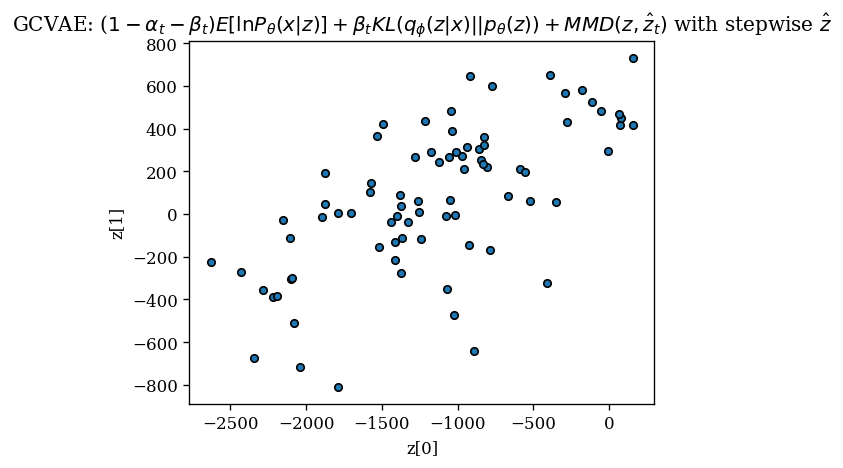

In [47]:
z_mean, z_std, z = model.model.encoder.predict(x_test, batch_size = batch_size)

fig = plt.figure(figsize=(5, 4))
plt.scatter(z[:, 0], z[:, 1], edgecolor="black", s = 20)
plt.xlabel('z[0]')
plt.ylabel('z[1]')
if loss_index == 0:
    plt.title('VAE Loss: $E [\ln P_{\\theta}(x|z)]$ + $KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 1:
    plt.title('$\\beta$-VAE: $E [\ln P_{\\theta}(x|z)]$ + $\\beta KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 2:
    plt.title('ControlVAE: $E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z))$')
elif loss_index == 3:
    plt.title('infoVAE: ($E [\ln P_{\theta}(x|z)] + \\beta KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z_{t+1}, \\hat{z}_t)$ with stepwise $\\hat{z}$')
elif loss_index == 4:
    plt.title('GCVAE: ($1-\\alpha_t- \\beta_t)E [\ln P_{\\theta}(x|z)] + \\beta_t KL(q_{\phi}(z|x)||p_{\\theta}(z)) + MMD (z,\\hat{z}_t)$ with stepwise $\\hat{z}$')


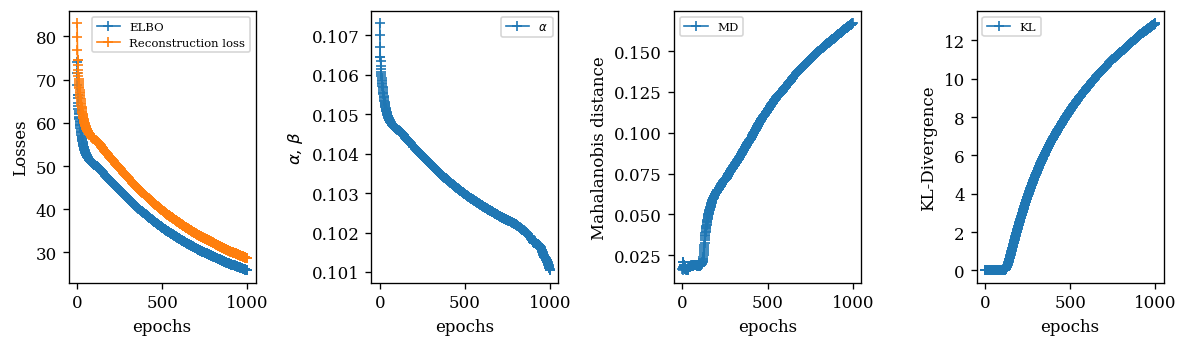

In [48]:
fs = 7
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].plot(np.arange(model.epoch), model.ELBO, label = 'ELBO', marker = '+', lw = 1.)
ax[0].plot(np.arange(model.epoch), model.RECON_LOSS, label = 'Reconstruction loss', marker = '+', lw = 1.)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Losses')
ax[1].plot(np.arange(model.epoch), model.ALPHA, label = '$\\alpha$', marker = '+', lw = 1.)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('$\\alpha$, $\\beta$')
ax[2].plot(np.arange(model.epoch), model.MMD, label = 'MD', marker = '+', lw = 1.)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('Mahalanobis distance')
ax[3].plot(np.arange(model.epoch), model.KL_DIV, label = 'KL', marker = '+', lw = 1.)
ax[3].set_xlabel('epochs')
ax[3].set_ylabel('KL-Divergence')
ax[0].legend(prop={"size":fs})
ax[1].legend(prop={"size":fs})
ax[2].legend(prop={"size":fs})
ax[3].legend(prop={"size":fs})
plt.tight_layout()

/home/ifeanyi.ezukwoke/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


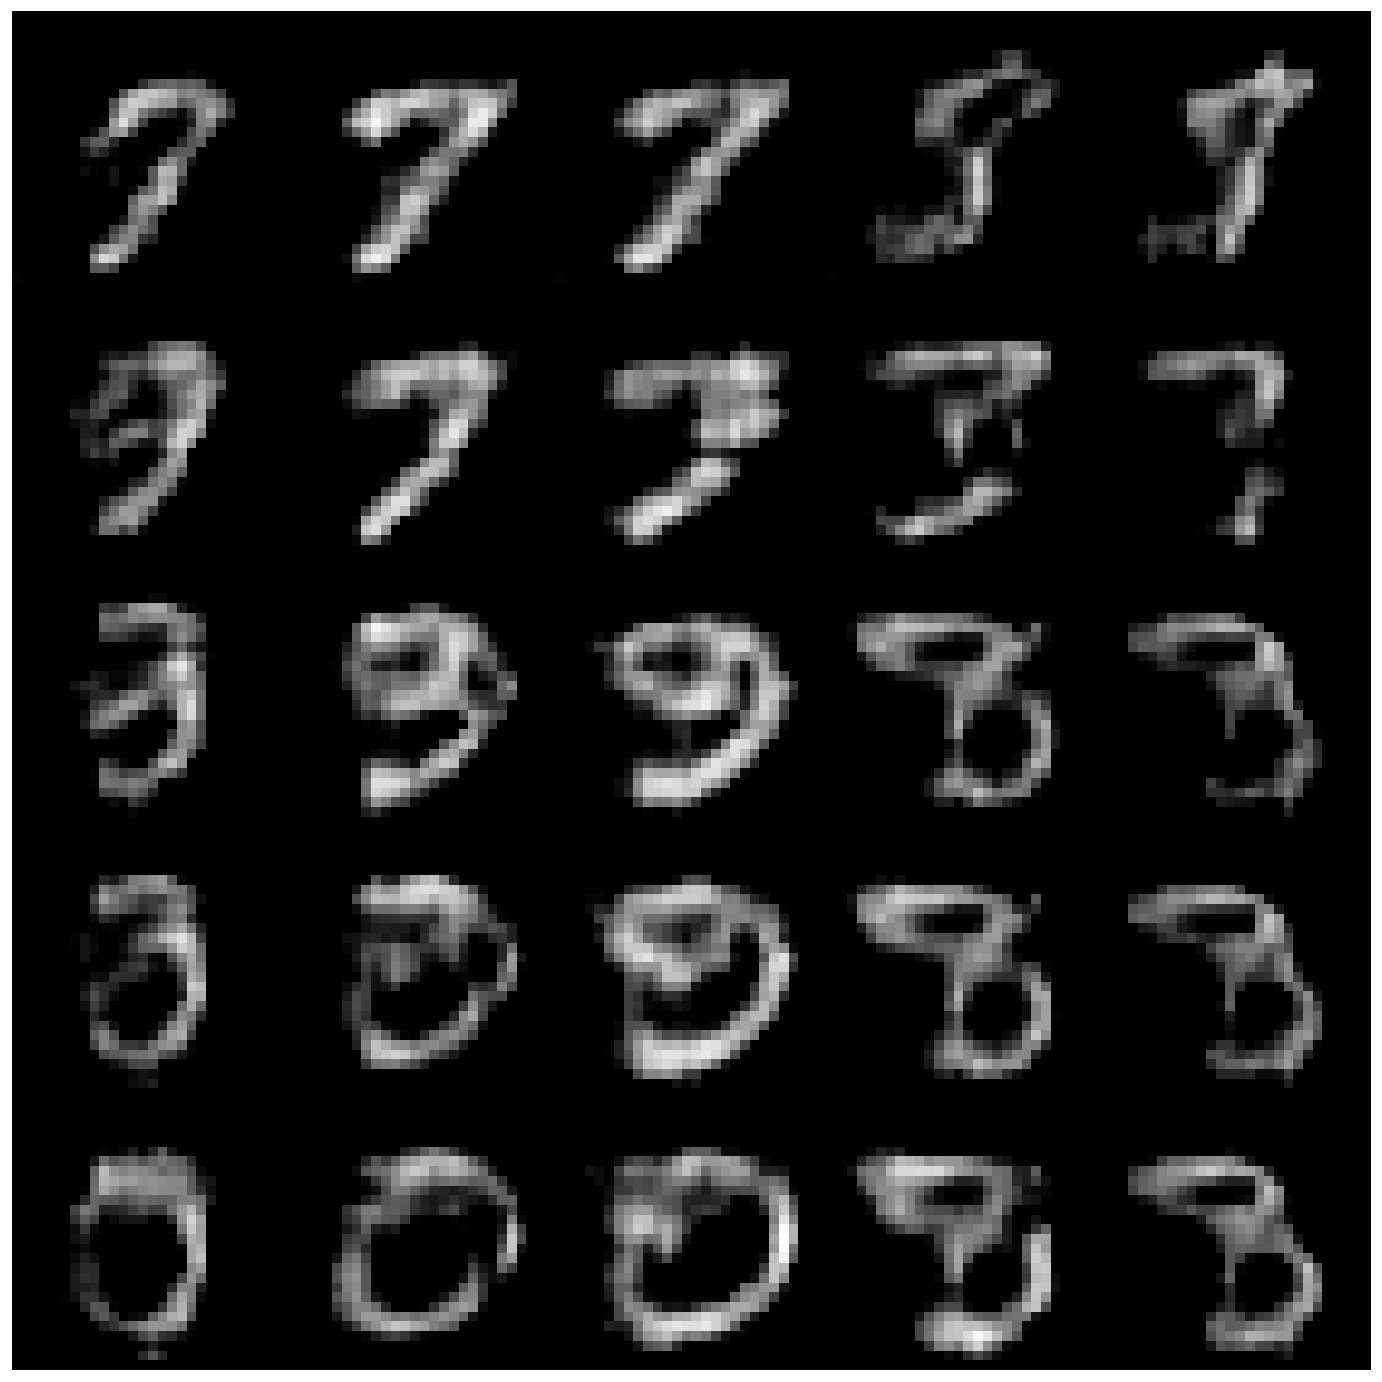

In [49]:
plot_latent_space(model.model, n= 5)